In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from scipy import integrate
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import warnings
warnings.filterwarnings('ignore')

Returns Data Overview:
              WFC         ETN        AMZN        QCOM         LMT          KO  \
count  249.000000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean     0.000933    0.001911    0.002511    0.001505   -0.000038   -0.000104   
std      0.017463    0.016669    0.020805    0.019780    0.011382    0.008474   
min     -0.071325   -0.073096   -0.084315   -0.081767   -0.047732   -0.048328   
25%     -0.008250   -0.005828   -0.009679   -0.009298   -0.005748   -0.005182   
50%      0.001224    0.003154    0.001078    0.000965   -0.000379    0.000320   
75%      0.009924    0.009936    0.015686    0.012659    0.005447    0.004658   
max      0.057580    0.066628    0.082693    0.066151    0.089337    0.028846   

              JNJ        ISRG         XOM         MDT  ...         KKR  \
count  249.000000  249.000000  249.000000  249.000000  ...  249.000000   
mean    -0.000341    0.001125    0.000003    0.000430  ...    0.002550   
std      0.010427    0.01

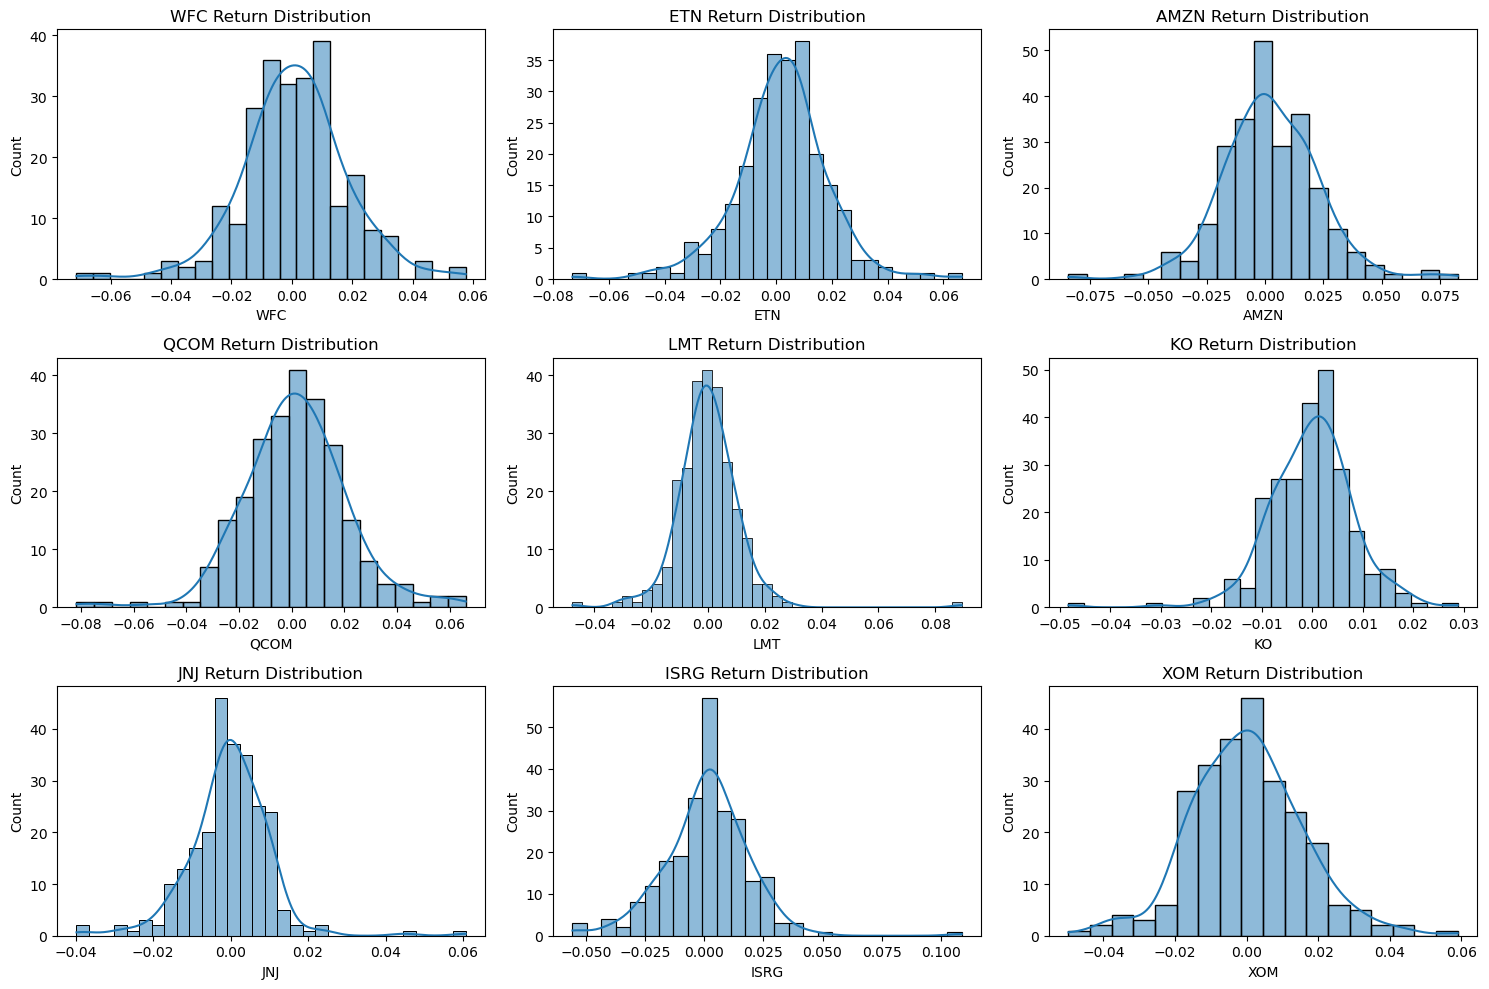

In [ ]:
# 1. Data Preparation
# Read price data
daily_prices = pd.read_csv('DailyPrices.csv')
daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])
daily_prices.set_index('Date', inplace=True)

# Read portfolio data
portfolio = pd.read_csv('initial_portfolio.csv')

# Read risk-free rate data
rf_data = pd.read_csv('rf.csv')
rf_data['Date'] = pd.to_datetime(rf_data['Date'])
rf_data.set_index('Date', inplace=True)

# Calculate returns
returns = daily_prices.pct_change().dropna()

# Find data before the holding period (data before 2024)
pre_holding_returns = returns[returns.index < '2024-01-01']

# Get the list of stocks in the portfolio
portfolio_stocks = portfolio['Symbol'].unique()

# Ensure all portfolio stocks are in the price data
for stock in portfolio_stocks:
    if stock not in daily_prices.columns:
        print(f"Warning: {stock} not found in price data")

# Only keep returns for stocks in the portfolio
portfolio_returns = pre_holding_returns[portfolio_stocks]

# Display basic statistics of the data
print("Returns Data Overview:")
print(portfolio_returns.describe())

# Visualize return distributions for some stocks
plt.figure(figsize=(15, 10))
for i, stock in enumerate(portfolio_stocks[:min(9, len(portfolio_stocks))]):
    plt.subplot(3, 3, i+1)
    sns.histplot(portfolio_returns[stock], kde=True)
    plt.title(f'{stock} Return Distribution')
plt.tight_layout()
plt.show()

In [30]:
# 2. Implement distribution fitting functions

# Normal distribution fitting function
def fit_normal(returns):
    mu, sigma = stats.norm.fit(returns)
    loglikelihood = np.sum(stats.norm.logpdf(returns, mu, sigma))
    aic = -2 * loglikelihood + 2 * 2  # 2 parameters
    bic = -2 * loglikelihood + 2 * np.log(len(returns))
    params = {'mu': mu, 'sigma': sigma}
    return {'distribution': 'Normal', 'params': params, 'loglikelihood': loglikelihood, 'aic': aic, 'bic': bic}

# Simplified generalized T distribution fitting function
def fit_generalized_t(returns):
    """
    Try using t distribution from scipy.stats as a simplified version of generalized T distribution
    """
    try:
        # Use Student's t distribution as a simplification
        df, loc, scale = stats.t.fit(returns)
        loglikelihood = np.sum(stats.t.logpdf(returns, df, loc, scale))
        
        # We only have 3 parameters: df, loc, scale
        aic = -2 * loglikelihood + 2 * 3
        bic = -2 * loglikelihood + 3 * np.log(len(returns))
        
        params = {'df': df, 'loc': loc, 'scale': scale}
        return {
            'distribution': 'Generalized T', 
            'params': params, 
            'loglikelihood': loglikelihood, 
            'aic': aic, 
            'bic': bic
        }
    except:
        print("Warning: Simplified Generalized T fitting failed")
        return {
            'distribution': 'Generalized T', 
            'params': None, 
            'loglikelihood': -np.inf, 
            'aic': np.inf, 
            'bic': np.inf
        }
        
# # Complete generalized T distribution fitting function
# def fit_generalized_t(returns):
#     """
#     Implement a more complete generalized T distribution fitting
#     """
#     def gen_t_logpdf(x, mu, sigma, nu, tau):
#         """
#         Log probability density function of generalized T distribution
#         Parameters:
#             mu: location parameter
#             sigma: scale parameter (>0)
#             nu: degrees of freedom parameter (>0, controls tail thickness)
#             tau: shape parameter (>0, controls kurtosis)
#         """
#         # Standardized variable
#         z = (x - mu) / sigma
        
#         # Calculate constant term
#         try:
#             from scipy.special import beta
#             log_c = np.log(tau) - np.log(2 * sigma) - np.log(nu**(1/tau)) - np.log(beta(1/tau, nu/tau))
            
#             # Calculate log PDF
#             log_pdf = log_c - (nu + 1/tau)/tau * np.log(1 + (np.abs(z)**tau)/nu)
#             return log_pdf
#         except:
#             return -np.inf * np.ones_like(x)
    
#     def neg_log_likelihood(params):
#         """Negative log likelihood function"""
#         mu, sigma, nu, tau = params
        
#         # Parameter constraints
#         if sigma <= 0 or nu <= 0 or tau <= 0:
#             return np.inf
        
#         try:
#             log_pdf_values = gen_t_logpdf(returns, mu, sigma, nu, tau)
#             return -np.sum(log_pdf_values)
#         except:
#             return np.inf
    
#     # Initial parameter estimates
#     mu_init = np.median(returns)  # Use median as initial location parameter
#     sigma_init = np.median(np.abs(returns - mu_init)) * 1.4826  # MAD estimate
#     nu_init = 5.0  # Initial degrees of freedom
#     tau_init = 1.5  # Initial shape parameter
    
#     initial_params = [mu_init, sigma_init, nu_init, tau_init]
    
#     # Parameter bounds
#     bounds = [
#         (None, None),  # mu can be any value
#         (1e-6, None),  # sigma > 0
#         (1e-6, 50),    # 0 < nu < 50
#         (0.1, 10)      # 0.1 < tau < 10
#     ]
    
#     try:
#         # Try different optimization methods
#         methods = ['L-BFGS-B', 'SLSQP', 'TNC']
#         best_result = None
#         best_nll = np.inf
        
#         for method in methods:
#             try:
#                 result = minimize(neg_log_likelihood, initial_params, method=method, bounds=bounds)
#                 if result.success and result.fun < best_nll:
#                     best_result = result
#                     best_nll = result.fun
#             except:
#                 continue
        
#         if best_result is not None and np.isfinite(best_nll):
#             mu, sigma, nu, tau = best_result.x
#             loglikelihood = -best_nll
            
#             # Check if parameters are in reasonable range
#             if sigma > 0 and nu > 0 and tau > 0 and np.isfinite(loglikelihood):
#                 aic = -2 * loglikelihood + 2 * 4  # 4 parameters
#                 bic = -2 * loglikelihood + 4 * np.log(len(returns))
#                 params = {'mu': mu, 'sigma': sigma, 'nu': nu, 'tau': tau}
                
#                 print(f"Generalized T fit successful: mu={mu:.6f}, sigma={sigma:.6f}, nu={nu:.6f}, tau={tau:.6f}")
#                 return {'distribution': 'Generalized T', 'params': params, 'loglikelihood': loglikelihood, 'aic': aic, 'bic': bic}
        
#         # If optimization fails or results are unreasonable, return infinitely poor fit
#         print("Generalized T optimization failed to find valid parameters")
#         return {'distribution': 'Generalized T', 'params': None, 'loglikelihood': -np.inf, 'aic': np.inf, 'bic': np.inf}
    
#     except Exception as e:
#         print(f"Error in Generalized T fitting: {str(e)}")
#         return {'distribution': 'Generalized T', 'params': None, 'loglikelihood': -np.inf, 'aic': np.inf, 'bic': np.inf}    

# Normal Inverse Gaussian distribution fitting function
def fit_normal_inverse_gaussian(returns):
    try:
        # Use the Normal Inverse Gaussian distribution from scipy
        params = stats.norminvgauss.fit(returns)
        a, b, loc, scale = params
        
        # Check if parameters are valid
        if not np.isfinite(a) or not np.isfinite(b) or not np.isfinite(loc) or not np.isfinite(scale):
            print(f"Warning: NIG fitting produced non-finite parameters: a={a}, b={b}, loc={loc}, scale={scale}")
            return {'distribution': 'Normal Inverse Gaussian', 'params': None, 'loglikelihood': -np.inf, 'aic': np.inf, 'bic': np.inf}
        
        # Calculate log likelihood
        loglikelihood = np.sum(stats.norminvgauss.logpdf(returns, a, b, loc, scale))
        
        # Check if log likelihood is valid
        if not np.isfinite(loglikelihood):
            print(f"Warning: NIG fitting produced non-finite log-likelihood")
            return {'distribution': 'Normal Inverse Gaussian', 'params': None, 'loglikelihood': -np.inf, 'aic': np.inf, 'bic': np.inf}
        
        aic = -2 * loglikelihood + 2 * 4  # 4 parameters
        bic = -2 * loglikelihood + 4 * np.log(len(returns))
        
        params_dict = {'a': a, 'b': b, 'loc': loc, 'scale': scale}
        return {'distribution': 'Normal Inverse Gaussian', 'params': params_dict, 'loglikelihood': loglikelihood, 'aic': aic, 'bic': bic}
    except Exception as e:
        # If fitting fails, print the specific error and return infinitely poor fit
        print(f"Warning: NIG fitting failed with error: {str(e)}")
        return {'distribution': 'Normal Inverse Gaussian', 'params': None, 'loglikelihood': -np.inf, 'aic': np.inf, 'bic': np.inf}
    
# Skew Normal distribution fitting function
def fit_skew_normal(returns):
    try:
        # Use the Skew Normal distribution from scipy
        shape, loc, scale = stats.skewnorm.fit(returns)
        loglikelihood = np.sum(stats.skewnorm.logpdf(returns, shape, loc, scale))
        aic = -2 * loglikelihood + 2 * 3  # 3 parameters
        bic = -2 * loglikelihood + 3 * np.log(len(returns))
        params_dict = {'shape': shape, 'loc': loc, 'scale': scale}
        return {'distribution': 'Skew Normal', 'params': params_dict, 'loglikelihood': loglikelihood, 'aic': aic, 'bic': bic}
    except:
        # If fitting fails, return infinitely poor fit
        return {'distribution': 'Skew Normal', 'params': None, 'loglikelihood': -np.inf, 'aic': np.inf, 'bic': np.inf}


AIC Values for WFC:
  Normal: -1306.1217
  Generalized T: -1320.4719
  Normal Inverse Gaussian: -1318.8653
  Skew Normal: -1305.7169

Best Fit Distribution - WFC: Generalized T
  df: 5.003669
  loc: 0.000983
  scale: 0.013692


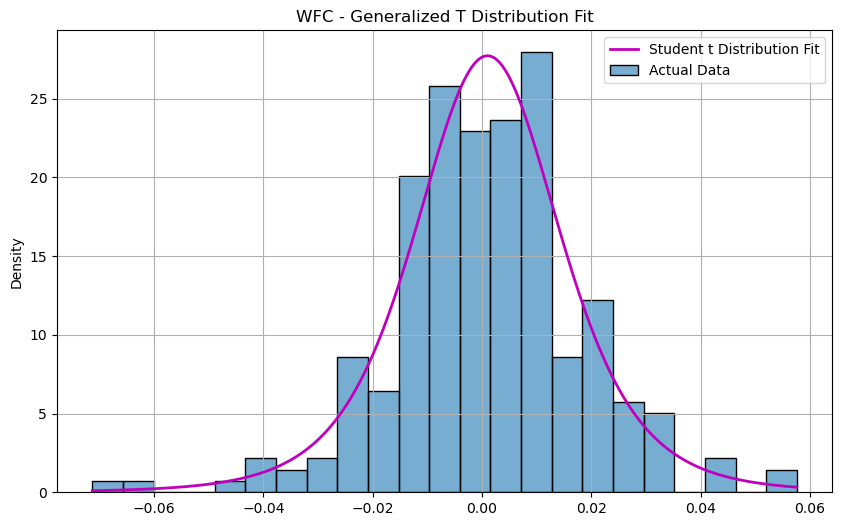


AIC Values for ETN:
  Normal: -1329.2839
  Generalized T: -1353.6778
  Normal Inverse Gaussian: -1353.4151
  Skew Normal: -1329.8748

Best Fit Distribution - ETN: Generalized T
  df: 3.878344
  loc: 0.002363
  scale: 0.012027


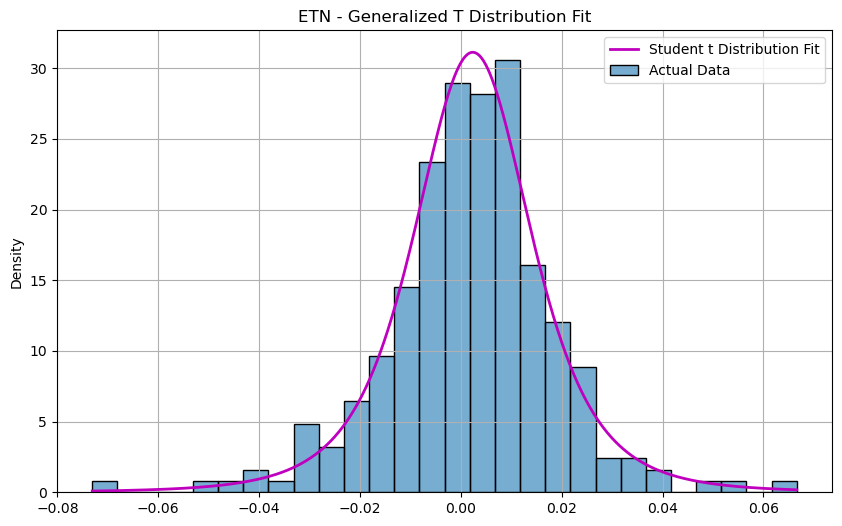


AIC Values for AMZN:
  Normal: -1218.9100
  Generalized T: -1232.2503
  Normal Inverse Gaussian: -1230.1297
  Skew Normal: -1218.4181

Best Fit Distribution - AMZN: Generalized T
  df: 5.921859
  loc: 0.002174
  scale: 0.016899


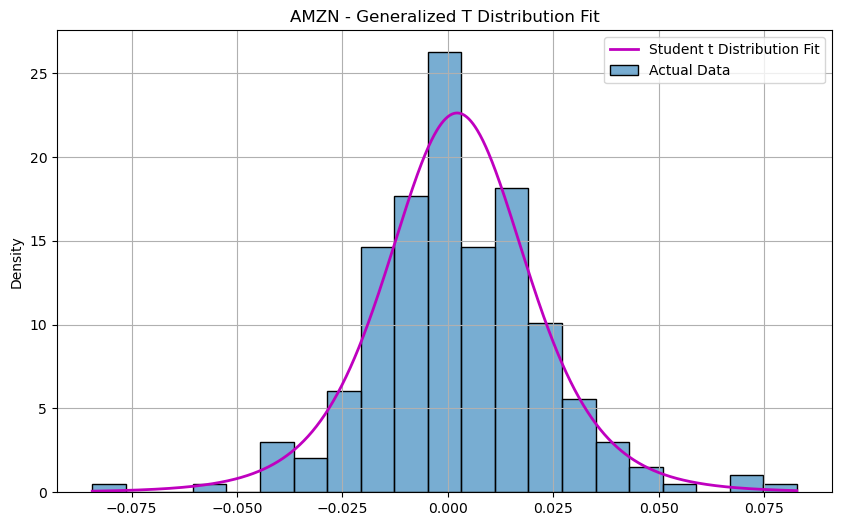


AIC Values for QCOM:
  Normal: -1244.0743
  Generalized T: -1259.5196
  Normal Inverse Gaussian: -1257.3757
  Skew Normal: -1242.7974

Best Fit Distribution - QCOM: Generalized T
  df: 5.220655
  loc: 0.001358
  scale: 0.015614


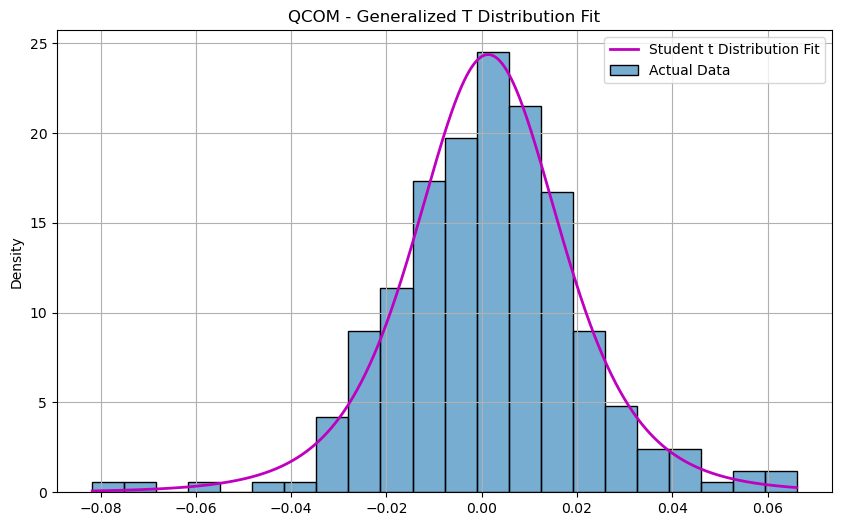


AIC Values for LMT:
  Normal: -1519.2627
  Generalized T: -1589.4067
  Normal Inverse Gaussian: -1583.8693
  Skew Normal: -1528.9137

Best Fit Distribution - LMT: Generalized T
  df: 3.703325
  loc: -0.000160
  scale: 0.007392


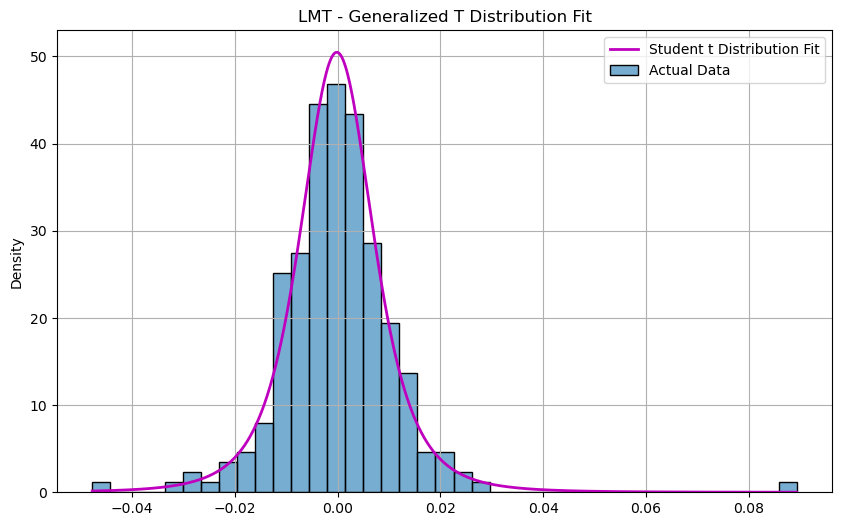


AIC Values for KO:
  Normal: -1666.1811
  Generalized T: -1690.4399
  Normal Inverse Gaussian: -1687.5859
  Skew Normal: -1670.5936

Best Fit Distribution - KO: Generalized T
  df: 5.215481
  loc: 0.000059
  scale: 0.006571


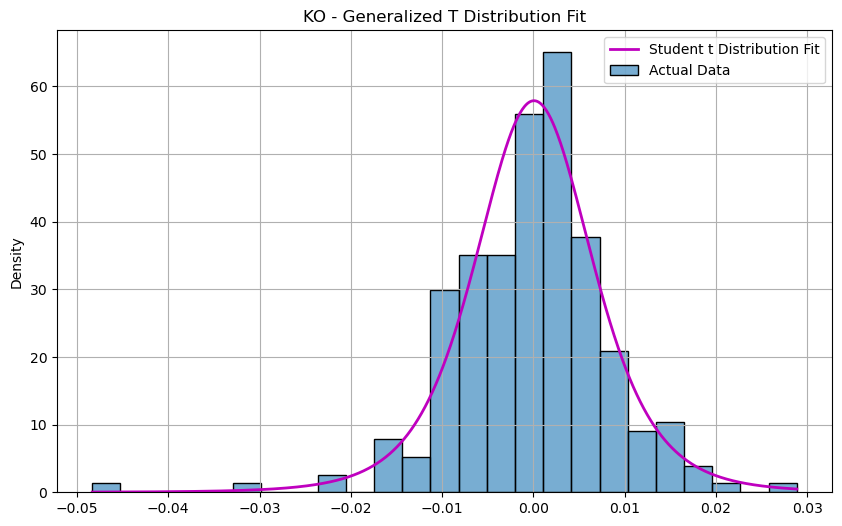


AIC Values for JNJ:
  Normal: -1562.9395
  Generalized T: -1612.0728
  Normal Inverse Gaussian: -1609.3521
  Skew Normal: -1564.2458

Best Fit Distribution - JNJ: Generalized T
  df: 3.605038
  loc: -0.000001
  scale: 0.007007


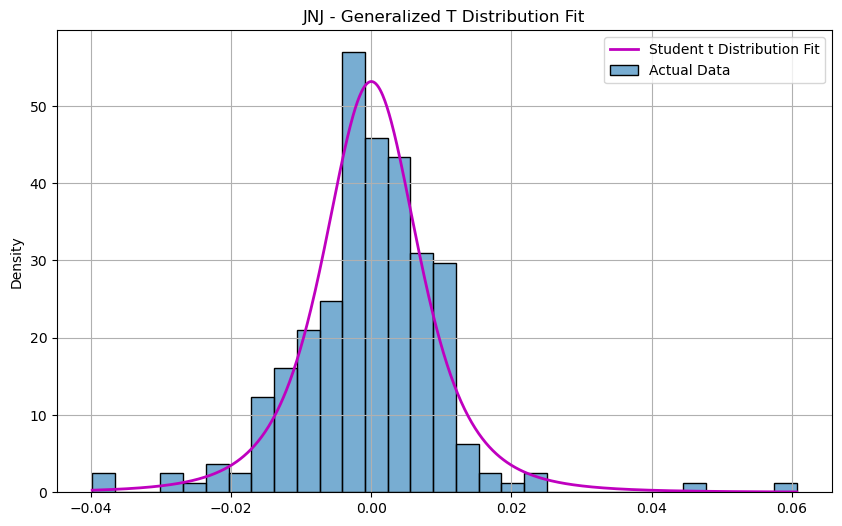


AIC Values for ISRG:
  Normal: -1285.4682
  Generalized T: -1311.5888
  Normal Inverse Gaussian: -1310.0956
  Skew Normal: -1285.9070

Best Fit Distribution - ISRG: Generalized T
  df: 4.700216
  loc: 0.001544
  scale: 0.013746


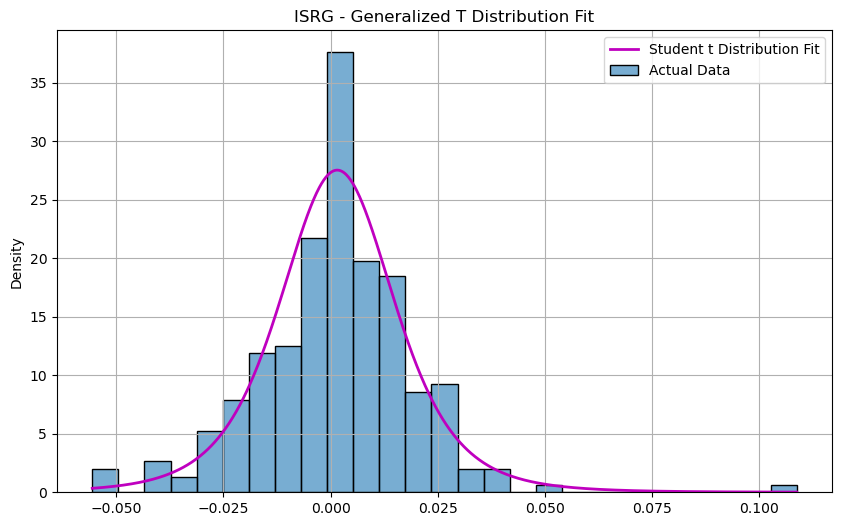


AIC Values for XOM:
  Normal: -1359.8415
  Generalized T: -1364.0375
  Normal Inverse Gaussian: -1362.8817
  Skew Normal: -1359.3585

Best Fit Distribution - XOM: Generalized T
  df: 7.880730
  loc: -0.000220
  scale: 0.013561


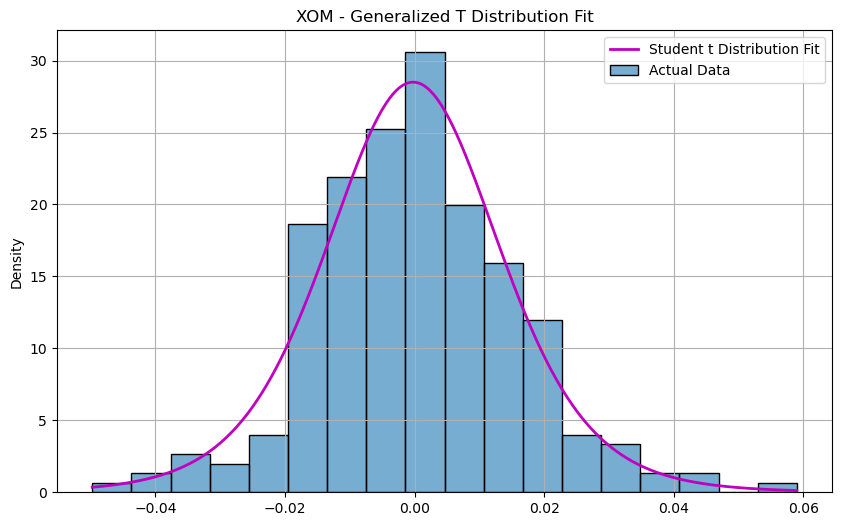


AIC Values for MDT:
  Normal: -1434.4758
  Generalized T: -1448.8119
  Normal Inverse Gaussian: -1447.9547
  Skew Normal: -1432.7074

Best Fit Distribution - MDT: Generalized T
  df: 4.582972
  loc: 0.000457
  scale: 0.010374


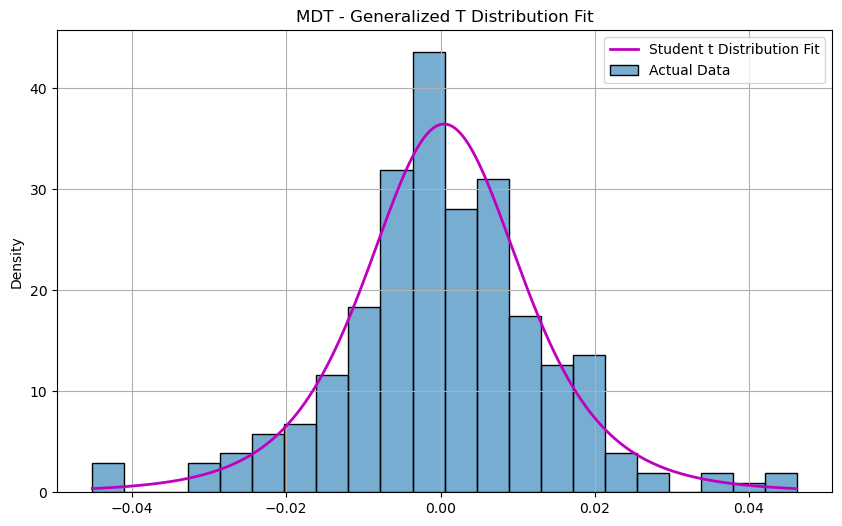


AIC Values for DHR:
  Normal: -1372.3133
  Generalized T: -1395.2150
  Normal Inverse Gaussian: -1392.6085
  Skew Normal: -1376.2225

Best Fit Distribution - DHR: Generalized T
  df: 5.305482
  loc: 0.000452
  scale: 0.011929


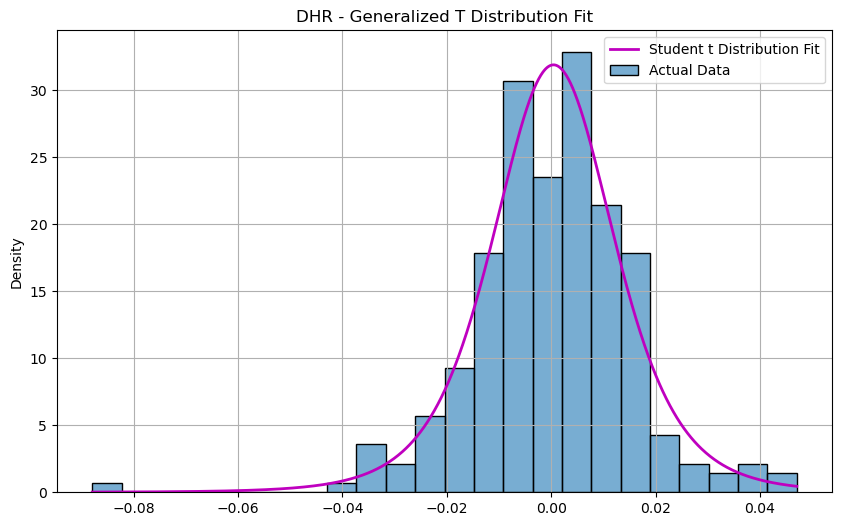


AIC Values for PLD:
  Normal: -1329.2010
  Generalized T: -1338.0347
  Normal Inverse Gaussian: -1335.8078
  Skew Normal: -1329.4369

Best Fit Distribution - PLD: Generalized T
  df: 6.675702
  loc: 0.000886
  scale: 0.013945


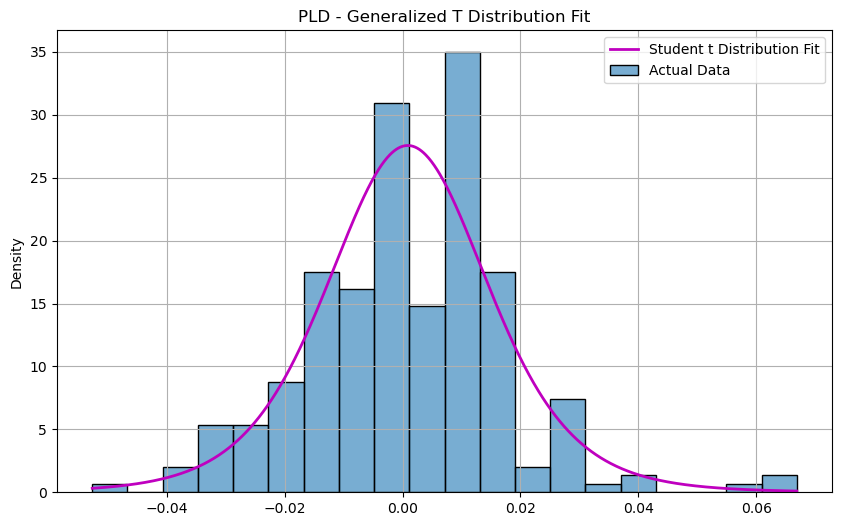


AIC Values for BA:
  Normal: -1316.8275
  Generalized T: -1335.8107
  Normal Inverse Gaussian: -1334.1814
  Skew Normal: -1316.3737

Best Fit Distribution - BA: Generalized T
  df: 4.703008
  loc: 0.001328
  scale: 0.013095


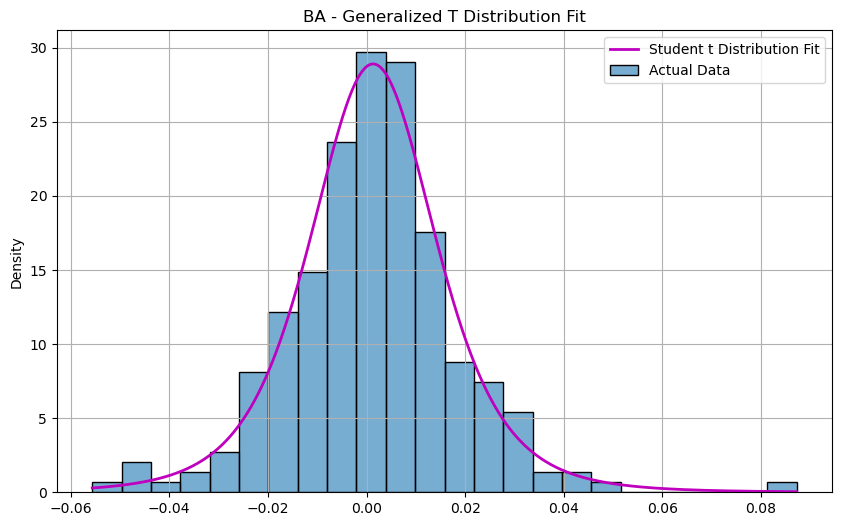


AIC Values for PG:
  Normal: -1614.3557
  Generalized T: -1625.1328
  Normal Inverse Gaussian: -1623.5407
  Skew Normal: -1612.6310

Best Fit Distribution - PG: Generalized T
  df: 5.519839
  loc: 0.000022
  scale: 0.007577


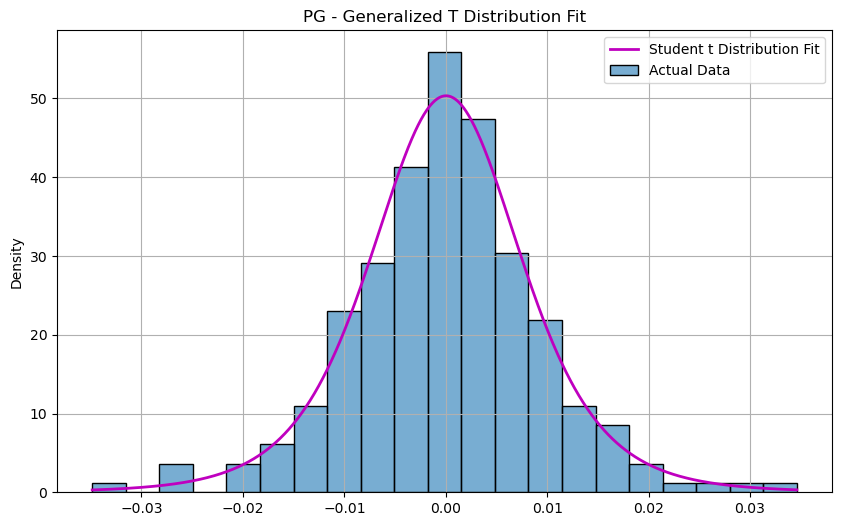


AIC Values for MRK:
  Normal: -1497.9679
  Generalized T: -1501.3811
  Normal Inverse Gaussian: -1500.2072
  Skew Normal: -1496.5357

Best Fit Distribution - MRK: Generalized T
  df: 8.068428
  loc: 0.000238
  scale: 0.010324


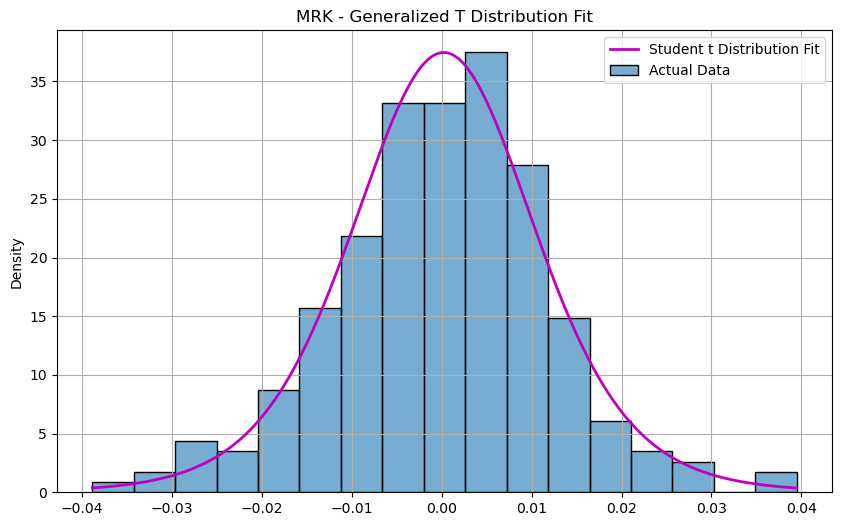


AIC Values for AMD:
  Normal: -1043.8400
  Generalized T: -1062.8431
  Normal Inverse Gaussian: -1062.7884
  Skew Normal: -1049.0668

Best Fit Distribution - AMD: Generalized T
  df: 4.697519
  loc: 0.002620
  scale: 0.022648


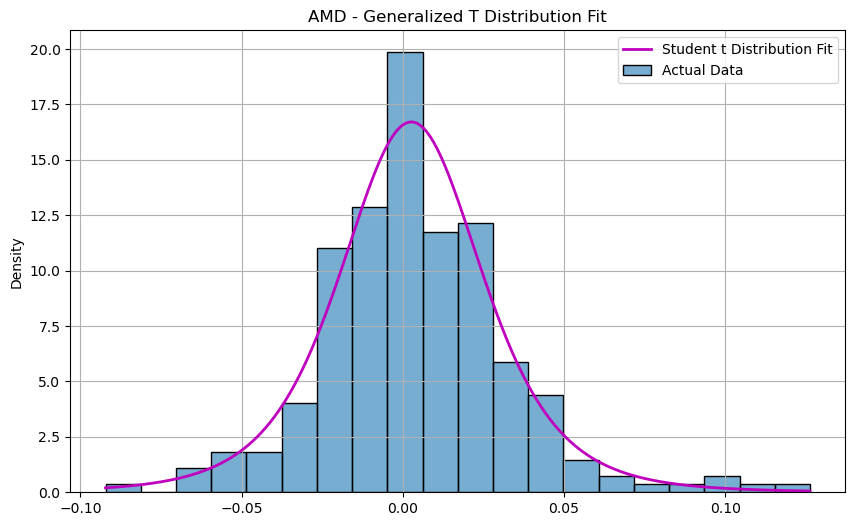


AIC Values for BX:
  Normal: -1193.8799
  Generalized T: -1200.5003
  Normal Inverse Gaussian: -1199.5286
  Skew Normal: -1192.9337

Best Fit Distribution - BX: Generalized T
  df: 6.305933
  loc: 0.002776
  scale: 0.018210


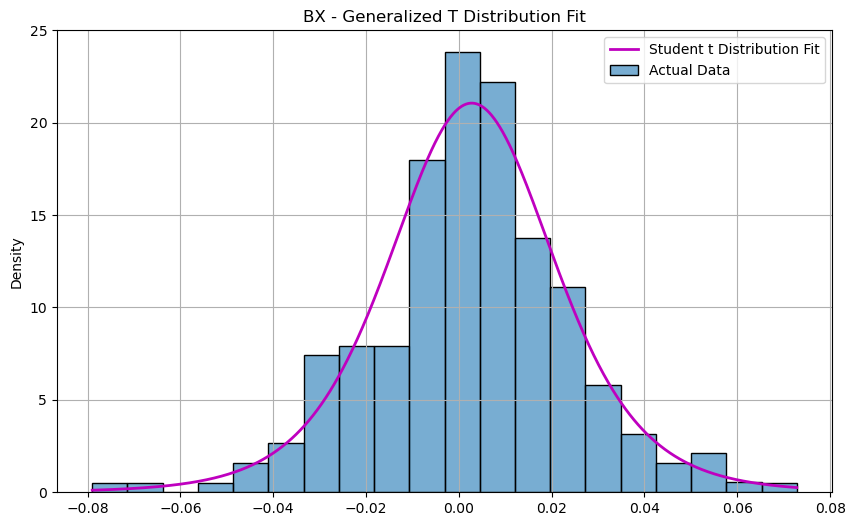


AIC Values for PM:
  Normal: -1564.8787
  Generalized T: -1570.1379
  Normal Inverse Gaussian: -1568.3048
  Skew Normal: -1565.1862

Best Fit Distribution - PM: Generalized T
  df: 8.156222
  loc: 0.000071
  scale: 0.009006


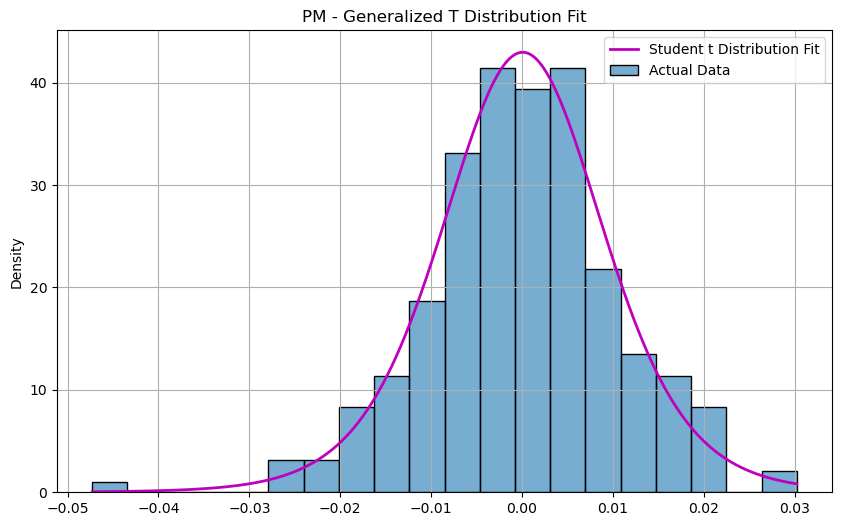


AIC Values for SCHW:
  Normal: -1097.4018
  Generalized T: -1164.1639
  Normal Inverse Gaussian: -1161.7303
  Skew Normal: -1099.5400

Best Fit Distribution - SCHW: Generalized T
  df: 2.839135
  loc: -0.000195
  scale: 0.015857


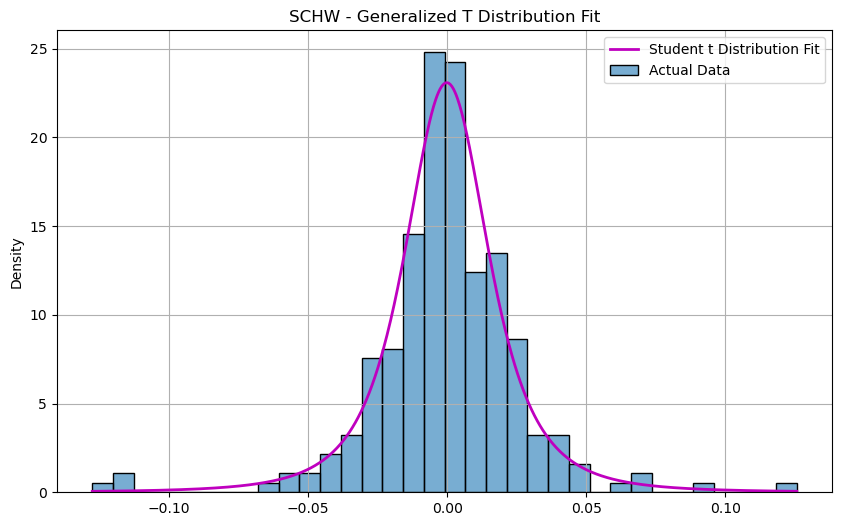


AIC Values for VZ:
  Normal: -1399.8169
  Generalized T: -1466.0339
  Normal Inverse Gaussian: -1462.5936
  Skew Normal: -1403.6350

Best Fit Distribution - VZ: Generalized T
  df: 3.271241
  loc: 0.000348
  scale: 0.009106


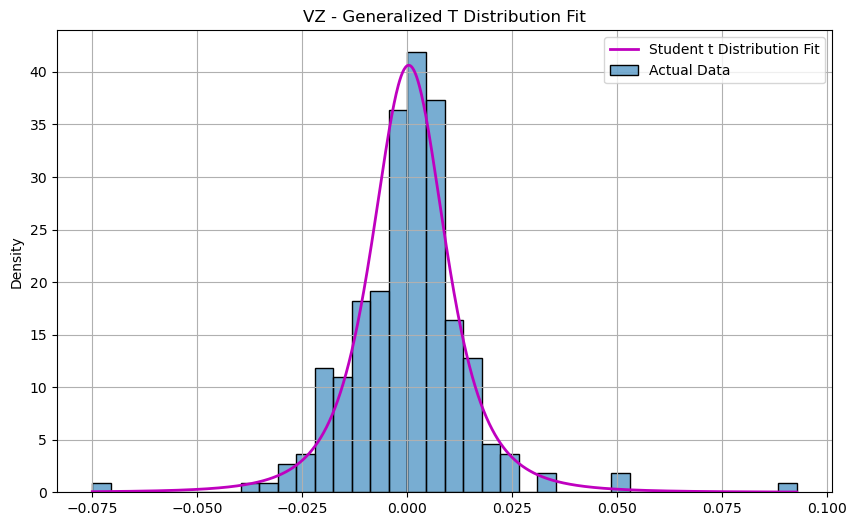


AIC Values for COP:
  Normal: -1291.1072
  Generalized T: -1307.3611
  Normal Inverse Gaussian: -1304.5888
  Skew Normal: -1292.9362

Best Fit Distribution - COP: Generalized T
  df: 5.830128
  loc: 0.000196
  scale: 0.014492


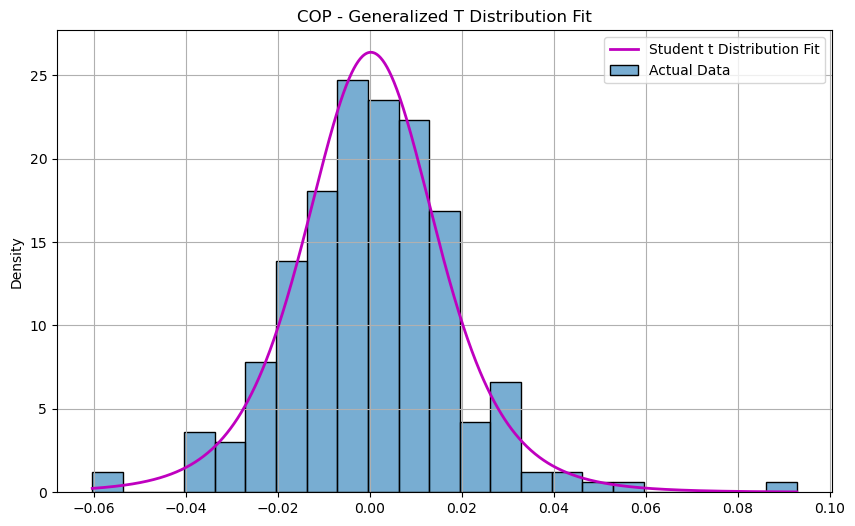


AIC Values for ADI:
  Normal: -1334.6806
  Generalized T: -1348.8319
  Normal Inverse Gaussian: -1346.1668
  Skew Normal: -1333.1394

Best Fit Distribution - ADI: Generalized T
  df: 6.363938
  loc: 0.000929
  scale: 0.013540


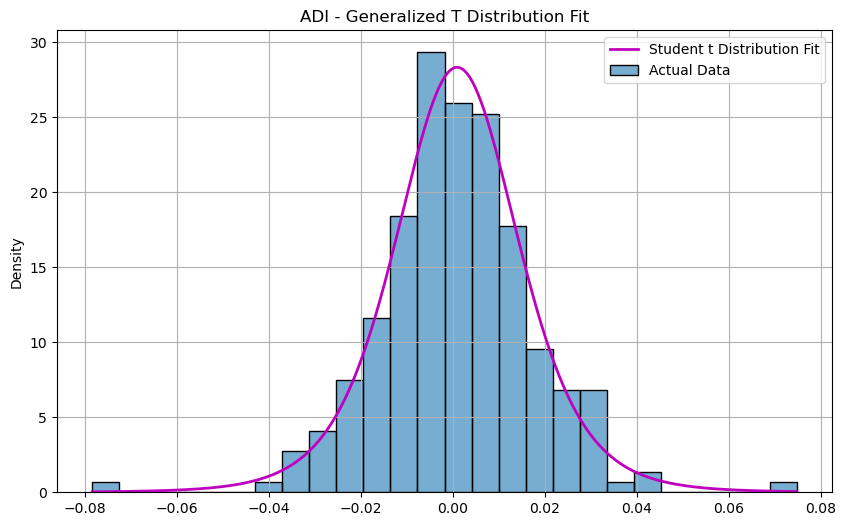


AIC Values for BAC:
  Normal: -1321.1751
  Generalized T: -1338.3414
  Normal Inverse Gaussian: -1338.0979
  Skew Normal: -1320.8851

Best Fit Distribution - BAC: Generalized T
  df: 4.267521
  loc: -0.000116
  scale: 0.012725


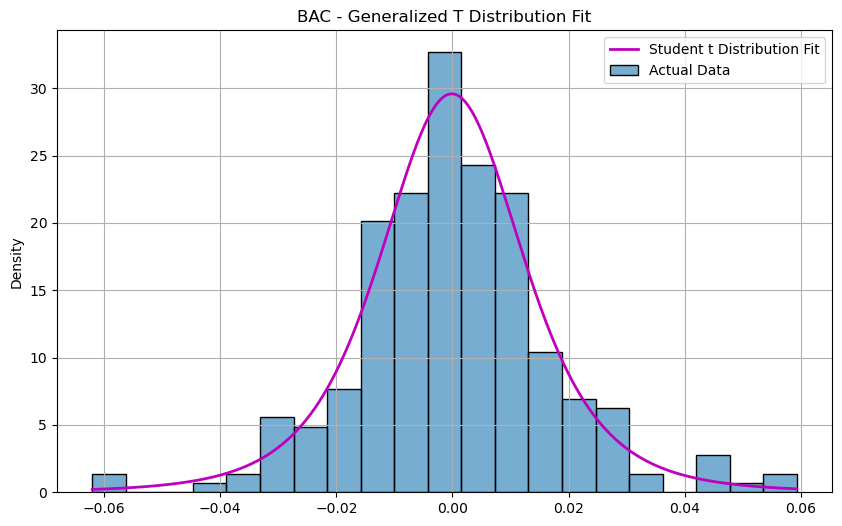


AIC Values for NOW:
  Normal: -1241.8454
  Generalized T: -1255.0302
  Normal Inverse Gaussian: -1259.4347
  Skew Normal: -1247.7247

Best Fit Distribution - NOW: Normal Inverse Gaussian
  a: 0.968985
  b: -0.225123
  loc: 0.007200
  scale: 0.019118


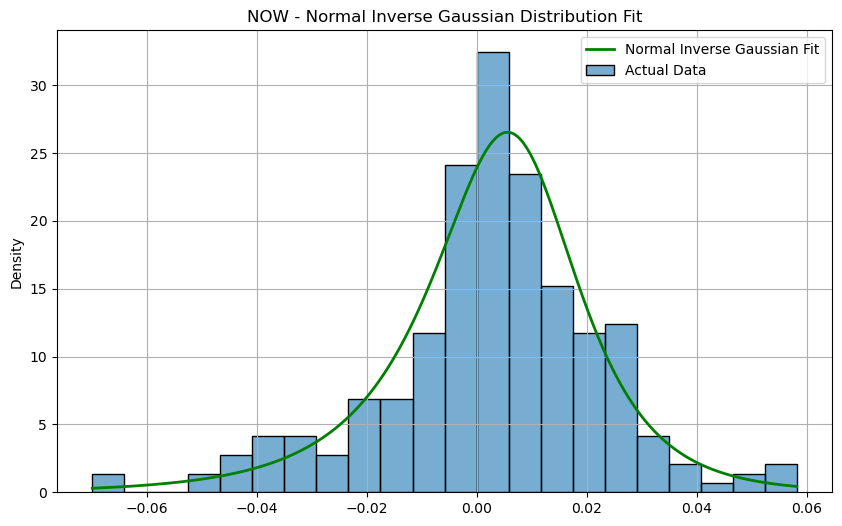


AIC Values for TMO:
  Normal: -1404.8881
  Generalized T: -1415.8711
  Normal Inverse Gaussian: -1414.7062
  Skew Normal: -1403.5633

Best Fit Distribution - TMO: Generalized T
  df: 5.160945
  loc: -0.000095
  scale: 0.011379


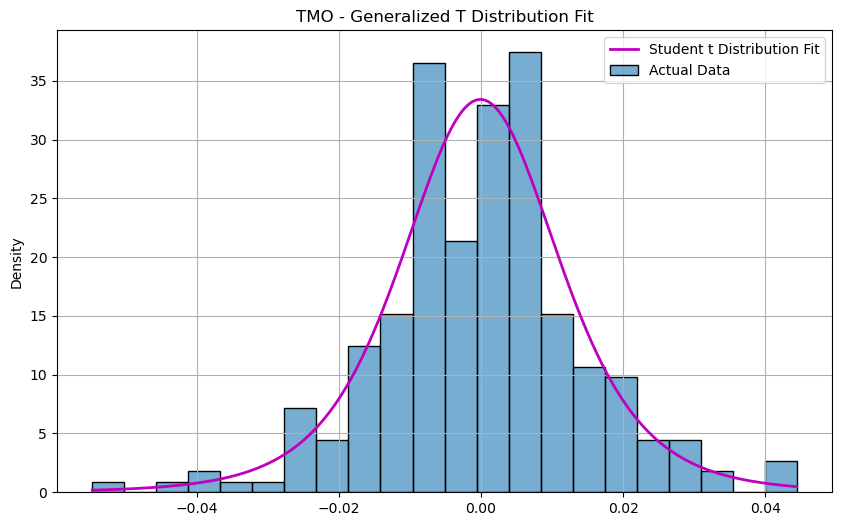


AIC Values for CVX:
  Normal: -1399.2675
  Generalized T: -1418.6456
  Normal Inverse Gaussian: -1417.2281
  Skew Normal: -1400.7301

Best Fit Distribution - CVX: Generalized T
  df: 4.553447
  loc: -0.000089
  scale: 0.011005


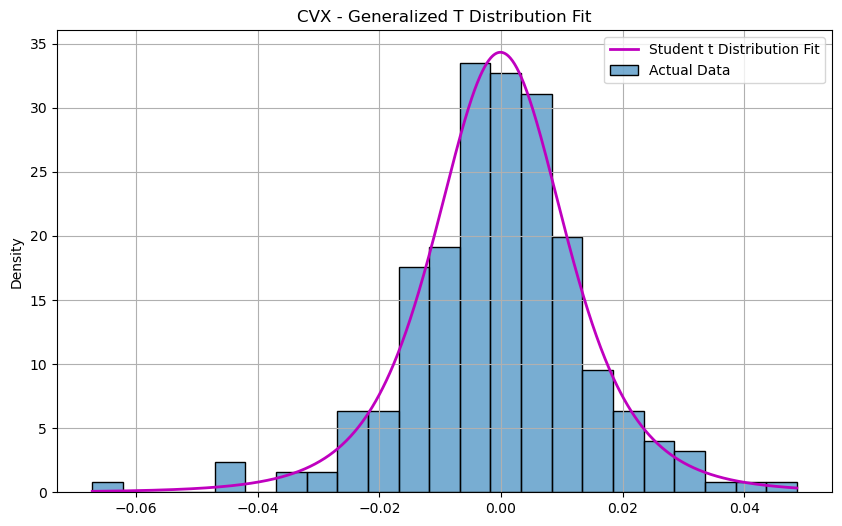


AIC Values for ANET:
  Normal: -1057.2325
  Generalized T: -1166.4653
  Normal Inverse Gaussian: -1160.8306
  Skew Normal: -1065.1157

Best Fit Distribution - ANET: Generalized T
  df: 2.744064
  loc: 0.002388
  scale: 0.015570


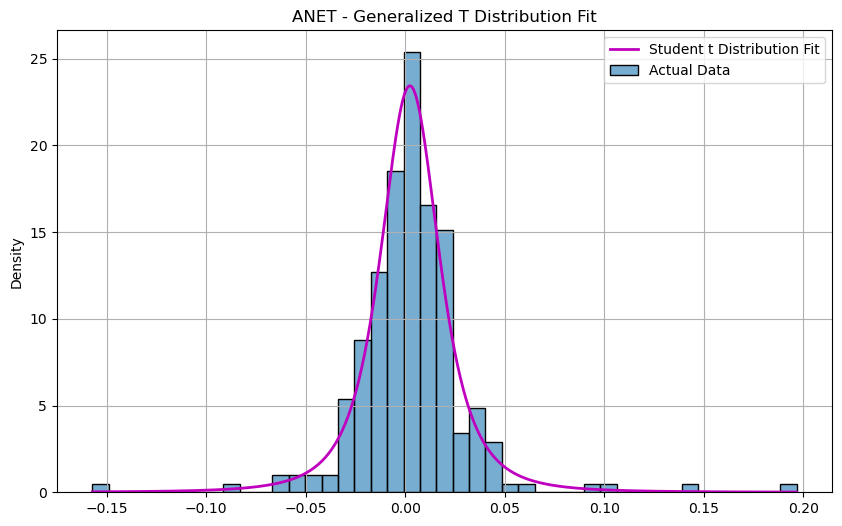


AIC Values for NVDA:
  Normal: -1028.0003
  Generalized T: -1086.8051
  Normal Inverse Gaussian: -1084.6636
  Skew Normal: -1062.6208

Best Fit Distribution - NVDA: Generalized T
  df: 4.789426
  loc: 0.003596
  scale: 0.021680


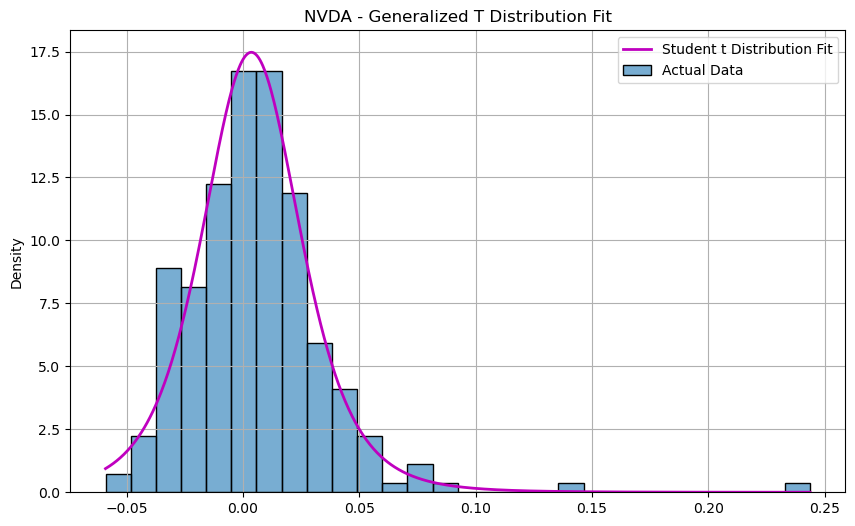


AIC Values for GE:
  Normal: -1371.7507
  Generalized T: -1380.7352
  Normal Inverse Gaussian: -1381.9263
  Skew Normal: -1380.8351

Best Fit Distribution - GE: Normal Inverse Gaussian
  a: 6.188196
  b: 2.372082
  loc: -0.011103
  scale: 0.033400


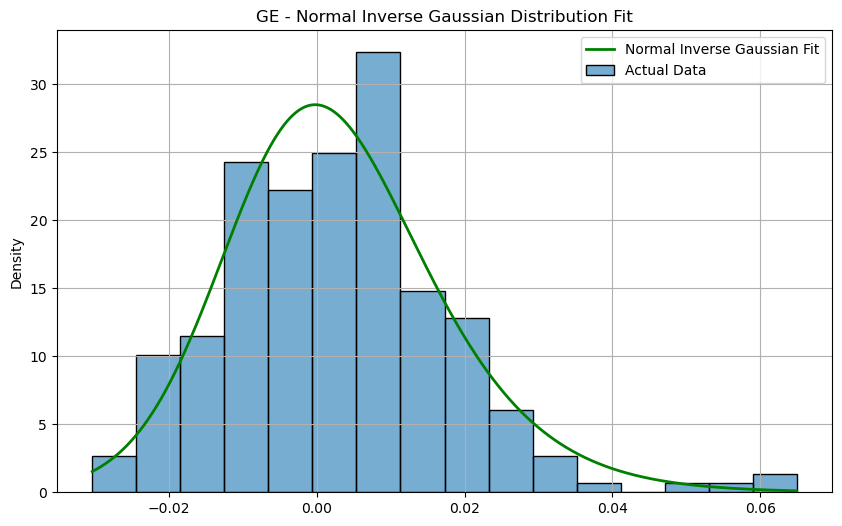


AIC Values for GILD:
  Normal: -1462.0549
  Generalized T: -1464.3701
  Normal Inverse Gaussian: -1462.8165
  Skew Normal: -1460.1852

Best Fit Distribution - GILD: Generalized T
  df: 8.569309
  loc: 0.000049
  scale: 0.011206


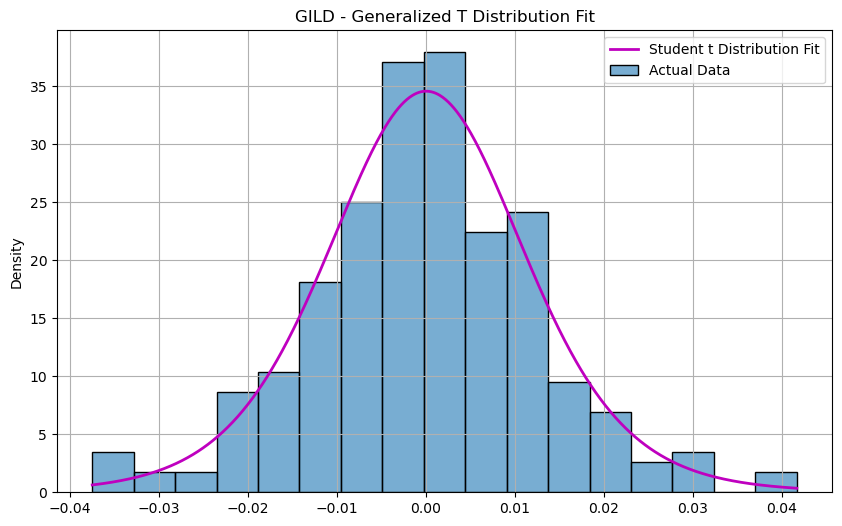


AIC Values for MU:
  Normal: -1172.4309
  Generalized T: -1185.7138
  Normal Inverse Gaussian: -1194.7455
  Skew Normal: -1189.3010

Best Fit Distribution - MU: Normal Inverse Gaussian
  a: 1.453044
  b: 0.548076
  loc: -0.007705
  scale: 0.024821


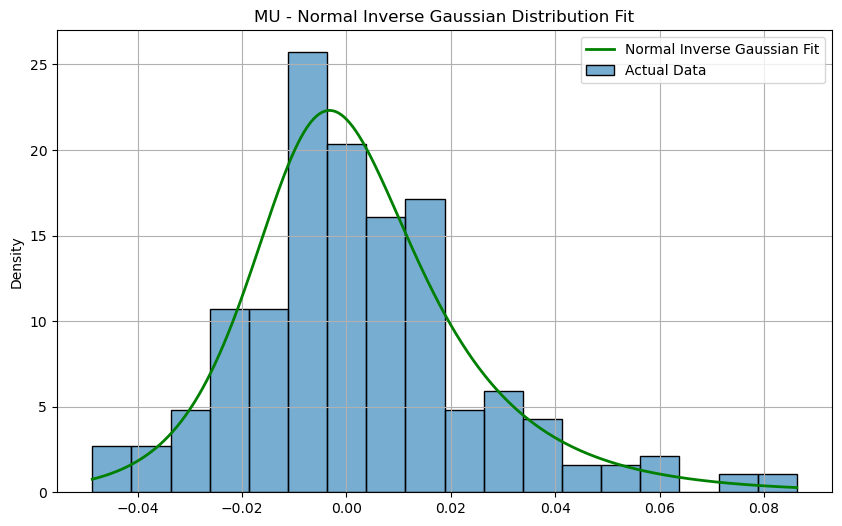


AIC Values for CMCSA:
  Normal: -1378.1729
  Generalized T: -1436.2221
  Normal Inverse Gaussian: -1428.9158
  Skew Normal: -1381.0498

Best Fit Distribution - CMCSA: Generalized T
  df: 4.556058
  loc: 0.000909
  scale: 0.010624


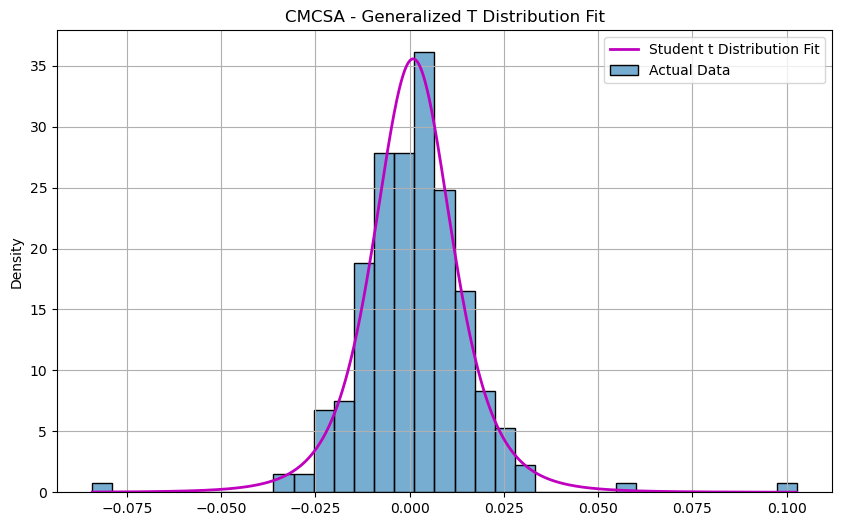


AIC Values for DIS:
  Normal: -1329.8309
  Generalized T: -1351.3903
  Normal Inverse Gaussian: -1349.0242
  Skew Normal: -1329.2383

Best Fit Distribution - DIS: Generalized T
  df: 4.908405
  loc: 0.000222
  scale: 0.012814


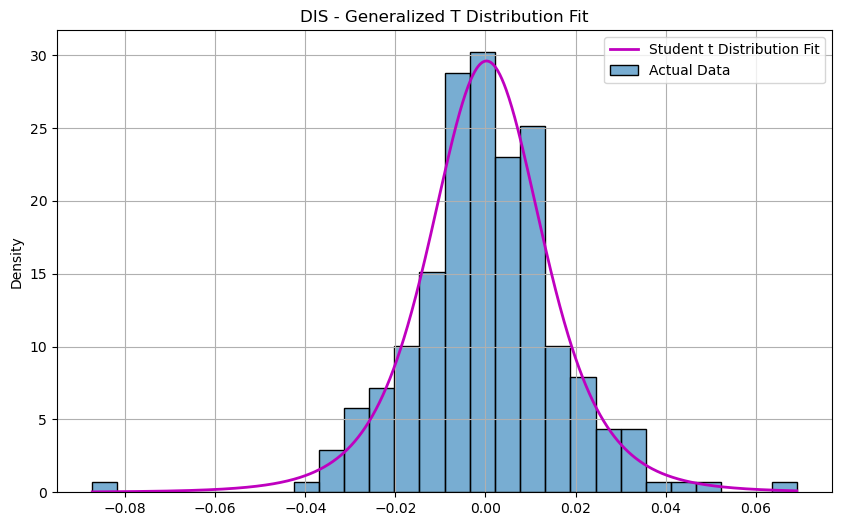


AIC Values for AXP:
  Normal: -1336.3372
  Generalized T: -1367.1578
  Normal Inverse Gaussian: -1364.0760
  Skew Normal: -1339.4951

Best Fit Distribution - AXP: Generalized T
  df: 4.718568
  loc: 0.001235
  scale: 0.012305


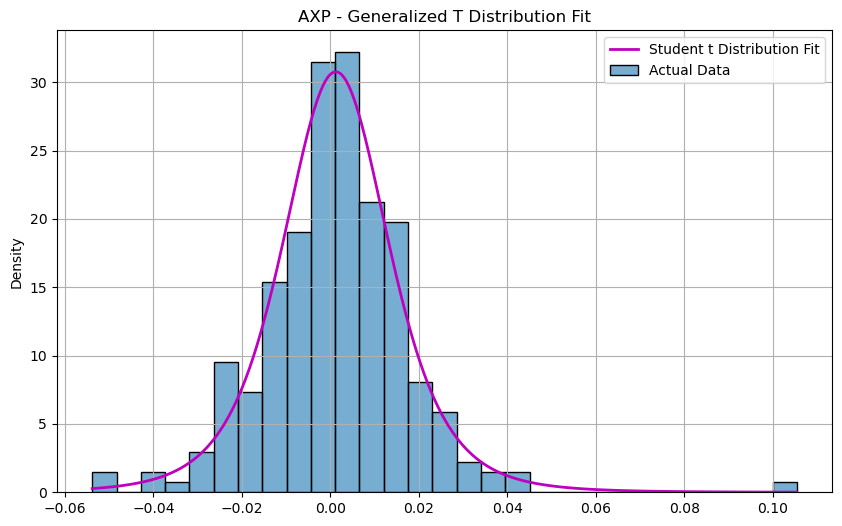


AIC Values for HON:
  Normal: -1511.7071
  Generalized T: -1526.5872
  Normal Inverse Gaussian: -1525.7565
  Skew Normal: -1513.9011

Best Fit Distribution - HON: Generalized T
  df: 5.729086
  loc: 0.000380
  scale: 0.009301


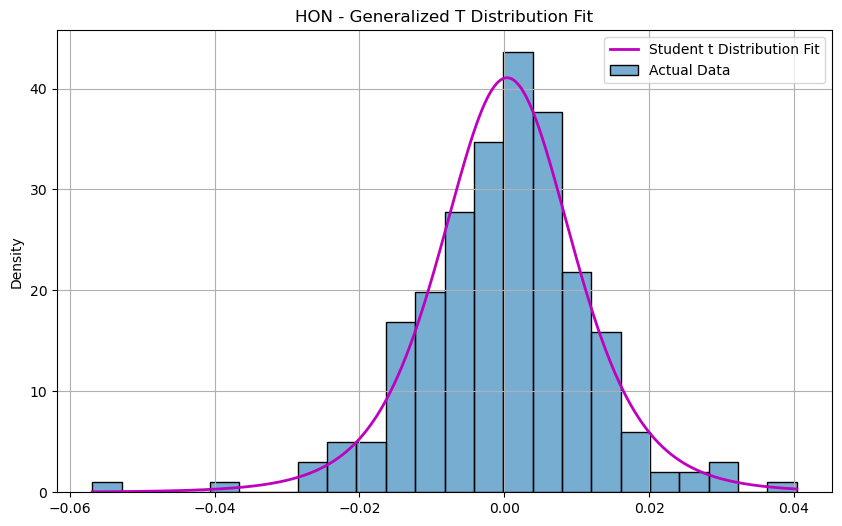


AIC Values for META:
  Normal: -1125.6460
  Generalized T: -1232.5420
  Normal Inverse Gaussian: -1228.0684
  Skew Normal: -1179.0889

Best Fit Distribution - META: Generalized T
  df: 4.219604
  loc: 0.002767
  scale: 0.015692


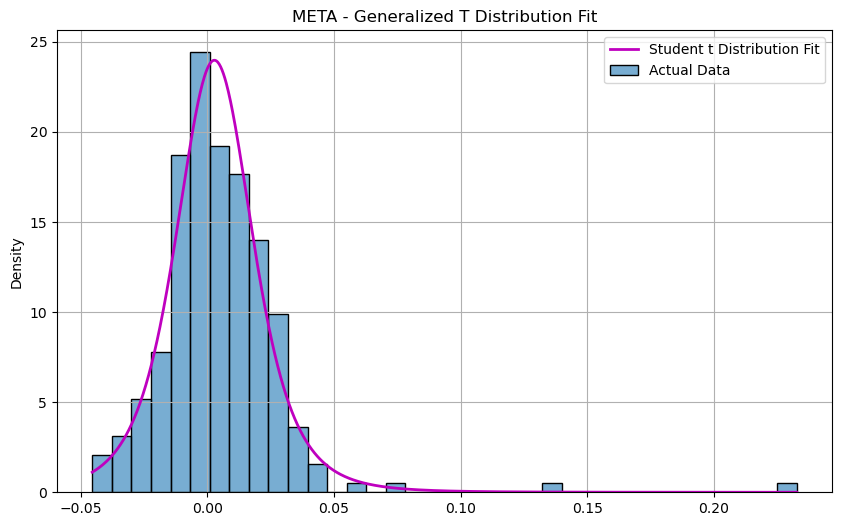


AIC Values for NFLX:
  Normal: -1154.5108
  Generalized T: -1213.5910
  Normal Inverse Gaussian: -1211.2650
  Skew Normal: -1174.3500

Best Fit Distribution - NFLX: Generalized T
  df: 3.644841
  loc: 0.000912
  scale: 0.015648


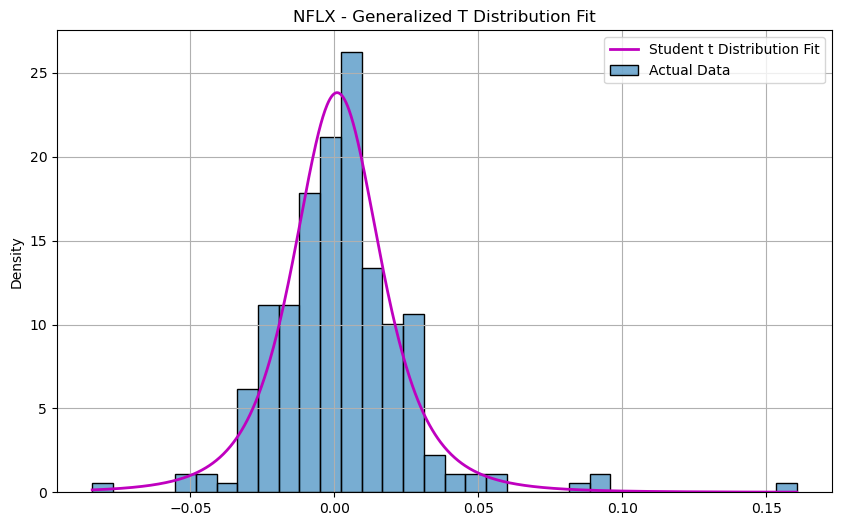


AIC Values for PGR:
  Normal: -1268.3049
  Generalized T: -1382.5968
  Normal Inverse Gaussian: -1375.4069
  Skew Normal: -1272.4854

Best Fit Distribution - PGR: Generalized T
  df: 2.646767
  loc: 0.001247
  scale: 0.009939


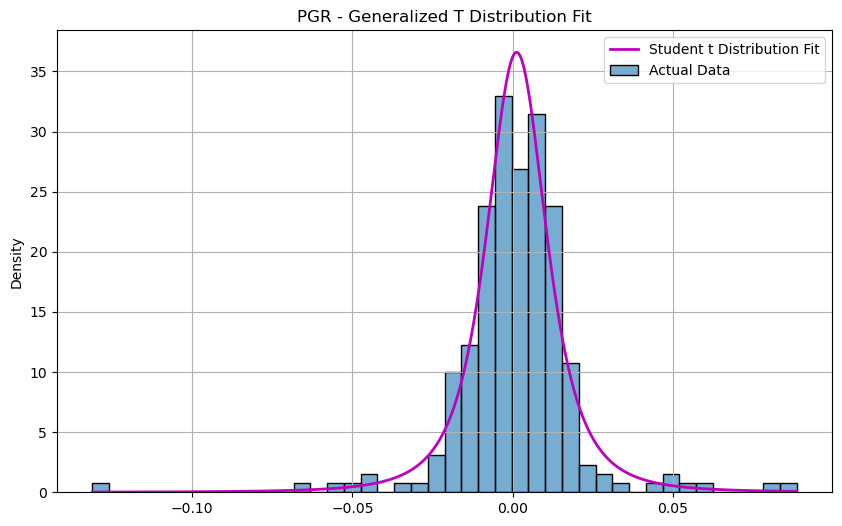


AIC Values for LLY:
  Normal: -1285.5128
  Generalized T: -1359.9131
  Normal Inverse Gaussian: -1356.4087
  Skew Normal: -1307.6562

Best Fit Distribution - LLY: Generalized T
  df: 3.233588
  loc: 0.001656
  scale: 0.011225


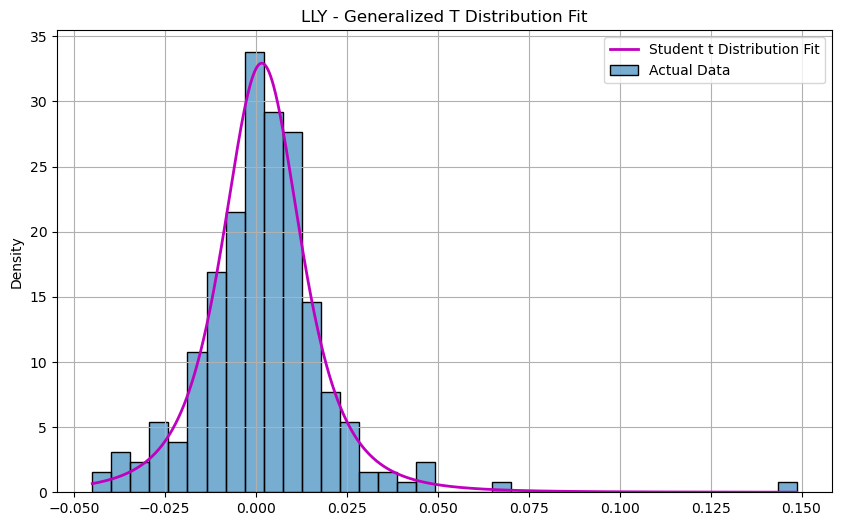


AIC Values for JPM:
  Normal: -1449.7220
  Generalized T: -1492.3959
  Normal Inverse Gaussian: -1491.4797
  Skew Normal: -1448.4231

Best Fit Distribution - JPM: Generalized T
  df: 3.518807
  loc: 0.001595
  scale: 0.008844


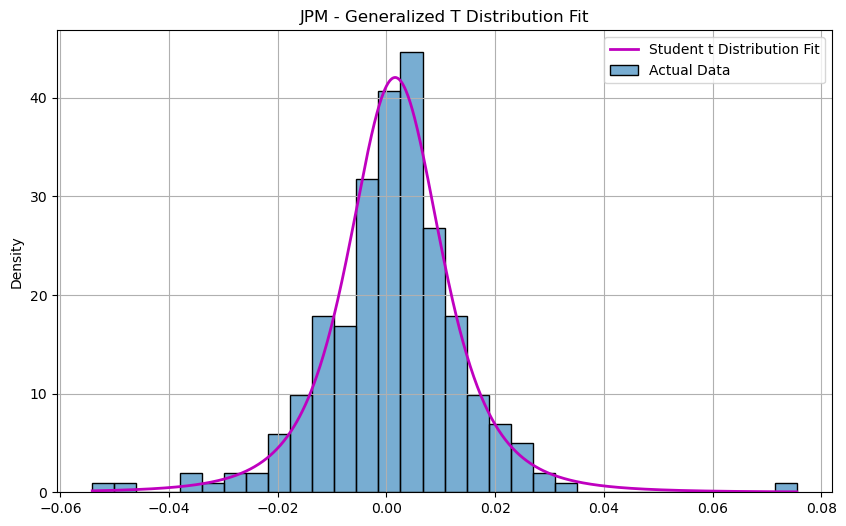


AIC Values for VRTX:
  Normal: -1355.9583
  Generalized T: -1429.6126
  Normal Inverse Gaussian: -1423.0043
  Skew Normal: -1370.7195

Best Fit Distribution - VRTX: Generalized T
  df: 4.006971
  loc: 0.001379
  scale: 0.010420


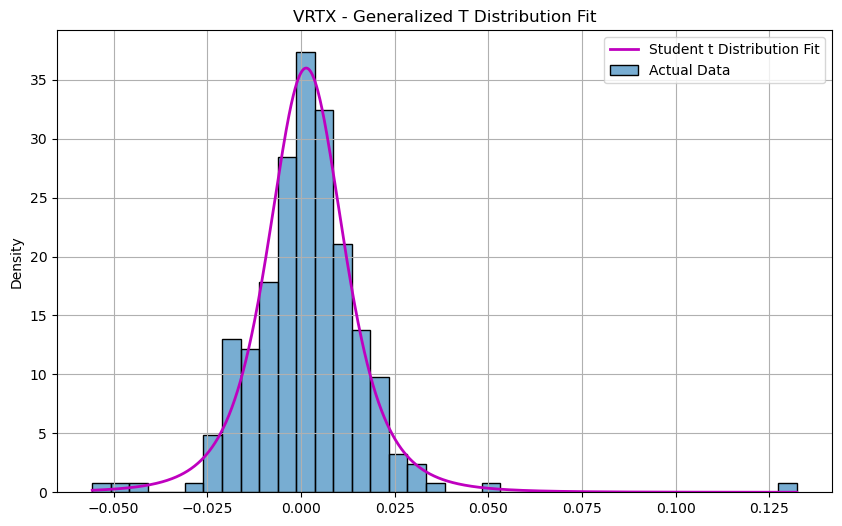


AIC Values for TJX:
  Normal: -1579.2690
  Generalized T: -1582.0694
  Normal Inverse Gaussian: -1579.8592
  Skew Normal: -1577.4431

Best Fit Distribution - TJX: Generalized T
  df: 10.191802
  loc: 0.000808
  scale: 0.009021


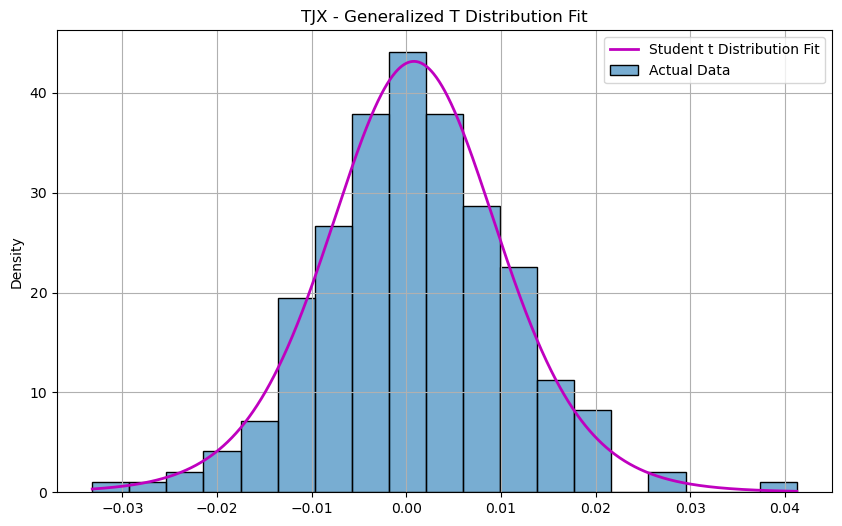


AIC Values for EQIX:
  Normal: -1373.2407
  Generalized T: -1383.3625
  Normal Inverse Gaussian: -1382.4692
  Skew Normal: -1372.0191

Best Fit Distribution - EQIX: Generalized T
  df: 5.295939
  loc: 0.001166
  scale: 0.012212


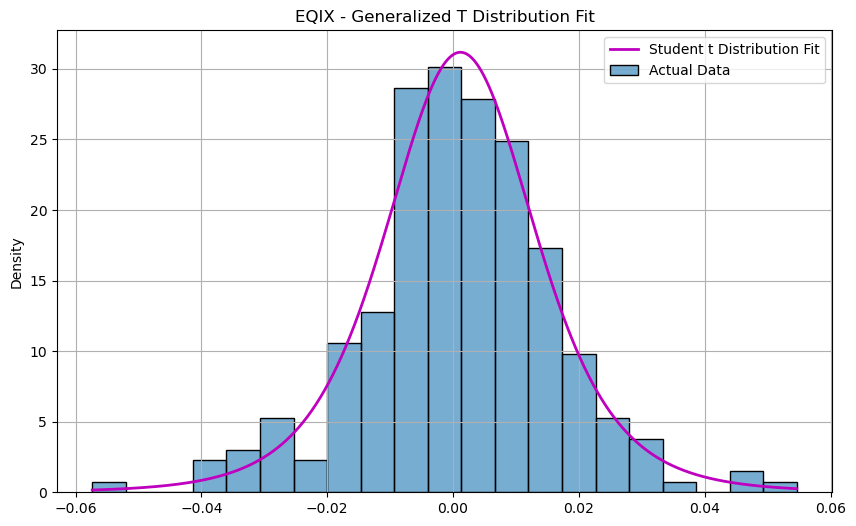


AIC Values for AAPL:
  Normal: -1469.8367
  Generalized T: -1476.9263
  Normal Inverse Gaussian: -1474.7227
  Skew Normal: -1468.0621

Best Fit Distribution - AAPL: Generalized T
  df: 7.327052
  loc: 0.001760
  scale: 0.010701


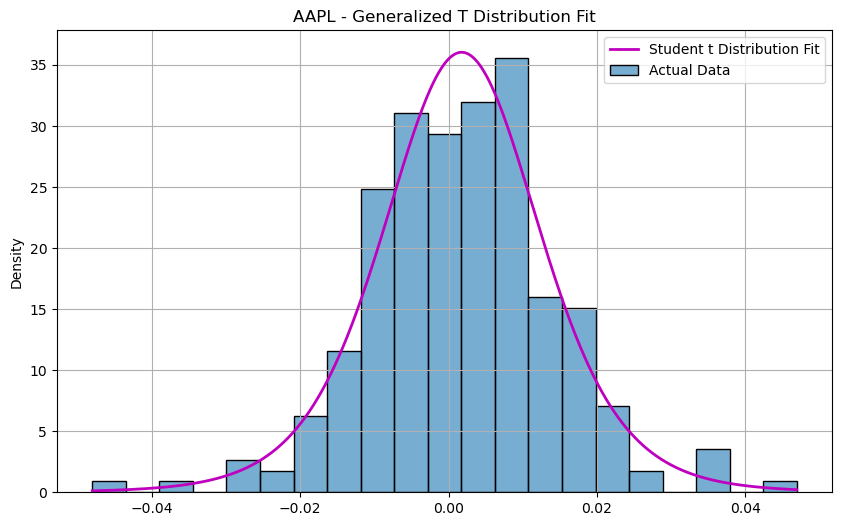


AIC Values for FI:
  Normal: -1435.2395
  Generalized T: -1500.1683
  Normal Inverse Gaussian: -1493.8092
  Skew Normal: -1441.3120

Best Fit Distribution - FI: Generalized T
  df: 3.721628
  loc: 0.000939
  scale: 0.008856


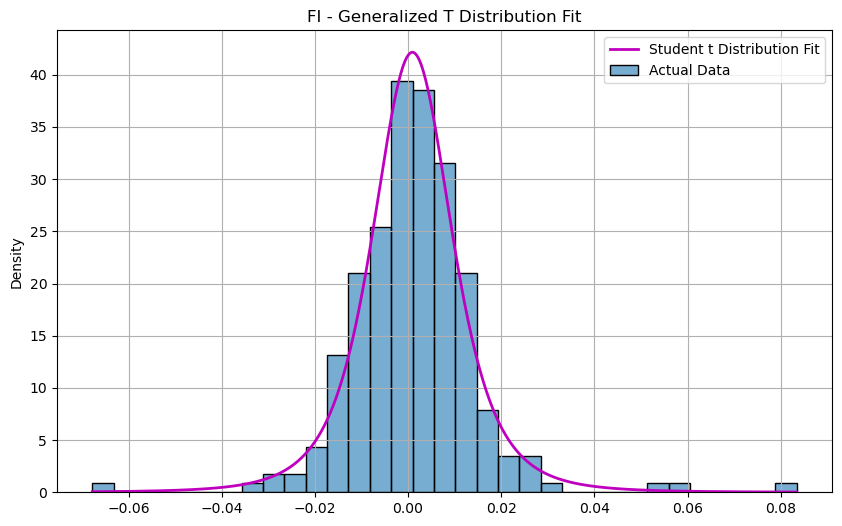


AIC Values for DE:
  Normal: -1315.8393
  Generalized T: -1331.7323
  Normal Inverse Gaussian: -1329.7247
  Skew Normal: -1315.1715

Best Fit Distribution - DE: Generalized T
  df: 5.600724
  loc: 0.000342
  scale: 0.013696


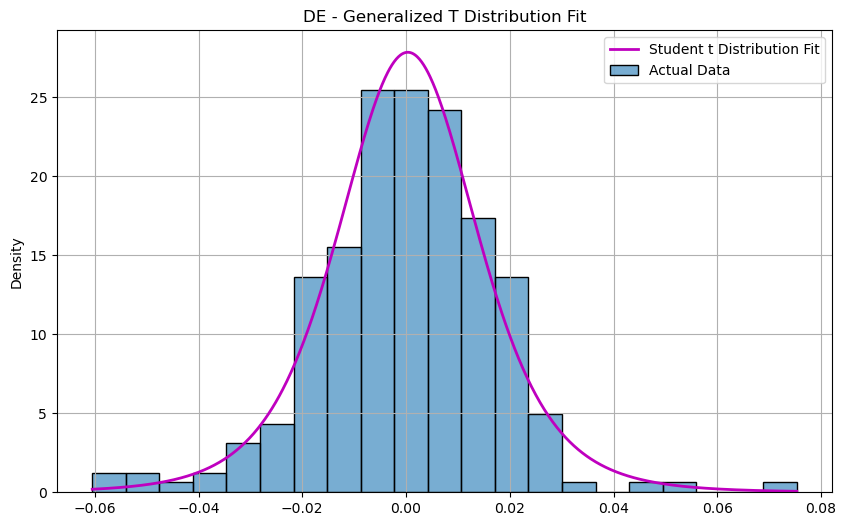


AIC Values for SBUX:
  Normal: -1406.8858
  Generalized T: -1475.6237
  Normal Inverse Gaussian: -1468.0297
  Skew Normal: -1406.4075

Best Fit Distribution - SBUX: Generalized T
  df: 4.189386
  loc: -0.000008
  scale: 0.009614


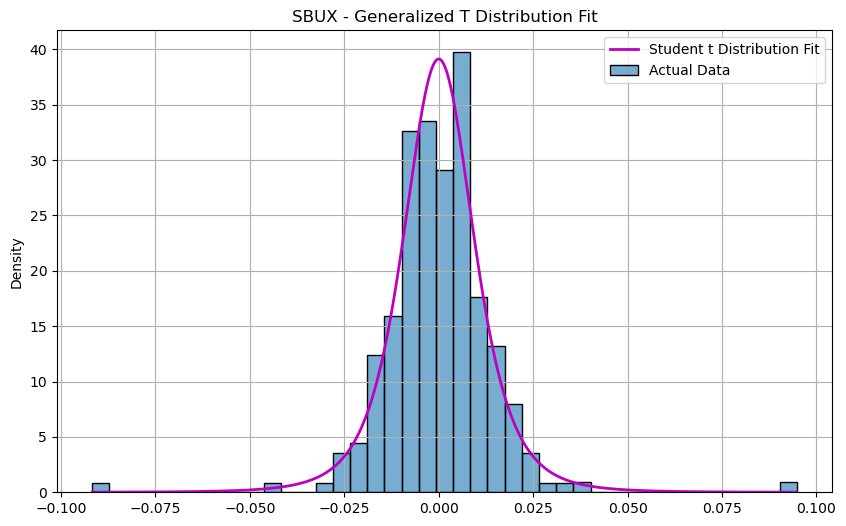


AIC Values for GOOGL:
  Normal: -1260.2108
  Generalized T: -1288.6210
  Normal Inverse Gaussian: -1285.6961
  Skew Normal: -1260.0459

Best Fit Distribution - GOOGL: Generalized T
  df: 4.420043
  loc: 0.001738
  scale: 0.014185


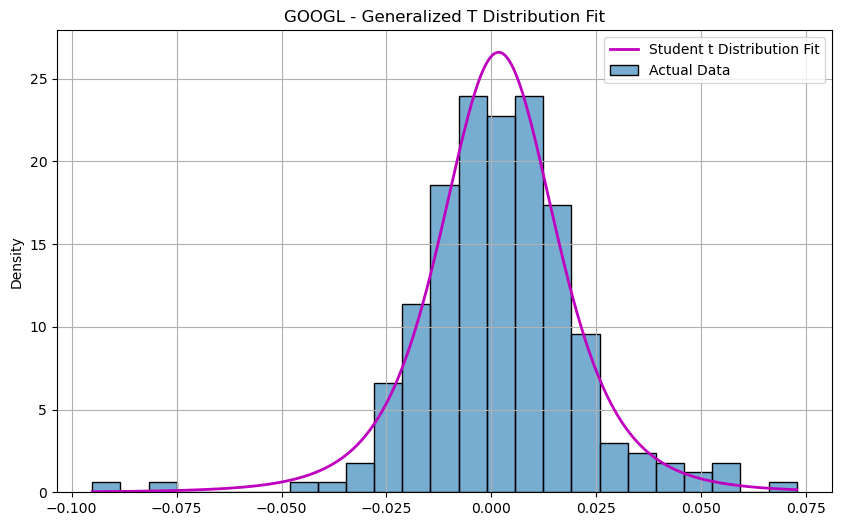


AIC Values for T:
  Normal: -1318.7017
  Generalized T: -1403.5698
  Normal Inverse Gaussian: -1397.0284
  Skew Normal: -1319.3714

Best Fit Distribution - T: Generalized T
  df: 3.021498
  loc: 0.000063
  scale: 0.010039


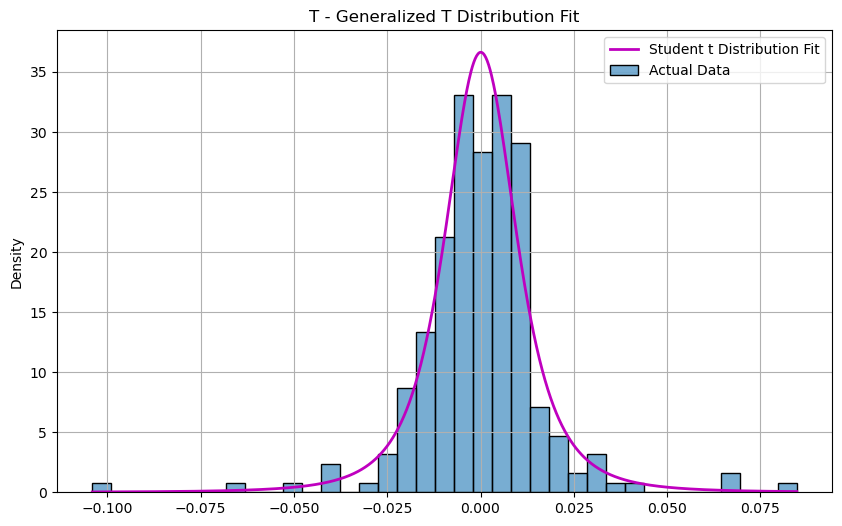


AIC Values for ABT:
  Normal: -1472.0641
  Generalized T: -1500.4155
  Normal Inverse Gaussian: -1495.5012
  Skew Normal: -1478.1490

Best Fit Distribution - ABT: Generalized T
  df: 6.227416
  loc: -0.000066
  scale: 0.009950


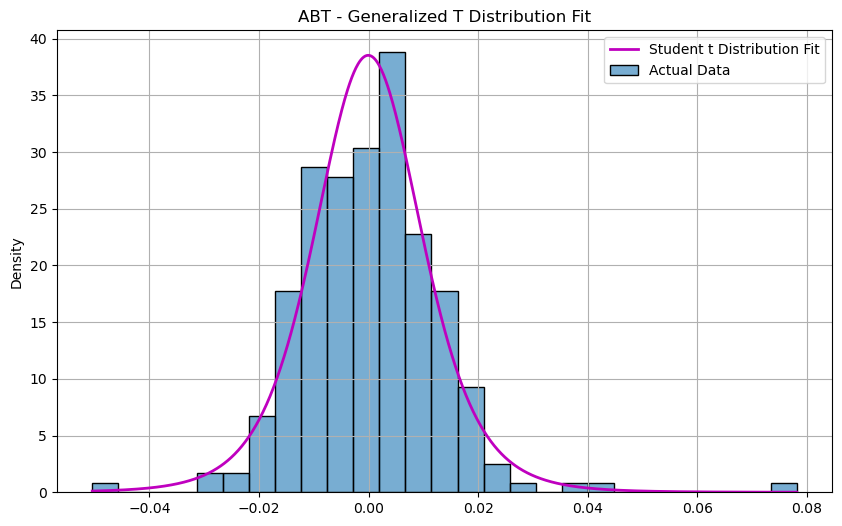


AIC Values for BMY:
  Normal: -1484.9501
  Generalized T: -1510.0344
  Normal Inverse Gaussian: -1507.7899
  Skew Normal: -1491.4237

Best Fit Distribution - BMY: Generalized T
  df: 4.359799
  loc: -0.000956
  scale: 0.009063


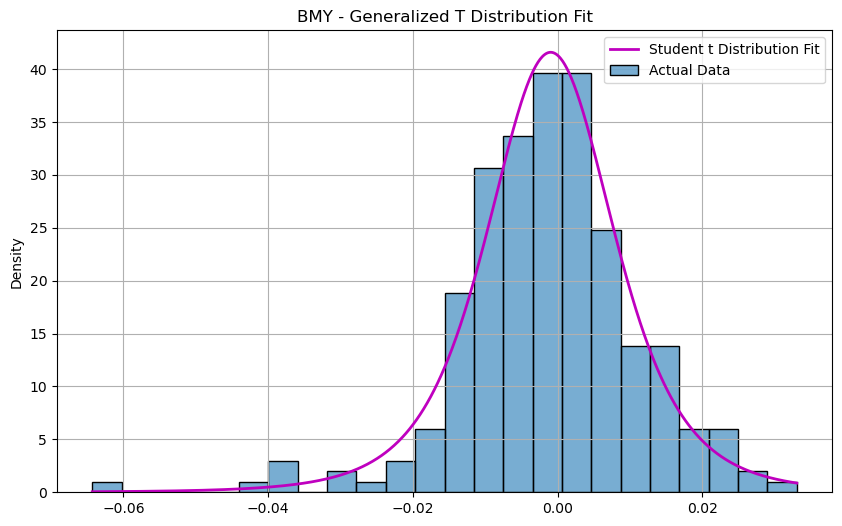


AIC Values for MS:
  Normal: -1339.5790
  Generalized T: -1362.6075
  Normal Inverse Gaussian: -1360.5695
  Skew Normal: -1339.9764

Best Fit Distribution - MS: Generalized T
  df: 4.494360
  loc: 0.000381
  scale: 0.012277


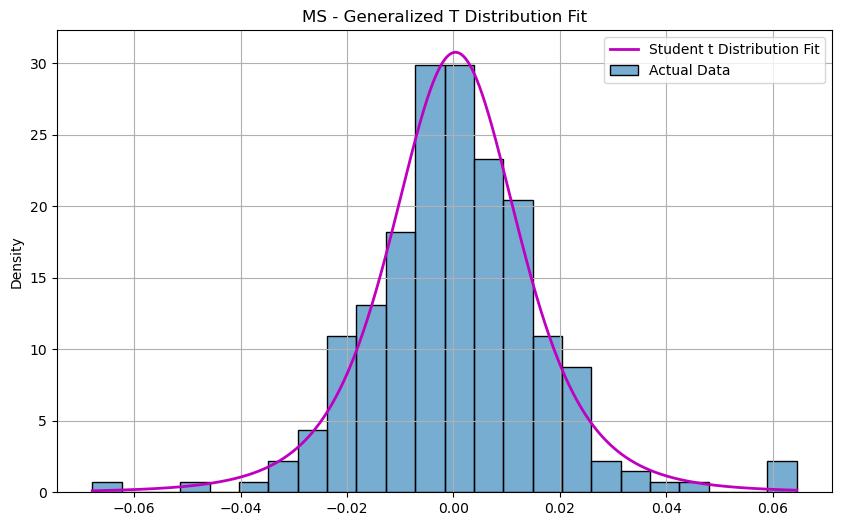


AIC Values for CRM:
  Normal: -1273.3697
  Generalized T: -1307.1806
  Normal Inverse Gaussian: -1305.6569
  Skew Normal: -1290.1002

Best Fit Distribution - CRM: Generalized T
  df: 5.107223
  loc: 0.002003
  scale: 0.014124


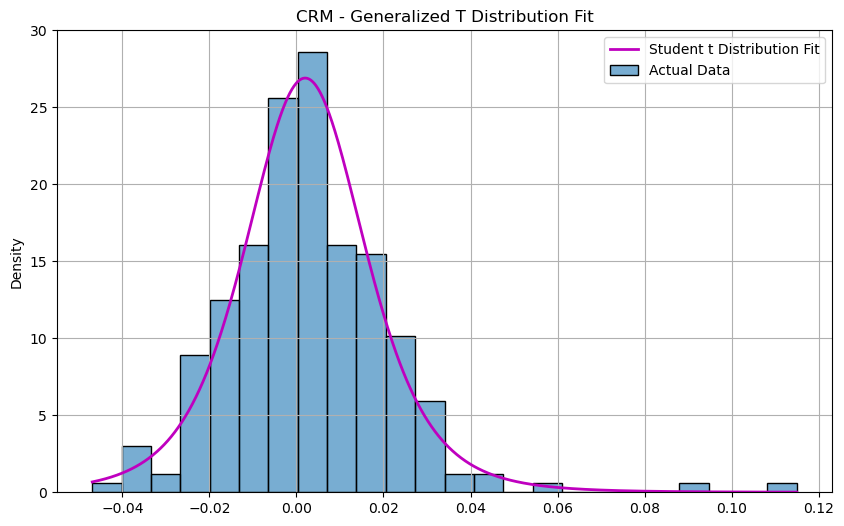


AIC Values for PFE:
  Normal: -1398.7657
  Generalized T: -1425.2011
  Normal Inverse Gaussian: -1422.9598
  Skew Normal: -1399.0938

Best Fit Distribution - PFE: Generalized T
  df: 4.092583
  loc: -0.001927
  scale: 0.010573


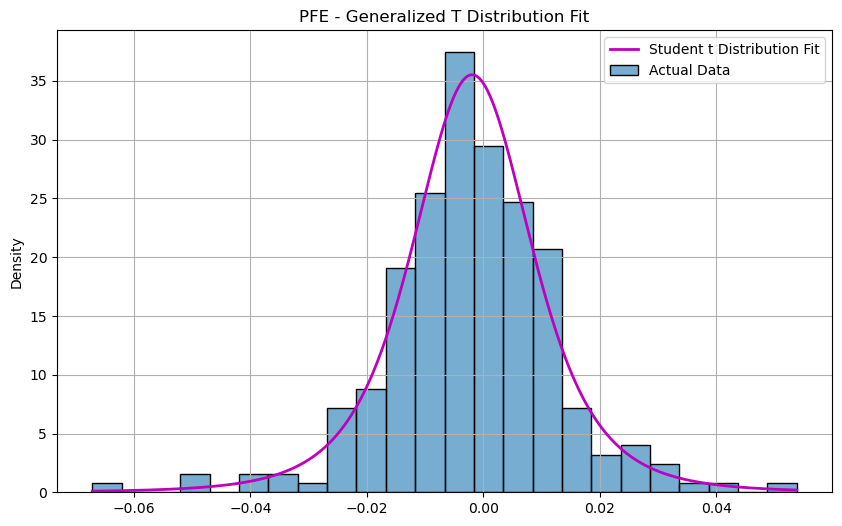


AIC Values for SPGI:
  Normal: -1420.7728
  Generalized T: -1458.8754
  Normal Inverse Gaussian: -1457.0993
  Skew Normal: -1422.3359

Best Fit Distribution - SPGI: Generalized T
  df: 4.164963
  loc: 0.001732
  scale: 0.009927


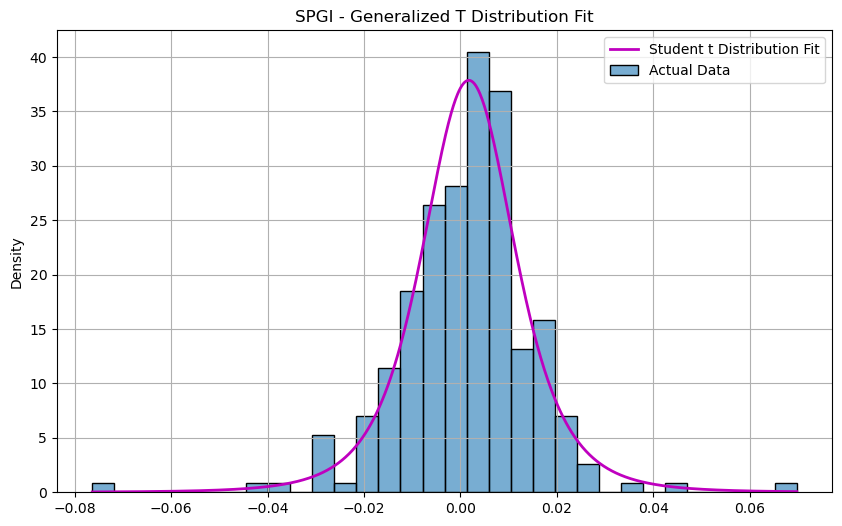


AIC Values for BRK-B:
  Normal: -1658.2939
  Generalized T: -1665.2640
  Normal Inverse Gaussian: -1663.6167
  Skew Normal: -1656.5668

Best Fit Distribution - BRK-B: Generalized T
  df: 6.745247
  loc: 0.000674
  scale: 0.007241


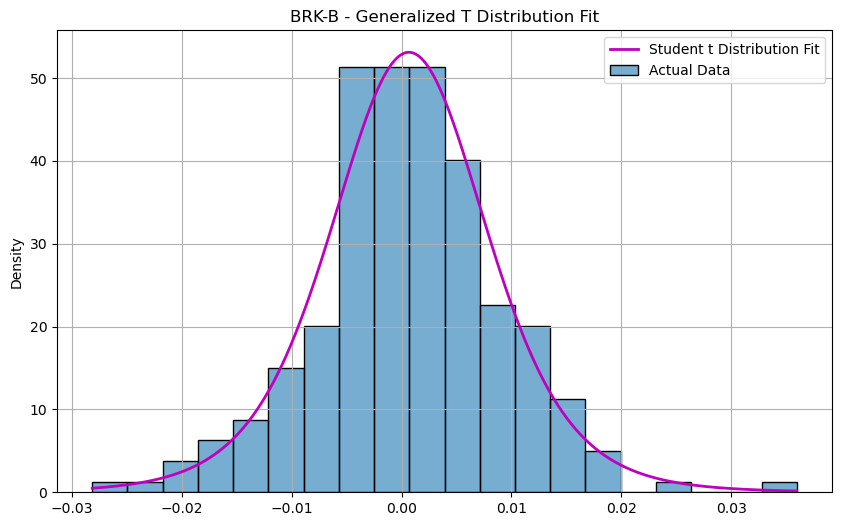


AIC Values for ADBE:
  Normal: -1237.0535
  Generalized T: -1247.8038
  Normal Inverse Gaussian: -1245.8540
  Skew Normal: -1236.5095

Best Fit Distribution - ADBE: Generalized T
  df: 5.878008
  loc: 0.002569
  scale: 0.016357


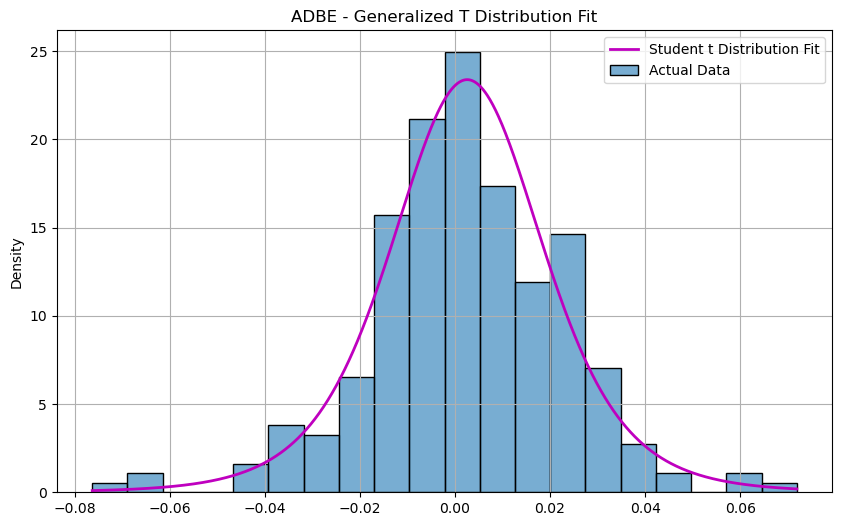


AIC Values for ACN:
  Normal: -1424.9629
  Generalized T: -1436.7430
  Normal Inverse Gaussian: -1433.9920
  Skew Normal: -1425.2015

Best Fit Distribution - ACN: Generalized T
  df: 6.972202
  loc: 0.001241
  scale: 0.011516


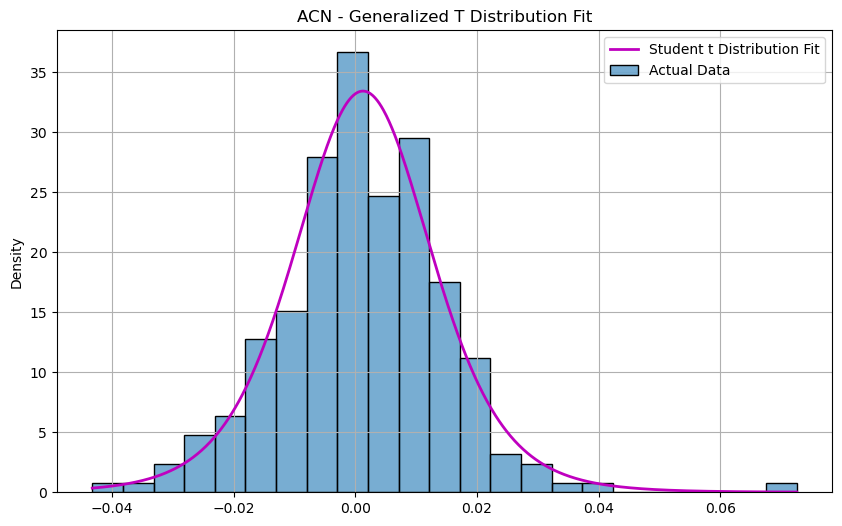


AIC Values for AMGN:
  Normal: -1449.9799
  Generalized T: -1458.3092
  Normal Inverse Gaussian: -1461.1396
  Skew Normal: -1455.3903

Best Fit Distribution - AMGN: Normal Inverse Gaussian
  a: 1.681353
  b: 0.440252
  loc: -0.003787
  scale: 0.016196


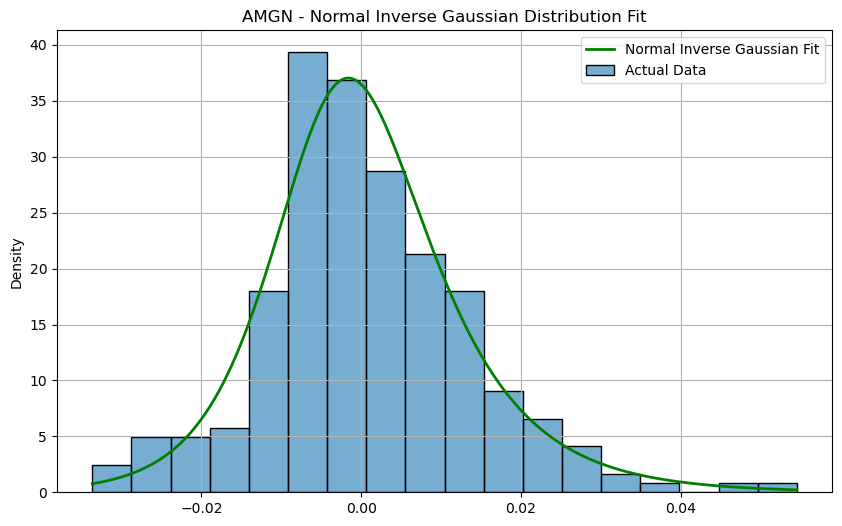


AIC Values for LIN:
  Normal: -1474.8541
  Generalized T: -1507.0656
  Normal Inverse Gaussian: -1506.7108
  Skew Normal: -1473.4297

Best Fit Distribution - LIN: Generalized T
  df: 3.172834
  loc: 0.001352
  scale: 0.008299


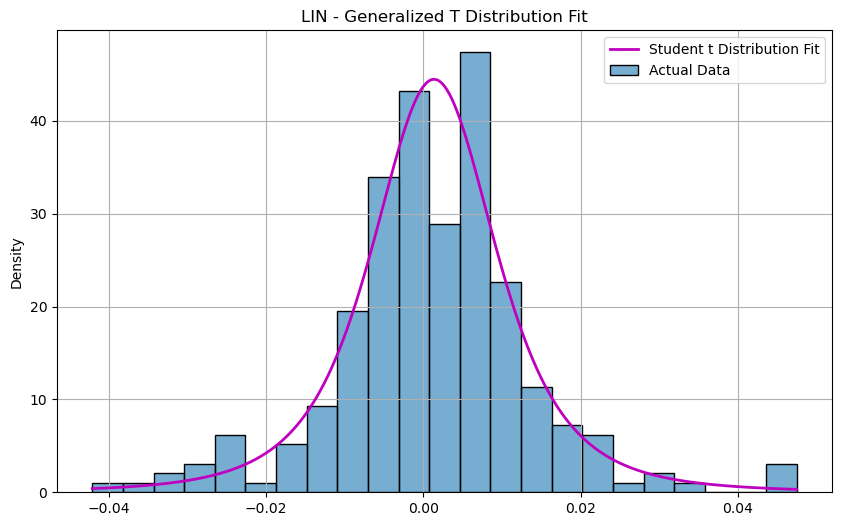


AIC Values for V:
  Normal: -1592.9731
  Generalized T: -1594.6753
  Normal Inverse Gaussian: -1592.9269
  Skew Normal: -1591.5323

Best Fit Distribution - V: Generalized T
  df: 9.519657
  loc: 0.000959
  scale: 0.008732


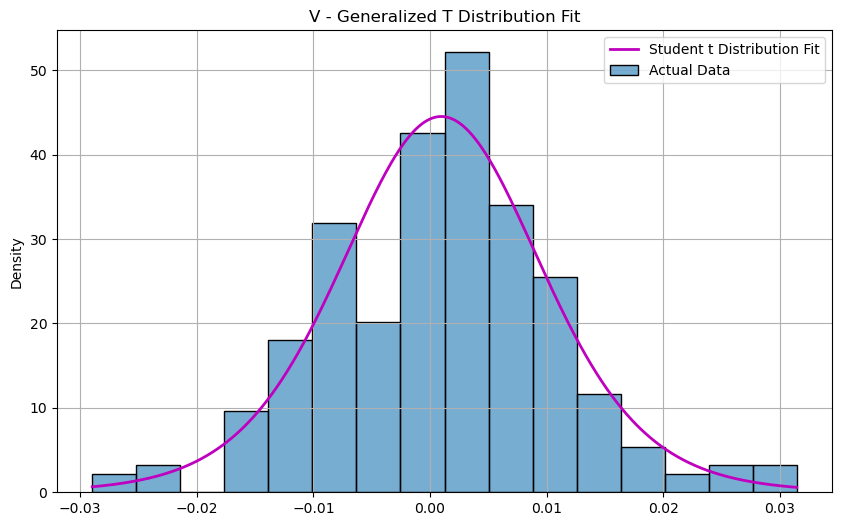


AIC Values for WMT:
  Normal: -1591.5977
  Generalized T: -1643.4735
  Normal Inverse Gaussian: -1641.2874
  Skew Normal: -1621.7107

Best Fit Distribution - WMT: Generalized T
  df: 6.045067
  loc: 0.000967
  scale: 0.007427


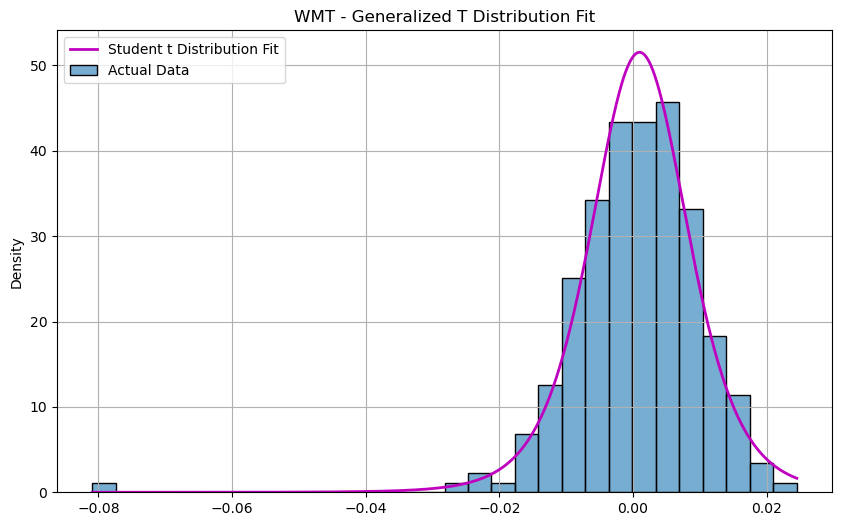


AIC Values for AMAT:
  Normal: -1205.9905
  Generalized T: -1206.6705
  Normal Inverse Gaussian: -1207.4432
  Skew Normal: -1207.8378

Best Fit Distribution - AMAT: Skew Normal
  shape: 1.405420
  loc: -0.015821
  scale: 0.027996


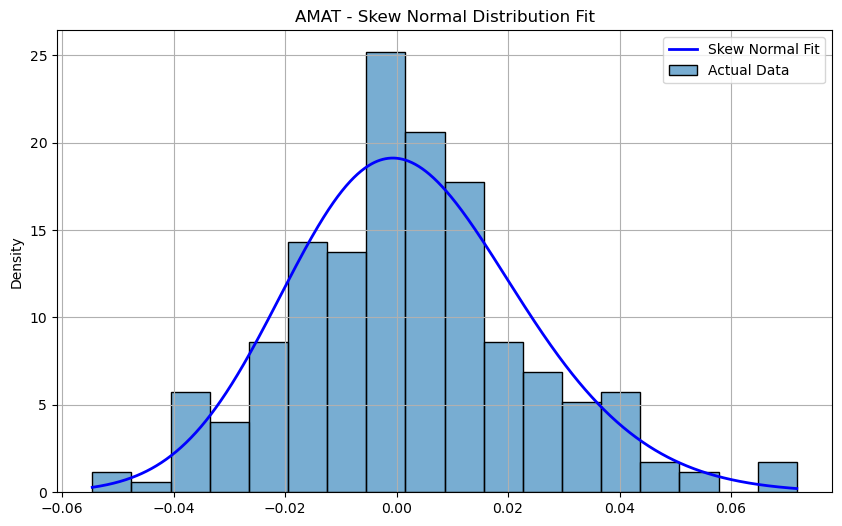


AIC Values for CAT:
  Normal: -1289.4334
  Generalized T: -1325.1094
  Normal Inverse Gaussian: -1320.4145
  Skew Normal: -1291.7430

Best Fit Distribution - CAT: Generalized T
  df: 4.450136
  loc: 0.000915
  scale: 0.013205


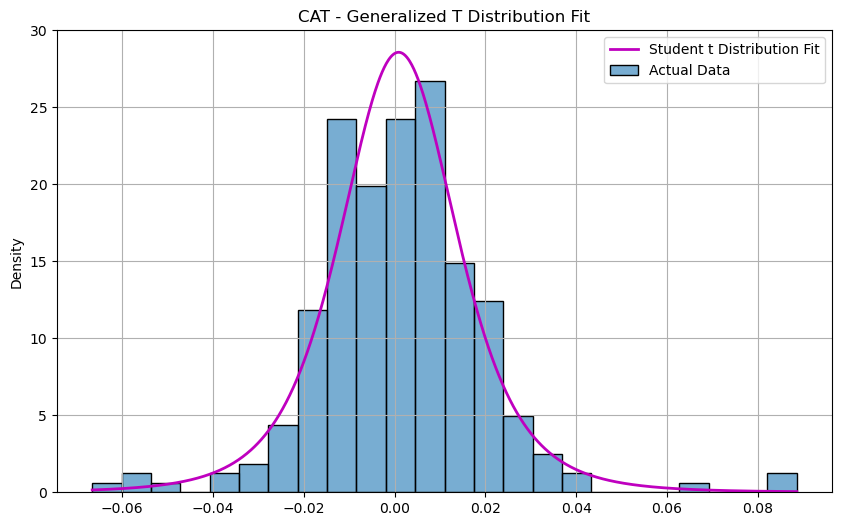


AIC Values for RTX:
  Normal: -1380.7944
  Generalized T: -1463.3025
  Normal Inverse Gaussian: -1457.7629
  Skew Normal: -1388.9548

Best Fit Distribution - RTX: Generalized T
  df: 3.208686
  loc: -0.000353
  scale: 0.009096


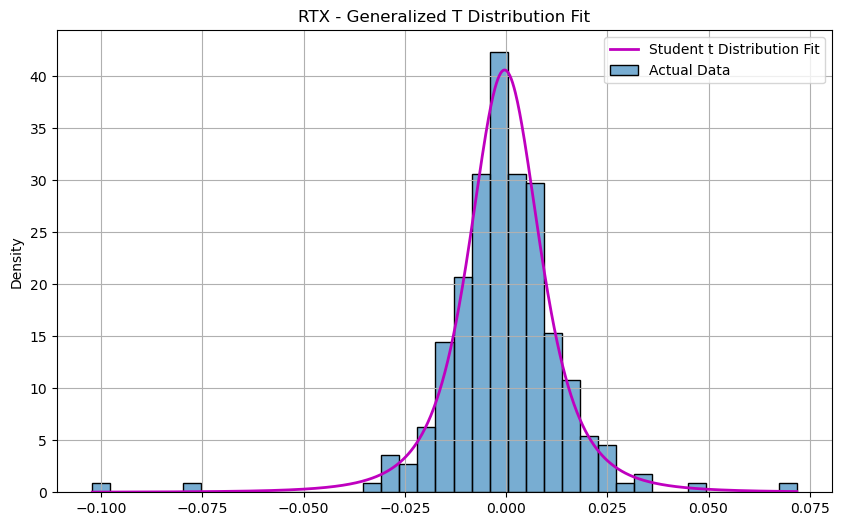


AIC Values for UNP:
  Normal: -1376.7109
  Generalized T: -1452.5710
  Normal Inverse Gaussian: -1446.0765
  Skew Normal: -1406.4492

Best Fit Distribution - UNP: Generalized T
  df: 3.985263
  loc: 0.000312
  scale: 0.009936


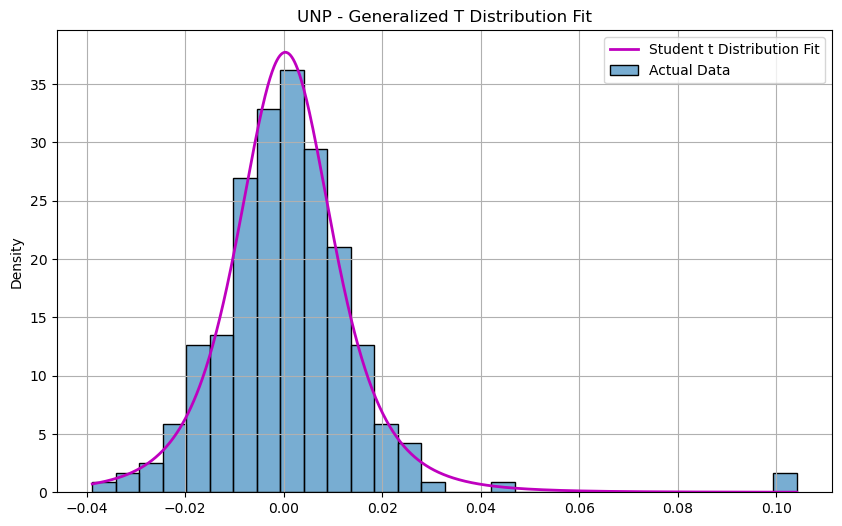


AIC Values for IBM:
  Normal: -1585.9584
  Generalized T: -1610.0899
  Normal Inverse Gaussian: -1607.7885
  Skew Normal: -1585.0890

Best Fit Distribution - IBM: Generalized T
  df: 4.815192
  loc: 0.001015
  scale: 0.007590


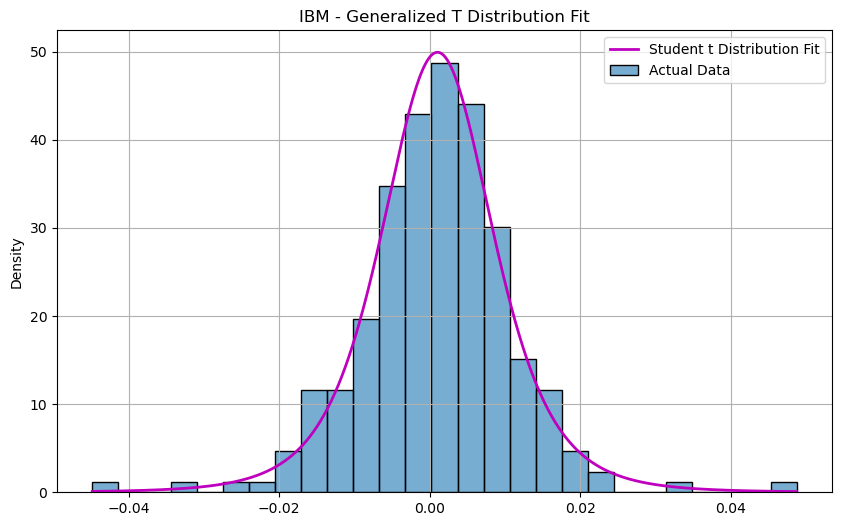


AIC Values for TXN:
  Normal: -1377.7762
  Generalized T: -1380.5787
  Normal Inverse Gaussian: -1379.3572
  Skew Normal: -1376.7912

Best Fit Distribution - TXN: Generalized T
  df: 9.150955
  loc: 0.000218
  scale: 0.013363


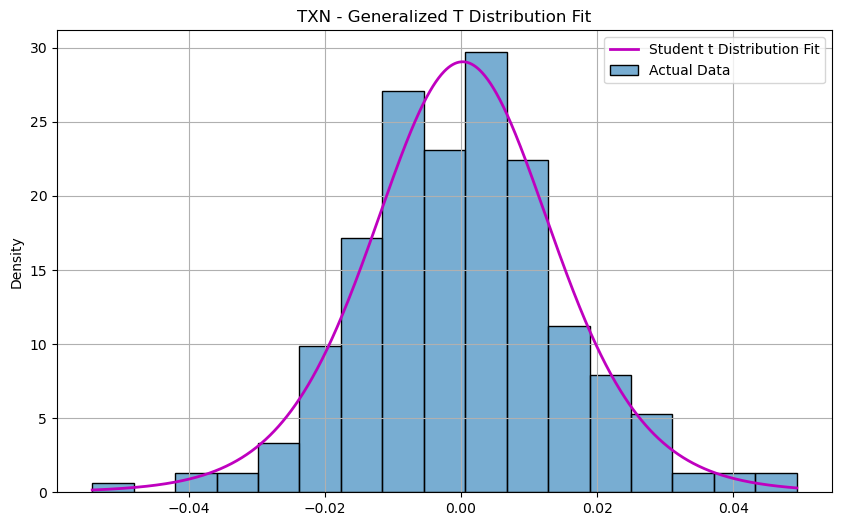


AIC Values for ADP:
  Normal: -1444.8362
  Generalized T: -1505.2253
  Normal Inverse Gaussian: -1502.4057
  Skew Normal: -1456.4587

Best Fit Distribution - ADP: Generalized T
  df: 3.390267
  loc: 0.000575
  scale: 0.008517


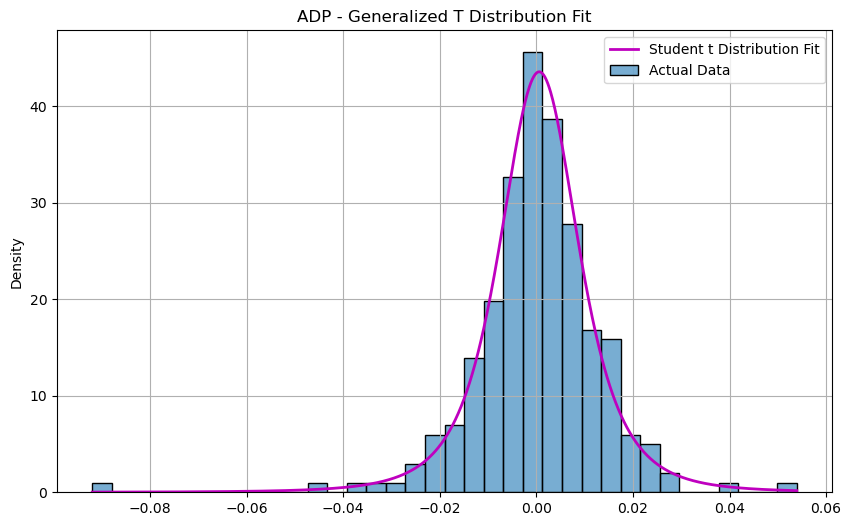


AIC Values for GOOG:
  Normal: -1256.7322
  Generalized T: -1283.0645
  Normal Inverse Gaussian: -1280.0444
  Skew Normal: -1256.6783

Best Fit Distribution - GOOG: Generalized T
  df: 4.593603
  loc: 0.001824
  scale: 0.014478


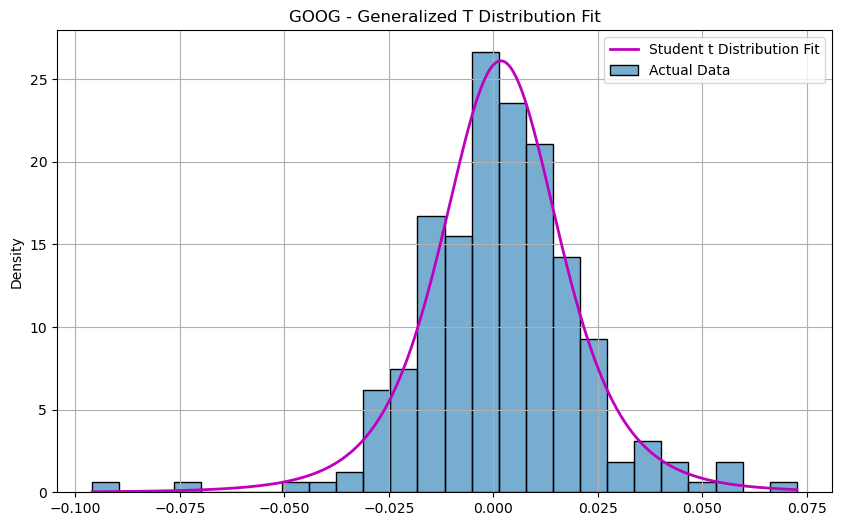


AIC Values for ORCL:
  Normal: -1263.9456
  Generalized T: -1369.4416
  Normal Inverse Gaussian: -1364.0966
  Skew Normal: -1294.4483

Best Fit Distribution - ORCL: Generalized T
  df: 3.081850
  loc: 0.002129
  scale: 0.010828


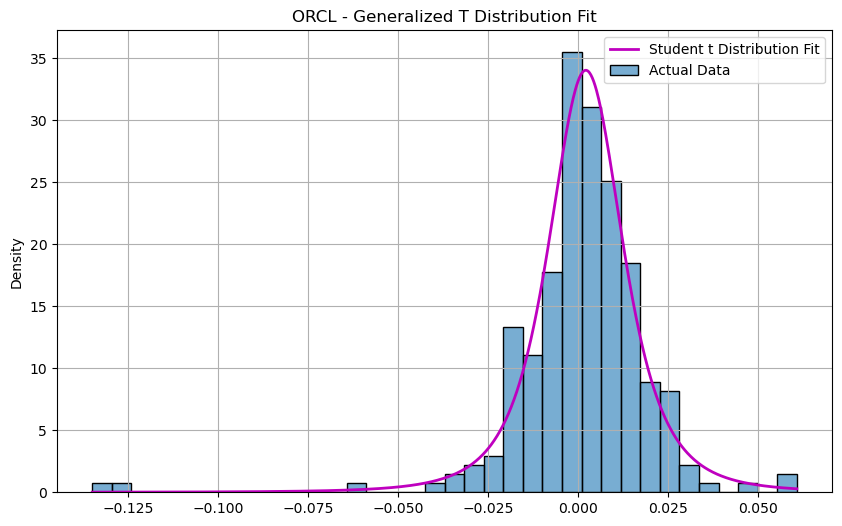


AIC Values for BSX:
  Normal: -1467.2417
  Generalized T: -1504.2783
  Normal Inverse Gaussian: -1502.3296
  Skew Normal: -1465.9837

Best Fit Distribution - BSX: Generalized T
  df: 3.540860
  loc: 0.001046
  scale: 0.008652


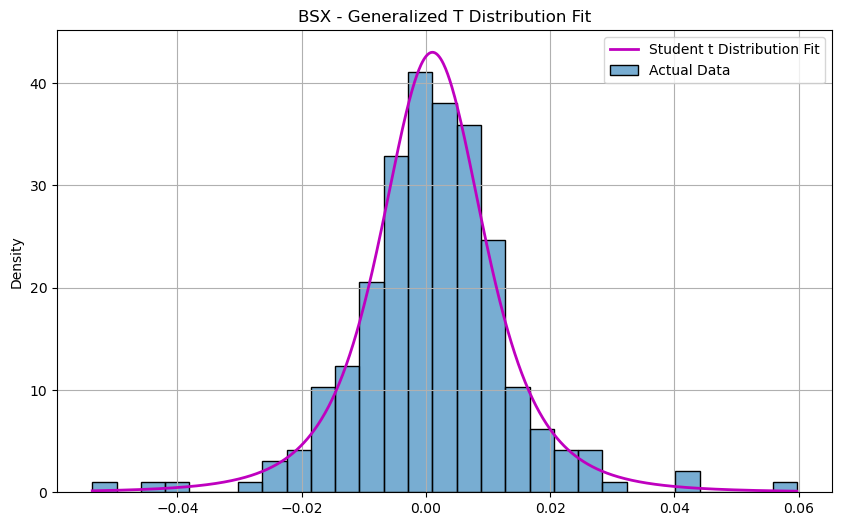


AIC Values for UNH:
  Normal: -1441.8739
  Generalized T: -1495.4633
  Normal Inverse Gaussian: -1491.5668
  Skew Normal: -1441.0828

Best Fit Distribution - UNH: Generalized T
  df: 3.371018
  loc: 0.000226
  scale: 0.008670


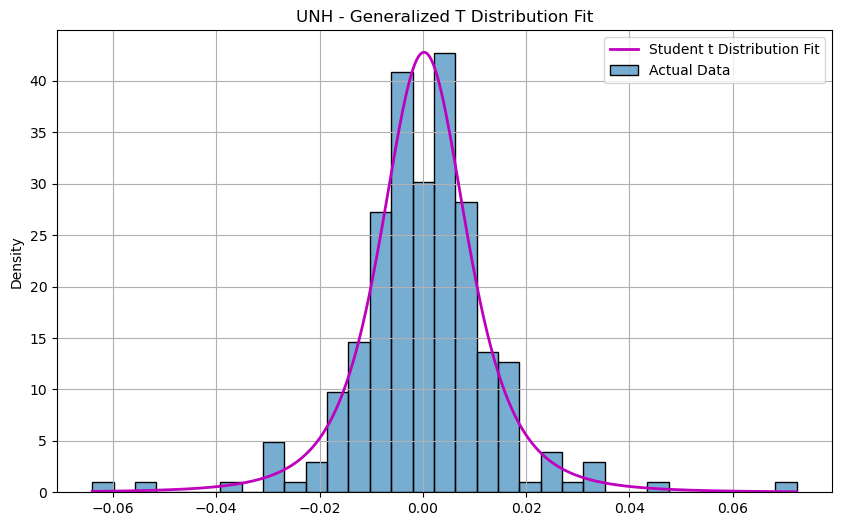


AIC Values for TMUS:
  Normal: -1498.3182
  Generalized T: -1511.6652
  Normal Inverse Gaussian: -1512.5322
  Skew Normal: -1503.5392

Best Fit Distribution - TMUS: Normal Inverse Gaussian
  a: 1.717771
  b: -0.380545
  loc: 0.004054
  scale: 0.014937


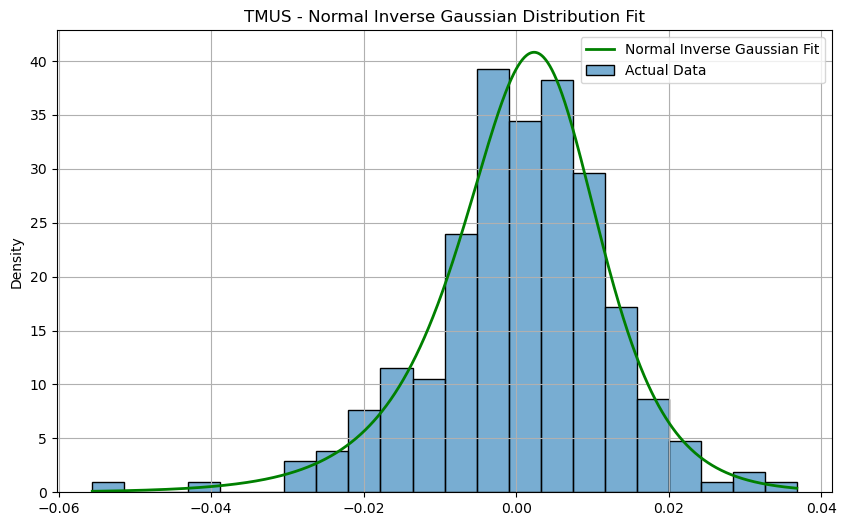


AIC Values for SYK:
  Normal: -1389.5808
  Generalized T: -1451.4338
  Normal Inverse Gaussian: -1451.6995
  Skew Normal: -1395.0013

Best Fit Distribution - SYK: Normal Inverse Gaussian
  a: 0.385581
  b: -0.018642
  loc: 0.001384
  scale: 0.009171


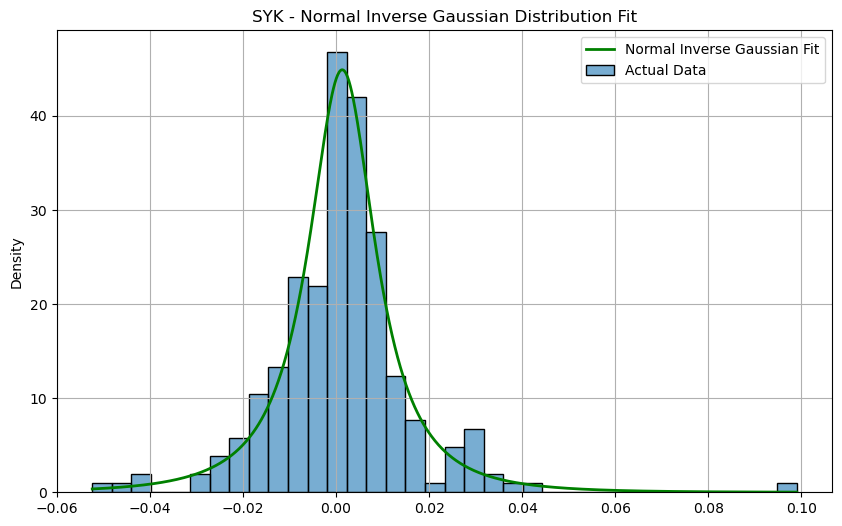


AIC Values for GS:
  Normal: -1375.2959
  Generalized T: -1387.5365
  Normal Inverse Gaussian: -1386.0409
  Skew Normal: -1374.9152

Best Fit Distribution - GS: Generalized T
  df: 5.505643
  loc: 0.000870
  scale: 0.012204


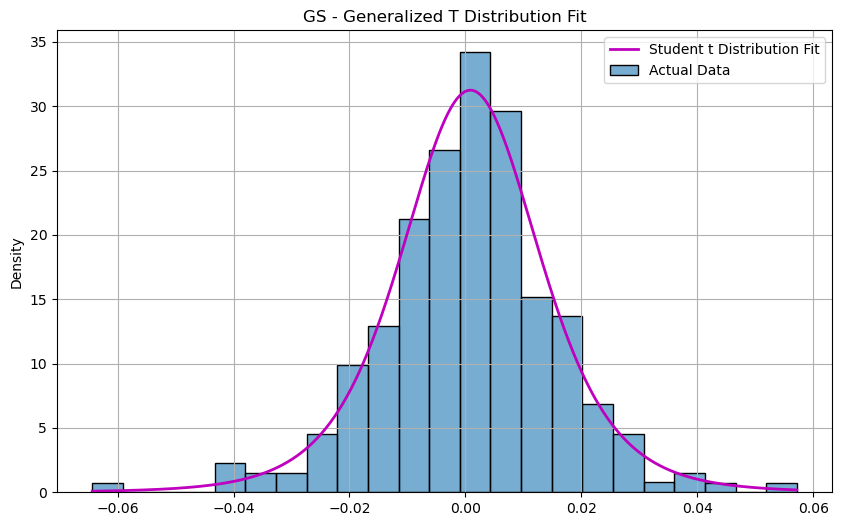


AIC Values for UBER:
  Normal: -1173.4052
  Generalized T: -1179.0636
  Normal Inverse Gaussian: -1177.0183
  Skew Normal: -1174.7148

Best Fit Distribution - UBER: Generalized T
  df: 9.440553
  loc: 0.003549
  scale: 0.020099


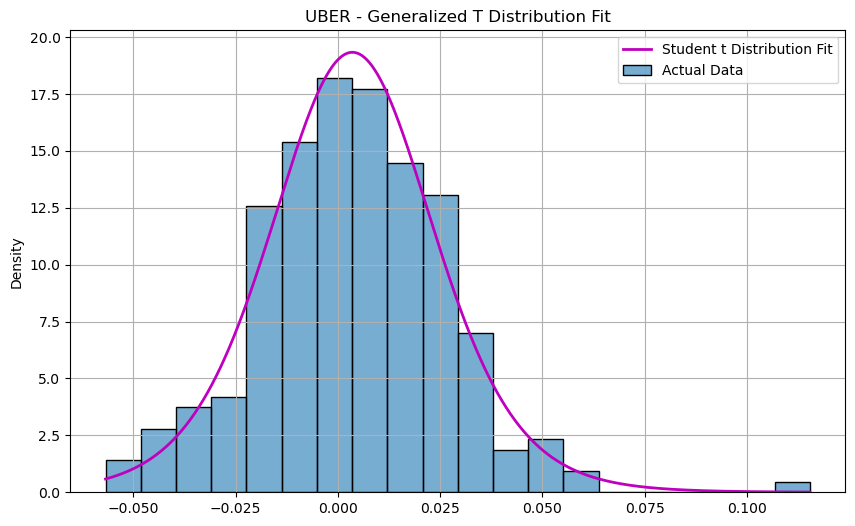


AIC Values for AVGO:
  Normal: -1232.0445
  Generalized T: -1267.4773
  Normal Inverse Gaussian: -1272.9940
  Skew Normal: -1256.9436

Best Fit Distribution - AVGO: Normal Inverse Gaussian
  a: 1.629564
  b: 0.664561
  loc: -0.006749
  scale: 0.022078


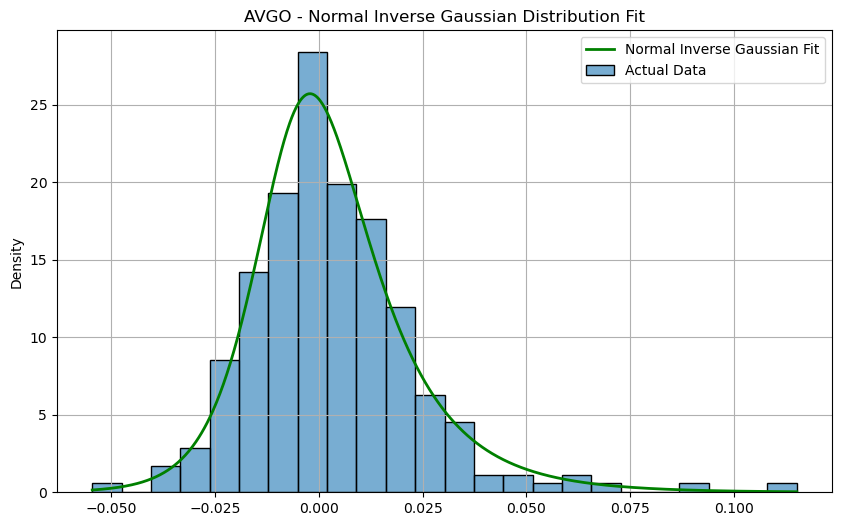


AIC Values for MMC:
  Normal: -1556.4393
  Generalized T: -1575.0405
  Normal Inverse Gaussian: -1576.0817
  Skew Normal: -1563.1771

Best Fit Distribution - MMC: Normal Inverse Gaussian
  a: 1.542412
  b: -0.379789
  loc: 0.003805
  scale: 0.012438


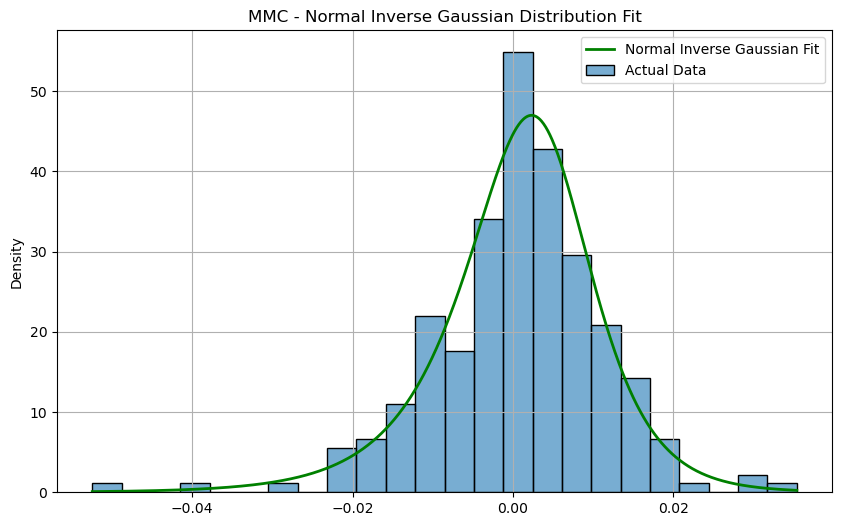


AIC Values for CSCO:
  Normal: -1459.1192
  Generalized T: -1528.5820
  Normal Inverse Gaussian: -1524.9925
  Skew Normal: -1478.7575

Best Fit Distribution - CSCO: Generalized T
  df: 3.894934
  loc: 0.001140
  scale: 0.008475


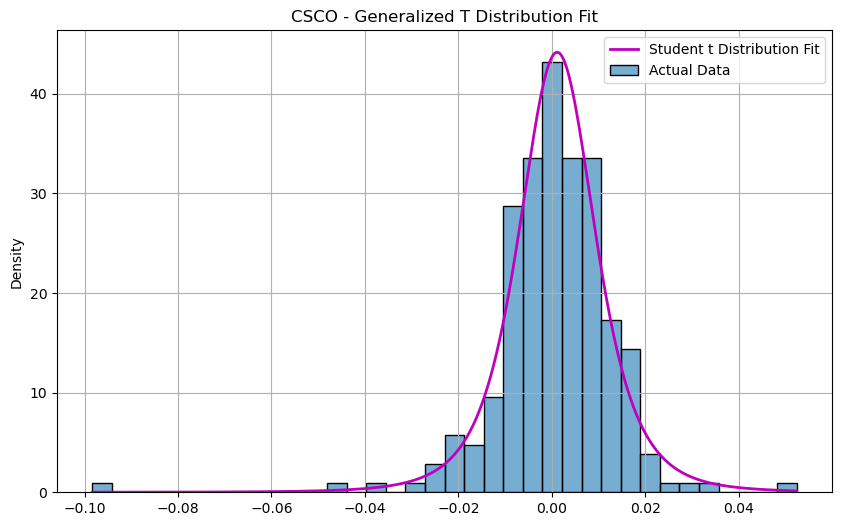


AIC Values for PLTR:
  Normal: -849.1894
  Generalized T: -901.2430
  Normal Inverse Gaussian: -904.3794
  Skew Normal: -873.1606

Best Fit Distribution - PLTR: Normal Inverse Gaussian
  a: 0.601040
  b: 0.163715
  loc: -0.004114
  scale: 0.031810


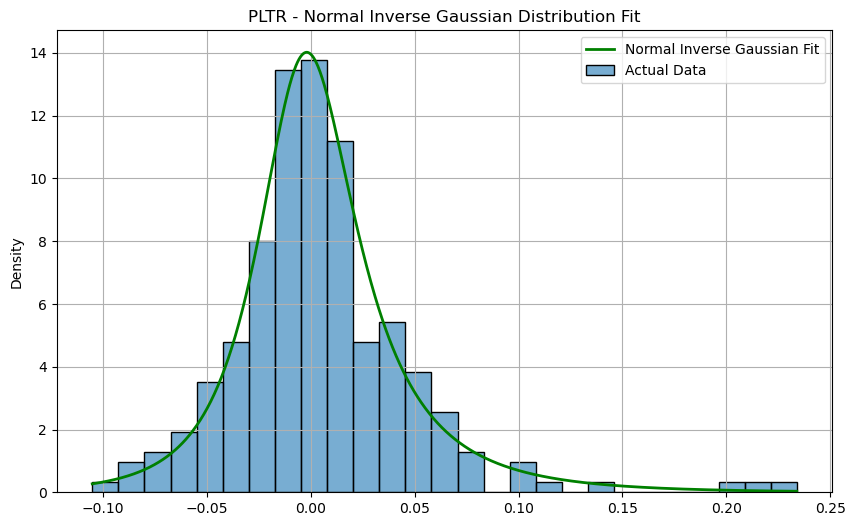


AIC Values for MA:
  Normal: -1543.6253
  Generalized T: -1559.7485
  Normal Inverse Gaussian: -1556.7125
  Skew Normal: -1543.9795

Best Fit Distribution - MA: Generalized T
  df: 6.468192
  loc: 0.001025
  scale: 0.008889


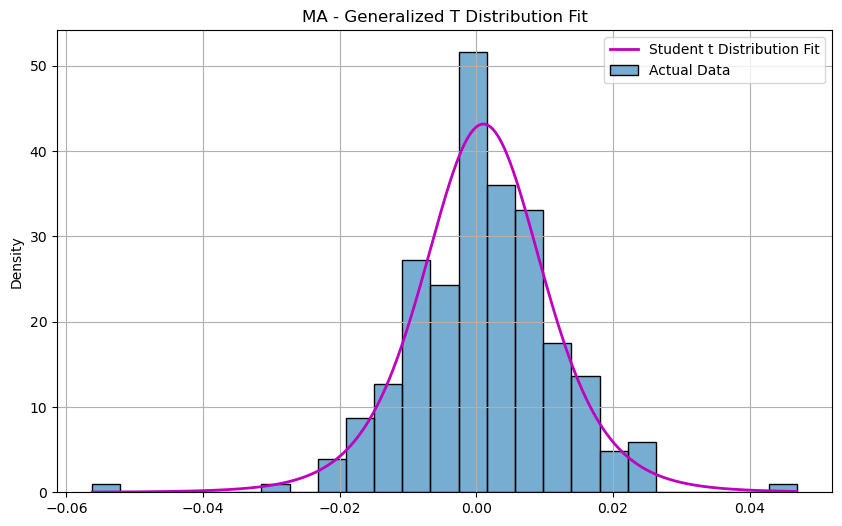


AIC Values for C:
  Normal: -1347.7961
  Generalized T: -1370.8899
  Normal Inverse Gaussian: -1369.4803
  Skew Normal: -1347.2866

Best Fit Distribution - C: Generalized T
  df: 4.168034
  loc: 0.000738
  scale: 0.011848


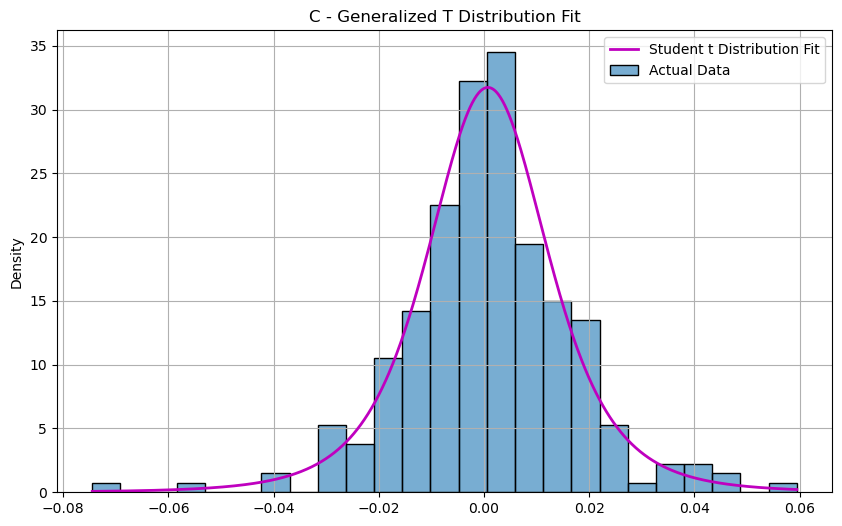


AIC Values for BKNG:
  Normal: -1358.5195
  Generalized T: -1367.0186
  Normal Inverse Gaussian: -1364.9849
  Skew Normal: -1361.7381

Best Fit Distribution - BKNG: Generalized T
  df: 8.120434
  loc: 0.002086
  scale: 0.013533


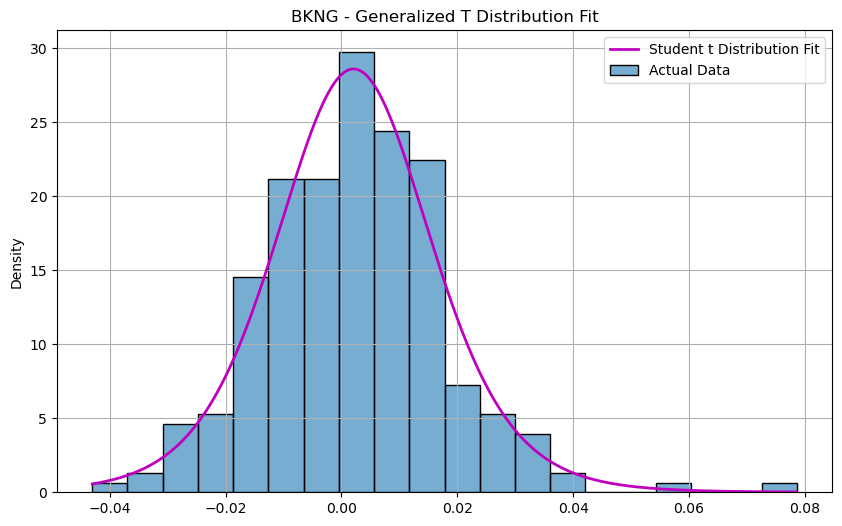


AIC Values for MCD:
  Normal: -1647.5078
  Generalized T: -1648.3481
  Normal Inverse Gaussian: -1647.7020
  Skew Normal: -1647.0799

Best Fit Distribution - MCD: Generalized T
  df: 10.042770
  loc: 0.000706
  scale: 0.007885


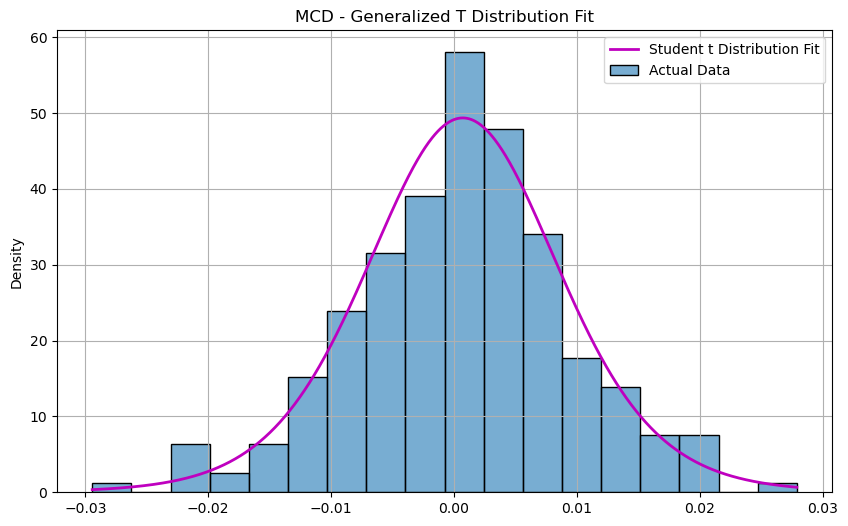


AIC Values for LOW:
  Normal: -1386.4443
  Generalized T: -1403.4027
  Normal Inverse Gaussian: -1404.1570
  Skew Normal: -1384.6314

Best Fit Distribution - LOW: Normal Inverse Gaussian
  a: 0.896215
  b: 0.112378
  loc: -0.001138
  scale: 0.014084


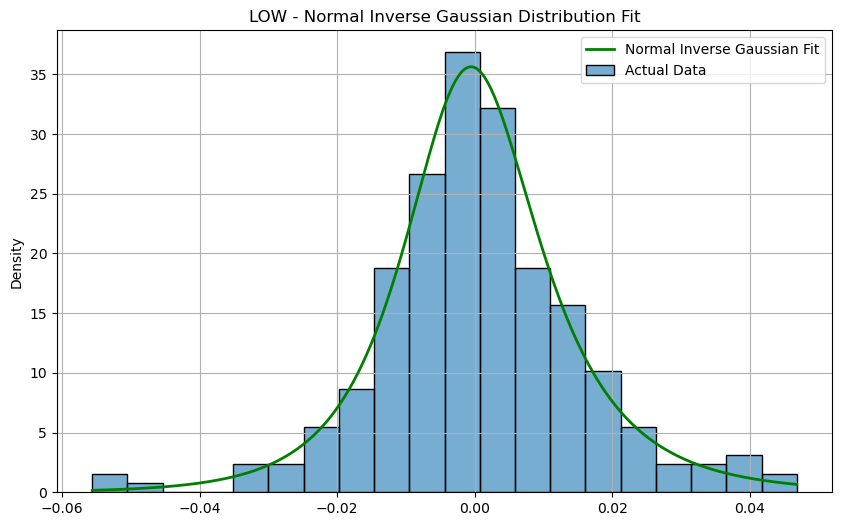


AIC Values for HD:
  Normal: -1432.1880
  Generalized T: -1455.5225
  Normal Inverse Gaussian: -1453.5702
  Skew Normal: -1432.5024

Best Fit Distribution - HD: Generalized T
  df: 4.535088
  loc: 0.000700
  scale: 0.010209


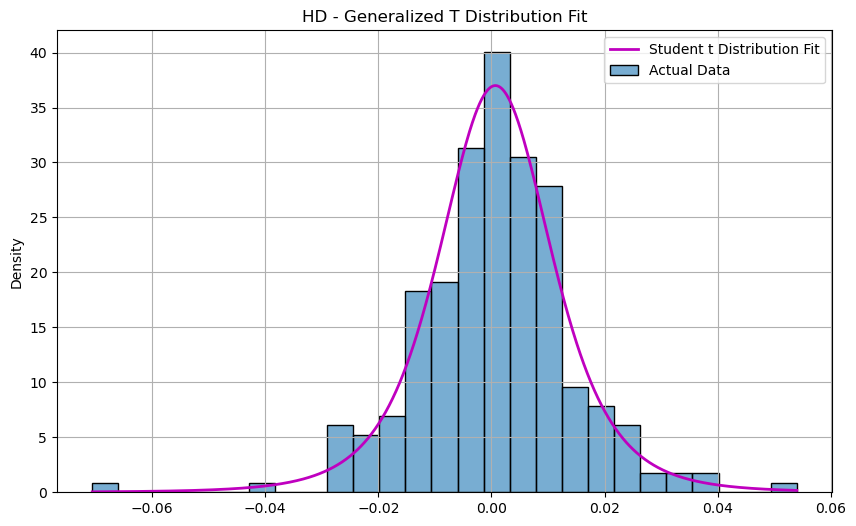


AIC Values for INTU:
  Normal: -1279.4031
  Generalized T: -1290.8660
  Normal Inverse Gaussian: -1289.6169
  Skew Normal: -1280.8094

Best Fit Distribution - INTU: Generalized T
  df: 5.570118
  loc: 0.002035
  scale: 0.014852


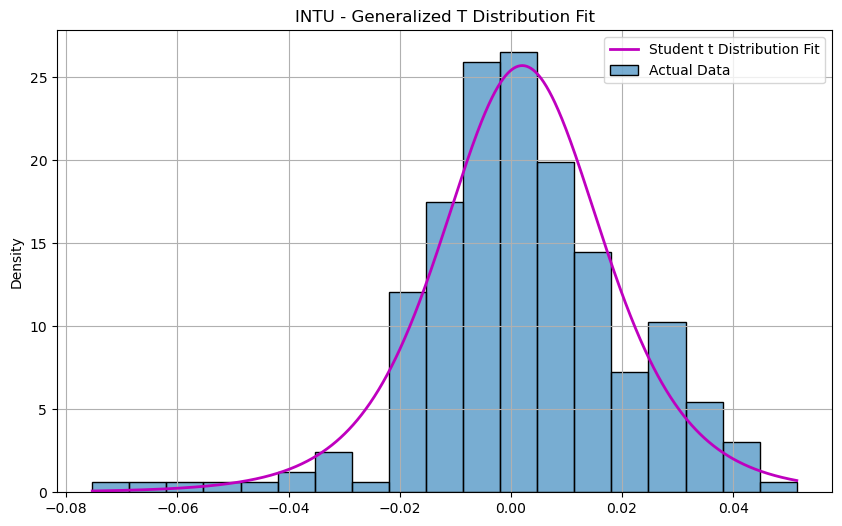


AIC Values for LRCX:
  Normal: -1170.8813
  Generalized T: -1182.1052
  Normal Inverse Gaussian: -1188.3338
  Skew Normal: -1181.2719

Best Fit Distribution - LRCX: Normal Inverse Gaussian
  a: 1.625477
  b: 0.555045
  loc: -0.006437
  scale: 0.026840


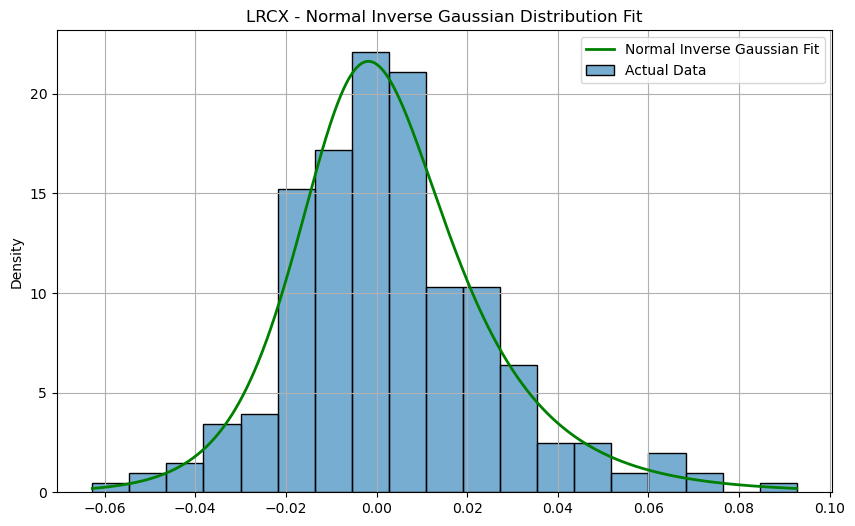


AIC Values for KKR:
  Normal: -1238.9745
  Generalized T: -1244.8947
  Normal Inverse Gaussian: -1243.0752
  Skew Normal: -1237.0954

Best Fit Distribution - KKR: Generalized T
  df: 7.228194
  loc: 0.002545
  scale: 0.017019


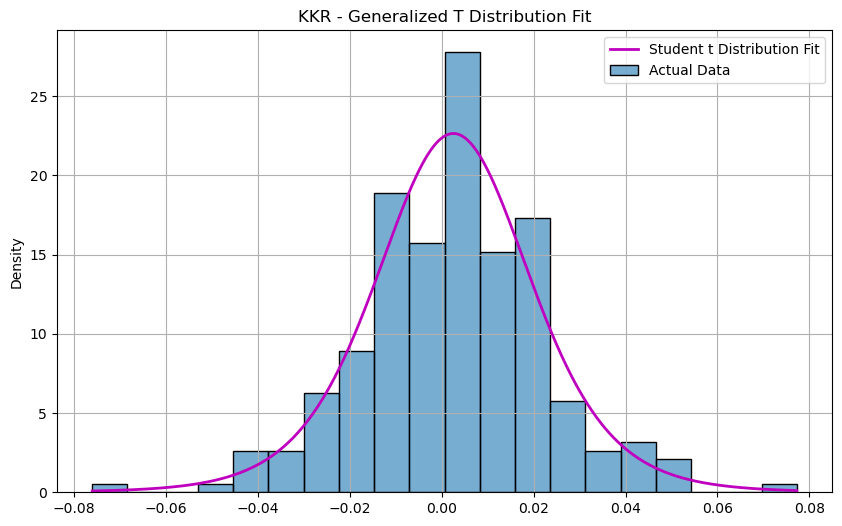


AIC Values for COST:
  Normal: -1491.0132
  Generalized T: -1519.0883
  Normal Inverse Gaussian: -1516.4459
  Skew Normal: -1498.6252

Best Fit Distribution - COST: Generalized T
  df: 4.621163
  loc: 0.001583
  scale: 0.009026


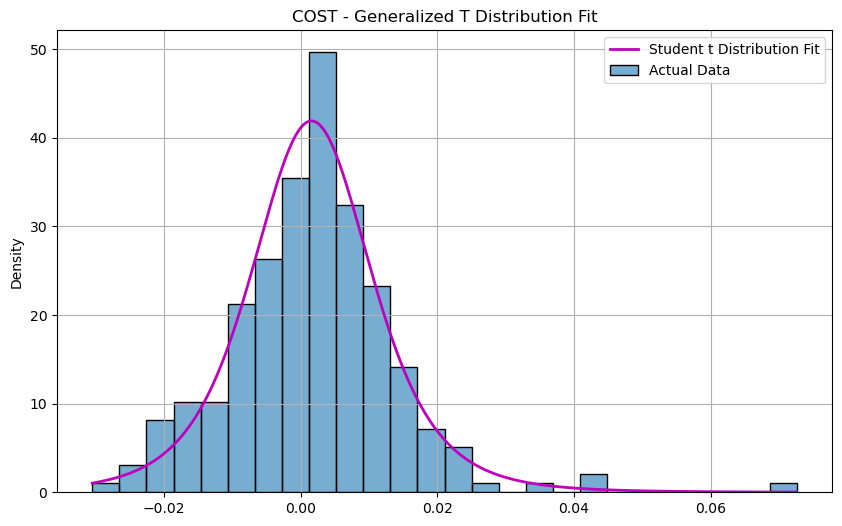


AIC Values for NEE:
  Normal: -1294.9475
  Generalized T: -1368.6339
  Normal Inverse Gaussian: -1363.5035
  Skew Normal: -1303.1285

Best Fit Distribution - NEE: Generalized T
  df: 2.951178
  loc: -0.000764
  scale: 0.010674


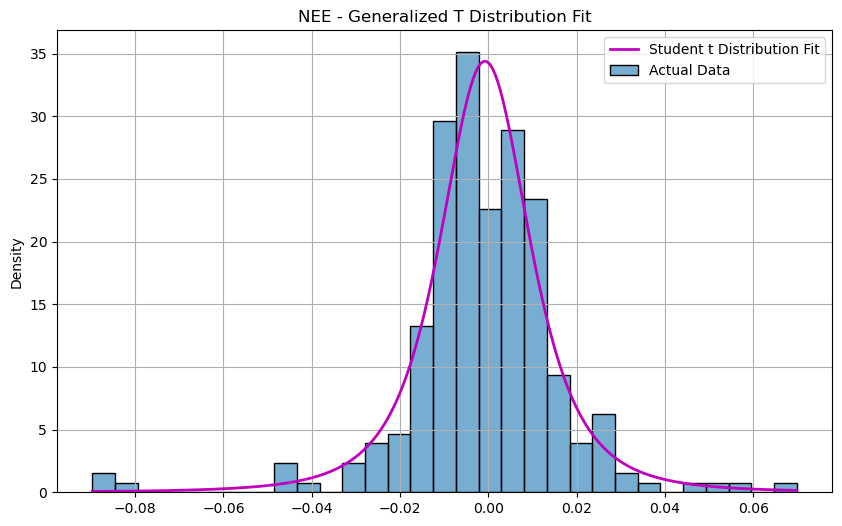


AIC Values for ABBV:
  Normal: -1478.3700
  Generalized T: -1522.5965
  Normal Inverse Gaussian: -1519.1022
  Skew Normal: -1486.5422

Best Fit Distribution - ABBV: Generalized T
  df: 4.019556
  loc: 0.000376
  scale: 0.008653


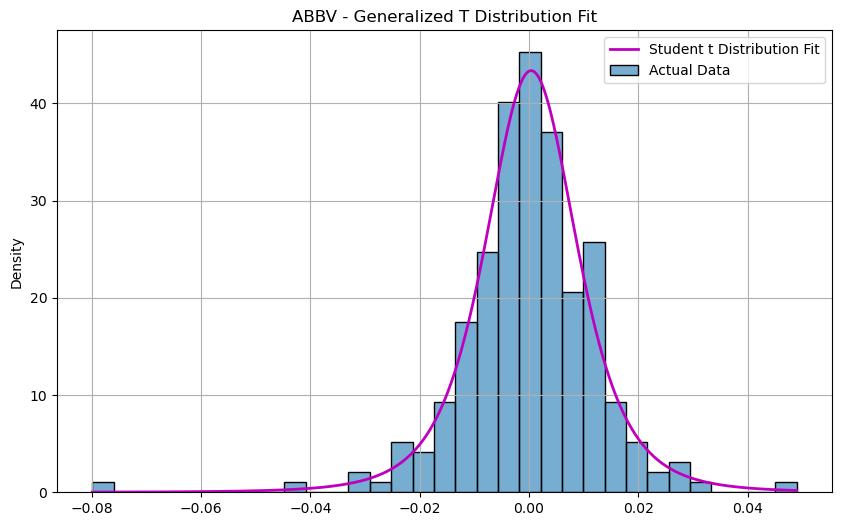


AIC Values for TSLA:
  Normal: -986.6790
  Generalized T: -992.0883
  Normal Inverse Gaussian: -991.9963
  Skew Normal: -986.3129

Best Fit Distribution - TSLA: Generalized T
  df: 6.491180
  loc: 0.003187
  scale: 0.027807


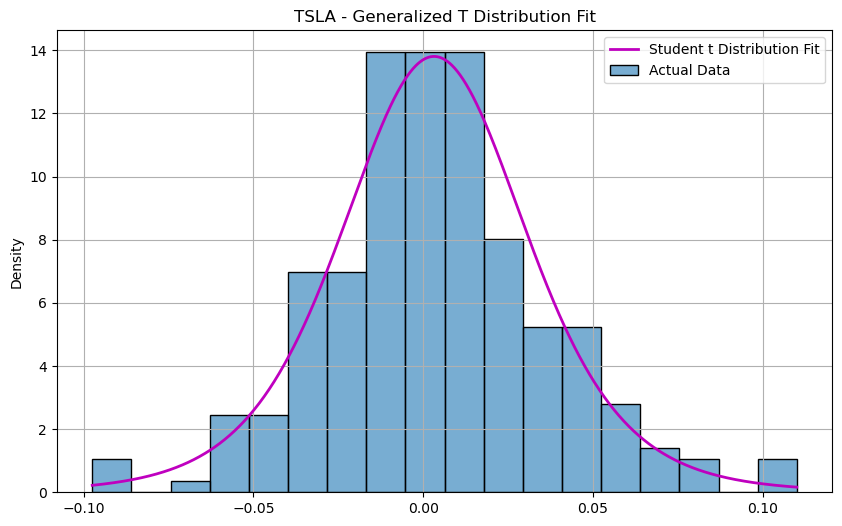


AIC Values for MSFT:
  Normal: -1355.1810
  Generalized T: -1361.0912
  Normal Inverse Gaussian: -1359.7714
  Skew Normal: -1356.8632

Best Fit Distribution - MSFT: Generalized T
  df: 7.771869
  loc: 0.001695
  scale: 0.013616


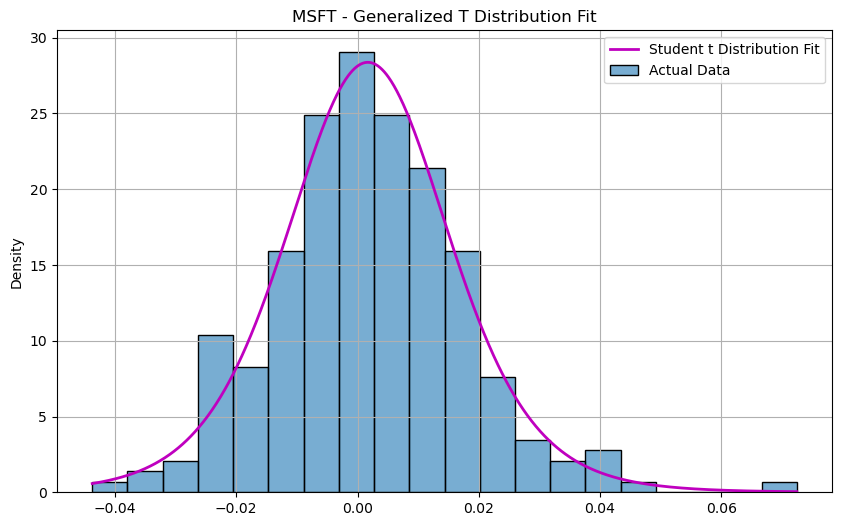


AIC Values for PEP:
  Normal: -1610.9241
  Generalized T: -1627.7076
  Normal Inverse Gaussian: -1625.6668
  Skew Normal: -1615.9470

Best Fit Distribution - PEP: Generalized T
  df: 5.804995
  loc: 0.000131
  scale: 0.007610


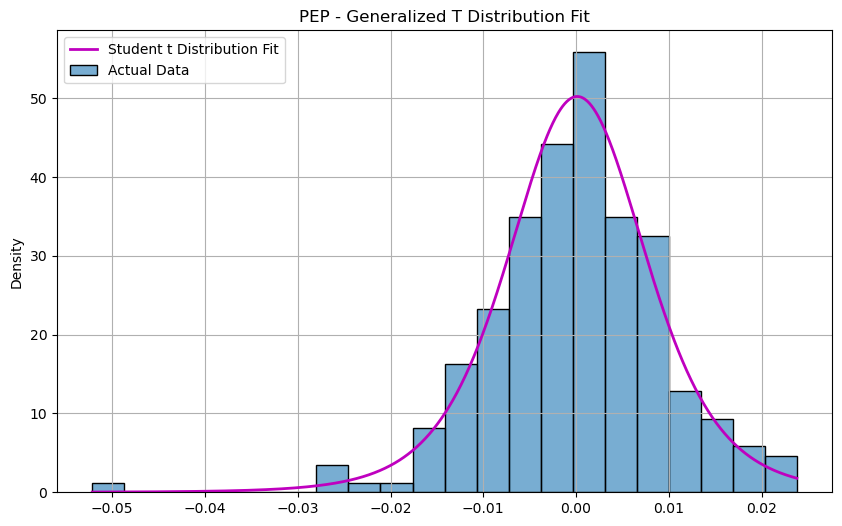


AIC Values for CB:
  Normal: -1459.5364
  Generalized T: -1473.9467
  Normal Inverse Gaussian: -1471.9825
  Skew Normal: -1459.1858

Best Fit Distribution - CB: Generalized T
  df: 5.691797
  loc: 0.000354
  scale: 0.010325


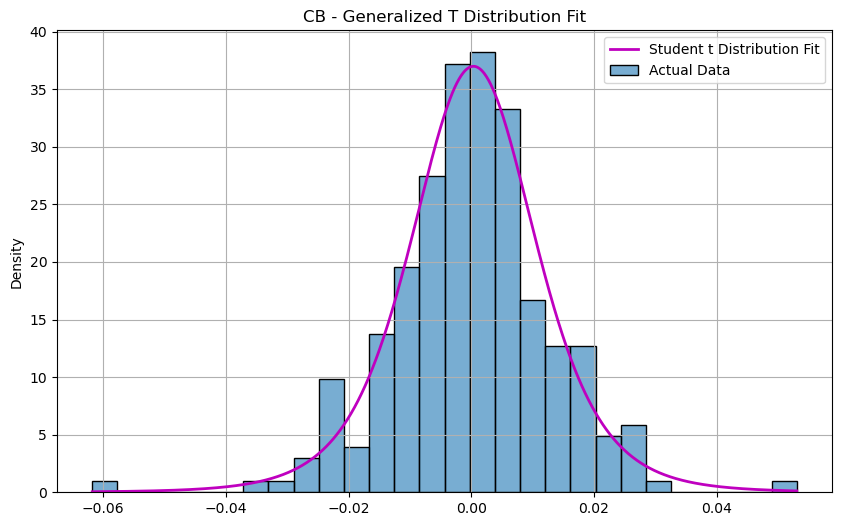


AIC Values for PANW:
  Normal: -1144.9120
  Generalized T: -1201.9118
  Normal Inverse Gaussian: -1198.8647
  Skew Normal: -1152.8895

Best Fit Distribution - PANW: Generalized T
  df: 3.322145
  loc: 0.003262
  scale: 0.015557


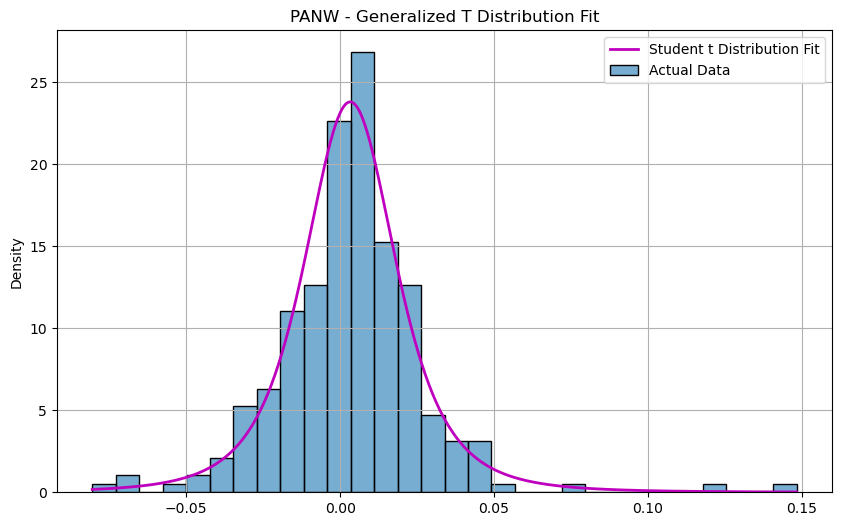


AIC Values for BLK:
  Normal: -1417.9315
  Generalized T: -1423.7598
  Normal Inverse Gaussian: -1421.9846
  Skew Normal: -1420.3996

Best Fit Distribution - BLK: Generalized T
  df: 7.933686
  loc: 0.000519
  scale: 0.012039


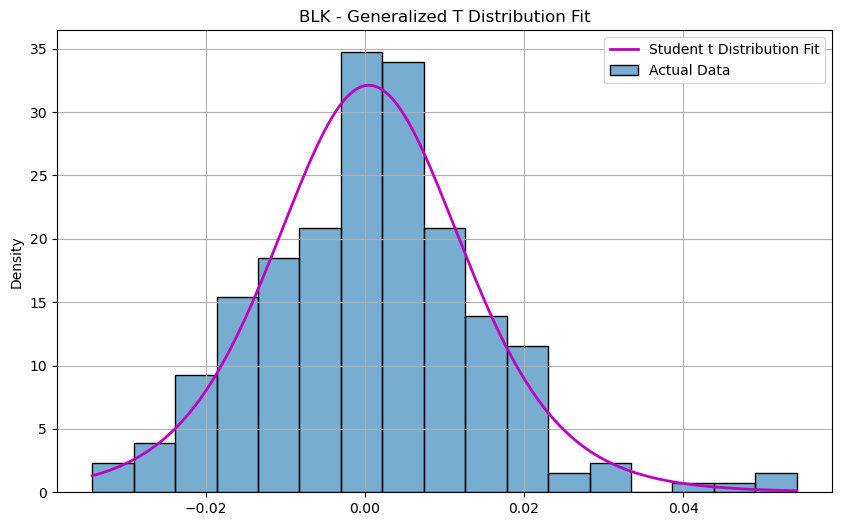


Best Fit Distribution Summary:


Stock Best Distribution  Log-likelihood          AIC          BIC  \
0    WFC     Generalized T      663.235968 -1320.471937 -1309.919578   
1    ETN     Generalized T      679.838883 -1353.677766 -1343.125408   
2   AMZN     Generalized T      619.125172 -1232.250344 -1221.697985   
3   QCOM     Generalized T      632.759816 -1259.519631 -1248.967273   
4    LMT     Generalized T      797.703337 -1589.406674 -1578.854315   
..   ...               ...             ...          ...          ...   
94  MSFT     Generalized T      683.545607 -1361.091213 -1350.538855   
95   PEP     Generalized T      816.853782 -1627.707565 -1617.155206   
96    CB     Generalized T      739.973373 -1473.946746 -1463.394388   
97  PANW     Generalized T      603.955887 -1201.911774 -1191.359415   
98   BLK     Generalized T      714.879892 -1423.759785 -1413.207426   

    Param: df  Param: loc  Param: scale  Param: a  Param: b  Param: shape  
0    5.003669    0.000983      0.013692       NaN       NaN           NaN  
1    3.878344    0.002363      0.012027       NaN       NaN           NaN  
2    5.921859    0.002174      0.016899       NaN       NaN           NaN  
3    5.220655    0.001358      0.015614       NaN       NaN           NaN  
4    3.703325   -0.000160      0.007392       NaN       NaN           NaN  
..        ...         ...           ...       ...       ...           ...  
94   7.771869    0.001695      0.013616       NaN       NaN           NaN  
95   5.804995    0.000131      0.007610       NaN       NaN           NaN  
96   5.691797    0.000354      0.010325       NaN       NaN           NaN  
97   3.322145    0.003262      0.015557       NaN       NaN           NaN  
98   7.933686    0.000519      0.012039       NaN       NaN           NaN  

[99 rows x 11 columns]


Distribution Selection Summary:
Generalized T: 87 stocks (87.88%)
Normal Inverse Gaussian: 11 stocks (11.11%)
Skew Normal: 1 stocks (1.01%)


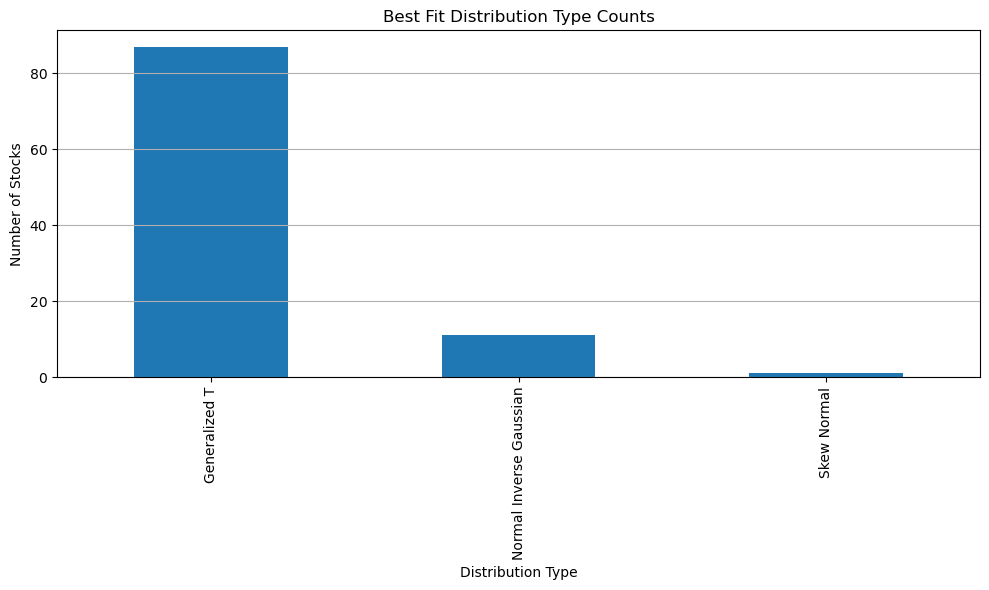


Stocks best fit by Generalized T distribution:
WFC, ETN, AMZN, QCOM, LMT, KO, JNJ, ISRG, XOM, MDT, DHR, PLD, BA, PG, MRK, AMD, BX, PM, SCHW, VZ, COP, ADI, BAC, TMO, CVX, ANET, NVDA, GILD, CMCSA, DIS, AXP, HON, META, NFLX, PGR, LLY, JPM, VRTX, TJX, EQIX, AAPL, FI, DE, SBUX, GOOGL, T, ABT, BMY, MS, CRM, PFE, SPGI, BRK-B, ADBE, ACN, LIN, V, WMT, CAT, RTX, UNP, IBM, TXN, ADP, GOOG, ORCL, BSX, UNH, GS, UBER, CSCO, MA, C, BKNG, MCD, HD, INTU, KKR, COST, NEE, ABBV, TSLA, MSFT, PEP, CB, PANW, BLK

Stocks best fit by Normal Inverse Gaussian distribution:
NOW, GE, MU, AMGN, TMUS, SYK, AVGO, MMC, PLTR, LOW, LRCX

Stocks best fit by Skew Normal distribution:
AMAT


In [ ]:
# 3. Best Model Selection and Parameter Reporting

# Fit all distributions for each stock and select the best model
def find_best_distribution(returns_series):
    """
    Fit multiple distributions and return the best fitting distribution
    """
    stock_name = returns_series.name
    returns_data = returns_series.dropna().values
    
    # Fit various distributions
    normal_fit = fit_normal(returns_data)
    # Use simplified t distribution as generalized T distribution
    try:
        df, loc, scale = stats.t.fit(returns_data)
        loglikelihood = np.sum(stats.t.logpdf(returns_data, df, loc, scale))
        aic = -2 * loglikelihood + 2 * 3  # 3 parameters
        bic = -2 * loglikelihood + 3 * np.log(len(returns_data))
        params = {'df': df, 'loc': loc, 'scale': scale}
        gen_t_fit = {'distribution': 'Generalized T', 'params': params, 'loglikelihood': loglikelihood, 'aic': aic, 'bic': bic}
    except:
        print(f"Warning: T distribution fitting failed for {stock_name}")
        gen_t_fit = {'distribution': 'Generalized T', 'params': None, 'loglikelihood': -np.inf, 'aic': np.inf, 'bic': np.inf}
    
    nig_fit = fit_normal_inverse_gaussian(returns_data)
    skew_normal_fit = fit_skew_normal(returns_data)
    
    # Put all fitting results in a list
    all_fits = [normal_fit, gen_t_fit, nig_fit, skew_normal_fit]
    
    # Print AIC values for all distributions
    print(f"\nAIC Values for {stock_name}:")
    for fit in all_fits:
        print(f"  {fit['distribution']}: {fit['aic']:.4f}")
    
    # Find the model with the minimum AIC
    best_fit = min(all_fits, key=lambda x: x['aic'])
    
    print(f"\nBest Fit Distribution - {stock_name}: {best_fit['distribution']}")
    if best_fit['params'] is not None:
        for param_name, param_value in best_fit['params'].items():
            print(f"  {param_name}: {param_value:.6f}")
    
    # Add stock name and fit evaluation metrics
    best_fit['stock'] = stock_name
    
    # Create distribution visualization using the best-fit model
    plt.figure(figsize=(10, 6))
    
    # Plot histogram of actual data
    sns.histplot(returns_data, kde=False, stat='density', alpha=0.6, label='Actual Data')
    
    # Plot PDF of the fitted distribution
    x = np.linspace(min(returns_data), max(returns_data), 1000)
    
    if best_fit['distribution'] == 'Normal':
        mu, sigma = best_fit['params']['mu'], best_fit['params']['sigma']
        pdf = stats.norm.pdf(x, mu, sigma)
        plt.plot(x, pdf, 'r-', lw=2, label='Normal Fit')
    # Simplified t distribution
    elif best_fit['distribution'] == 'Generalized T' and best_fit['params'] is not None:
        df, loc, scale = best_fit['params']['df'], best_fit['params']['loc'], best_fit['params']['scale']
        pdf = stats.t.pdf(x, df, loc, scale)
        plt.plot(x, pdf, 'm-', lw=2, label='Student t Distribution Fit')
    
    # elif best_fit['distribution'] == 'Generalized T' and best_fit['params'] is not None:
    #     if 'df' in best_fit['params']:  # Handle simplified t distribution case
    #         df, loc, scale = best_fit['params']['df'], best_fit['params']['loc'], best_fit['params']['scale']
    #         pdf = stats.t.pdf(x, df, loc, scale)
    #         plt.plot(x, pdf, 'm-', lw=2, label='Student t Distribution Fit')
    #     else:  # Handle complete generalized T distribution
    #         mu, sigma, nu, tau = [best_fit['params'][p] for p in ['mu', 'sigma', 'nu', 'tau']]
            
    #         # Calculate PDF of generalized T distribution
    #         def gen_t_pdf(x, mu, sigma, nu, tau):
    #             z = (x - mu) / sigma
    #             from scipy.special import beta
    #             c = tau / (2 * sigma * nu**(1/tau) * beta(1/tau, nu/tau))
    #             pdf = c * np.exp(-(nu + 1/tau)/tau * np.log(1 + (np.abs(z)**tau)/nu))
    #             return pdf
            
    #         pdf = gen_t_pdf(x, mu, sigma, nu, tau)
    #         plt.plot(x, pdf, 'm-', lw=2, label='Generalized T Distribution Fit')
    elif best_fit['distribution'] == 'Normal Inverse Gaussian' and best_fit['params'] is not None:
        a, b, loc, scale = [best_fit['params'][p] for p in ['a', 'b', 'loc', 'scale']]
        pdf = stats.norminvgauss.pdf(x, a, b, loc, scale)
        plt.plot(x, pdf, 'g-', lw=2, label='Normal Inverse Gaussian Fit')
    
    elif best_fit['distribution'] == 'Skew Normal' and best_fit['params'] is not None:
        shape, loc, scale = [best_fit['params'][p] for p in ['shape', 'loc', 'scale']]
        pdf = stats.skewnorm.pdf(x, shape, loc, scale)
        plt.plot(x, pdf, 'b-', lw=2, label='Skew Normal Fit')
    
    plt.title(f"{stock_name} - {best_fit['distribution']} Distribution Fit")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_fit

# Find the best fitting distribution for all portfolio stocks
best_fits = {}
for stock in portfolio_stocks:
    if stock in portfolio_returns.columns:
        best_fit = find_best_distribution(portfolio_returns[stock])
        best_fits[stock] = best_fit

# Create results summary table
results_summary = []
for stock, fit_result in best_fits.items():
    result_row = {
        'Stock': stock,
        'Best Distribution': fit_result['distribution'],
        'Log-likelihood': fit_result['loglikelihood'],
        'AIC': fit_result['aic'],
        'BIC': fit_result['bic']
    }
    
    # Add parameters
    if fit_result['params'] is not None:
        for param_name, param_value in fit_result['params'].items():
            result_row[f'Param: {param_name}'] = param_value
    
    results_summary.append(result_row)

# Convert to DataFrame and display
results_df = pd.DataFrame(results_summary)
print("\nBest Fit Distribution Summary:")
display(results_df)

# Visualize distribution of different distribution types
distribution_counts = results_df['Best Distribution'].value_counts()
print("\nDistribution Selection Summary:")
for dist, count in distribution_counts.items():
    print(f"{dist}: {count} stocks ({count/len(results_df)*100:.2f}%)")

plt.figure(figsize=(10, 6))
distribution_counts.plot(kind='bar')
plt.title('Best Fit Distribution Type Counts')
plt.xlabel('Distribution Type')
plt.ylabel('Number of Stocks')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Create lists of stocks for each distribution type
distribution_stocks = {}
for dist in distribution_counts.index:
    stocks_with_dist = results_df[results_df['Best Distribution'] == dist]['Stock'].tolist()
    distribution_stocks[dist] = stocks_with_dist
    print(f"\nStocks best fit by {dist} distribution:")
    print(", ".join(stocks_with_dist))

In [ ]:
# 4. Risk Measurement Calculation

# Function to calculate VaR and ES
def calculate_var_es(returns, alpha=0.05):
    """
    Calculate VaR and ES for a given distribution
    
    Parameters:
    returns -- return data
    alpha -- confidence level (default: 0.05)
    
    Returns:
    VaR, ES
    """
    # Take alpha quantile of sorted losses
    sorted_returns = np.sort(returns)
    index = int(alpha * len(sorted_returns))
    var = -sorted_returns[index]
    
    # Calculate ES (Expected Shortfall)
    es = -np.mean(sorted_returns[:index])
    
    return var, es

# Monte Carlo simulation based on Gaussian Copula
def gaussian_copula_simulation(best_fits, portfolio_weights, n_simulations=100000):
    """
    Calculate risk measures using Gaussian Copula
    
    Parameters:
    best_fits -- best fitting distribution and parameters for each stock
    portfolio_weights -- portfolio weights
    n_simulations -- number of simulations (default: 100000)
    
    Returns:
    portfolio_return_simulations -- portfolio return simulation results
    """
    # Extract stock list
    stocks = list(portfolio_weights.keys())
    
    # Keep only stocks with results in best_fits
    stocks = [stock for stock in stocks if stock in best_fits and best_fits[stock]['params'] is not None]
    
    n_stocks = len(stocks)
    
    # Extract correlation matrix from original data
    returns_data = pd.DataFrame({stock: portfolio_returns[stock] for stock in stocks})
    correlation_matrix = returns_data.corr().values
    
    # Ensure correlation matrix is positive definite
    try:
        L = np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        # If matrix is not positive definite, add a small diagonal component
        print("Warning: Correlation matrix is not positive definite. Adding a small diagonal component...")
        diag_addition = 1e-5
        adjusted_correlation = correlation_matrix + np.eye(n_stocks) * diag_addition
        L = np.linalg.cholesky(adjusted_correlation)
    
    # Generate correlated normal random variables
    uncorrelated_samples = np.random.normal(0, 1, size=(n_simulations, n_stocks))
    correlated_normal_samples = uncorrelated_samples @ L.T
    
    # Calculate uniform distribution U(0,1) samples
    uniform_samples = stats.norm.cdf(correlated_normal_samples)
    
    # Generate samples from the appropriate distribution for each stock
    simulated_returns = np.zeros_like(uniform_samples)
    
    for i, stock in enumerate(stocks):
        fit = best_fits[stock]
        dist_name = fit['distribution']
        params = fit['params']
        
        if dist_name == 'Normal':
            mu, sigma = params['mu'], params['sigma']
            simulated_returns[:, i] = stats.norm.ppf(uniform_samples[:, i], mu, sigma)
        
        elif dist_name == 'Generalized T':
            # Use Student's t distribution
            df, loc, scale = params['df'], params['loc'], params['scale']
            simulated_returns[:, i] = stats.t.ppf(uniform_samples[:, i], df, loc, scale)
        
        elif dist_name == 'Normal Inverse Gaussian':
            a, b, loc, scale = params['a'], params['b'], params['loc'], params['scale']
            # NIG distribution doesn't have an explicit inverse CDF, use approximation
            try:
                # Generate uniform random numbers and convert to NIG random variables
                # Since we can't directly use ppf, we use random sampling
                random_nig = stats.norminvgauss.rvs(a, b, loc, scale, size=n_simulations)
                # Sort and sample based on uniform samples
                sorted_nig = np.sort(random_nig)
                indices = (uniform_samples[:, i] * n_simulations).astype(int)
                indices = np.clip(indices, 0, n_simulations - 1)
                simulated_returns[:, i] = sorted_nig[indices]
            except:
                print(f"Warning: Issue with NIG simulation for {stock}. Using normal approximation.")
                mu = stats.norminvgauss.mean(a, b, loc, scale)
                sigma = stats.norminvgauss.std(a, b, loc, scale)
                simulated_returns[:, i] = stats.norm.ppf(uniform_samples[:, i], mu, sigma)
        
        elif dist_name == 'Skew Normal':
            shape, loc, scale = params['shape'], params['loc'], params['scale']
            simulated_returns[:, i] = stats.skewnorm.ppf(uniform_samples[:, i], shape, loc, scale)
    
    # Calculate portfolio returns
    weights_array = np.array([portfolio_weights[stock] for stock in stocks])
    # Normalize weights
    weights_array = weights_array / np.sum(weights_array)
    
    portfolio_return_simulations = simulated_returns @ weights_array
    
    return portfolio_return_simulations

# Multivariate normal distribution simulation
def multivariate_normal_simulation(portfolio_returns, portfolio_weights, n_simulations=100000):
    """
    Calculate risk measures using multivariate normal distribution
    
    Parameters:
    portfolio_returns -- DataFrame containing return data
    portfolio_weights -- portfolio weights
    n_simulations -- number of simulations (default: 100000)
    
    Returns:
    portfolio_return_simulations -- portfolio return simulation results
    """
    # Extract stock list
    stocks = list(portfolio_weights.keys())
    
    # Keep only stocks present in return data
    stocks = [stock for stock in stocks if stock in portfolio_returns.columns]
    
    # Extract relevant data
    returns = portfolio_returns[stocks]
    
    # Calculate mean vector and covariance matrix
    mu = returns.mean().values
    cov = returns.cov().values
    
    # Generate multivariate normal distribution samples
    simulated_returns = np.random.multivariate_normal(mu, cov, size=n_simulations)
    
    # Calculate portfolio returns
    weights_array = np.array([portfolio_weights[stock] for stock in stocks])
    # Normalize weights
    weights_array = weights_array / np.sum(weights_array)
    
    portfolio_return_simulations = simulated_returns @ weights_array
    
    return portfolio_return_simulations

# Get portfolio weights
def get_portfolio_weights():
    """
    Extract weights from portfolio data
    
    Returns:
    Dictionary with Portfolio names as keys and dictionaries of stock weights as values
    """
    portfolios = {}
    
    for portfolio_name in portfolio['Portfolio'].unique():
        portfolio_data = portfolio[portfolio['Portfolio'] == portfolio_name]
        # Calculate total holding
        total_holding = portfolio_data['Holding'].sum()
        # Calculate weight for each stock
        weights = {row['Symbol']: row['Holding'] / total_holding 
                  for _, row in portfolio_data.iterrows()}
        portfolios[portfolio_name] = weights
    
    # Calculate total portfolio weights
    all_weights = {}
    total_holding = portfolio['Holding'].sum()
    for _, row in portfolio.iterrows():
        all_weights[row['Symbol']] = row['Holding'] / total_holding
    
    portfolios['Total'] = all_weights
    
    return portfolios

# Main function: Calculate and compare VaR and ES using two methods
def calculate_risk_metrics():
    """
    Calculate and compare risk measures using Gaussian Copula and multivariate normal distribution
    """
    # Extract portfolio weights
    portfolio_weights = get_portfolio_weights()
    
    # Prepare result storage
    var_es_results = []
    
    # Set confidence level and number of simulations
    alpha = 0.05
    n_simulations = 100000
    
    # Calculate risk measures for each portfolio
    for portfolio_name, weights in portfolio_weights.items():
        print(f"\nCalculating risk metrics for portfolio: {portfolio_name}")
        
        try:
            # Using Gaussian Copula method
            copula_simulations = gaussian_copula_simulation(best_fits, weights, n_simulations)
            var_copula, es_copula = calculate_var_es(copula_simulations, alpha)
            
            # Add to results
            var_es_results.append({
                'Portfolio': portfolio_name,
                'Method': 'Gaussian Copula',
                'VaR_1d_5%': var_copula,
                'ES_1d_5%': es_copula
            })
            
            print(f"  Gaussian Copula Method - VaR: {var_copula:.6f}, ES: {es_copula:.6f}")
        except Exception as e:
            print(f"  Error in Gaussian Copula calculation: {str(e)}")
        
        try:
            # Using multivariate normal distribution method
            normal_simulations = multivariate_normal_simulation(portfolio_returns, weights, n_simulations)
            var_normal, es_normal = calculate_var_es(normal_simulations, alpha)
            
            # Add to results
            var_es_results.append({
                'Portfolio': portfolio_name,
                'Method': 'Multivariate Normal',
                'VaR_1d_5%': var_normal,
                'ES_1d_5%': es_normal
            })
            
            print(f"  Multivariate Normal Method - VaR: {var_normal:.6f}, ES: {es_normal:.6f}")
        except Exception as e:
            print(f"  Error in Multivariate Normal calculation: {str(e)}")
    
    return pd.DataFrame(var_es_results)

# Execute risk measure calculation
var_es_results = calculate_risk_metrics()


Calculating risk metrics for portfolio: A
  Gaussian Copula Method - VaR: 0.013209, ES: 0.017881
  Multivariate Normal Method - VaR: 0.013561, ES: 0.017255

Calculating risk metrics for portfolio: B
  Gaussian Copula Method - VaR: 0.011571, ES: 0.015825
  Multivariate Normal Method - VaR: 0.012328, ES: 0.015531

Calculating risk metrics for portfolio: C
  Gaussian Copula Method - VaR: 0.013683, ES: 0.018563
  Multivariate Normal Method - VaR: 0.014826, ES: 0.019034

Calculating risk metrics for portfolio: Total
  Gaussian Copula Method - VaR: 0.011853, ES: 0.015954
  Multivariate Normal Method - VaR: 0.012512, ES: 0.015857



VaR Comparison (1-day, 5% confidence level):


Method     Gaussian Copula  Multivariate Normal  Difference (%)
Portfolio                                                      
A                 0.013209             0.013561       -2.595013
B                 0.011571             0.012328       -6.137637
C                 0.013683             0.014826       -7.713588
Total             0.011853             0.012512       -5.264232


ES Comparison (1-day, 5% confidence level):


Method     Gaussian Copula  Multivariate Normal  Difference (%)
Portfolio                                                      
A                 0.017881             0.017255        3.623291
B                 0.015825             0.015531        1.890266
C                 0.018563             0.019034       -2.476027
Total             0.015954             0.015857        0.610838

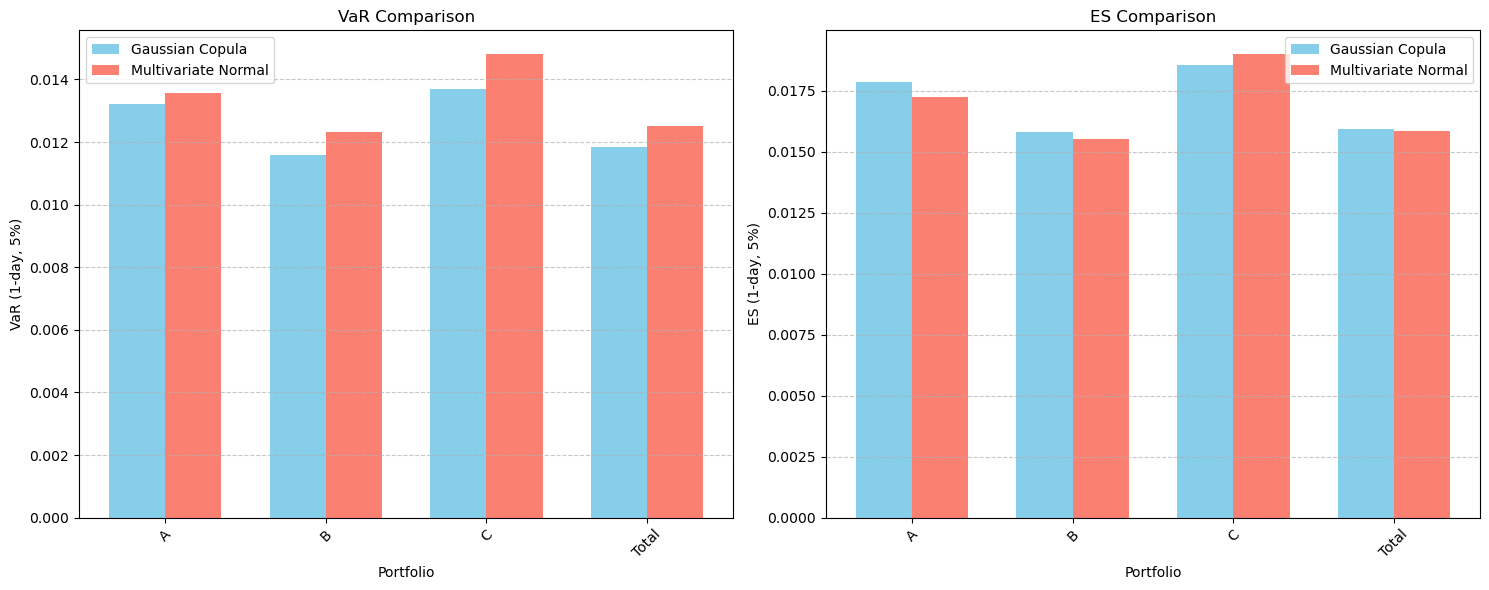

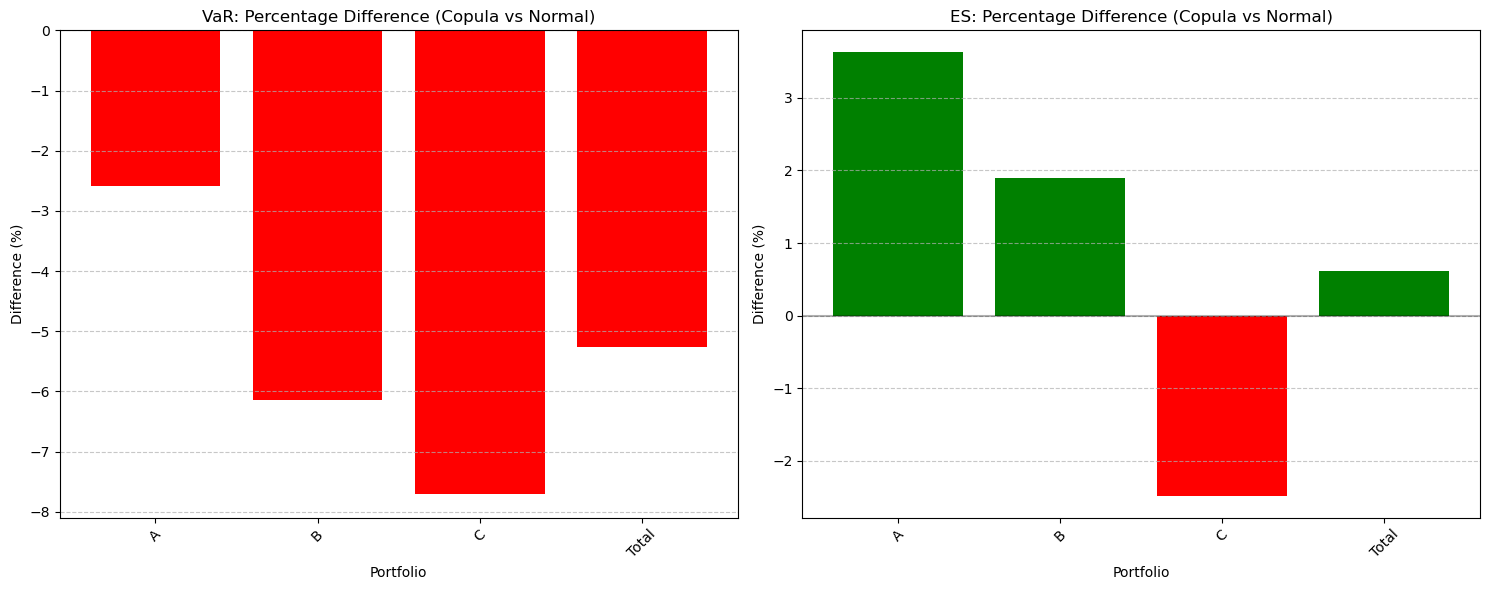

In [32]:
# 5. Results Comparison and Discussion

# Reorganize results into a more easily comparable format
def format_comparison_results(var_es_results):
    """
    Reformat results for easier comparison
    """
    # Pivot tables
    pivot_var = var_es_results.pivot(index='Portfolio', columns='Method', values='VaR_1d_5%')
    pivot_es = var_es_results.pivot(index='Portfolio', columns='Method', values='ES_1d_5%')
    
    # Calculate percentage differences
    pivot_var['Difference (%)'] = ((pivot_var['Gaussian Copula'] / pivot_var['Multivariate Normal']) - 1) * 100
    pivot_es['Difference (%)'] = ((pivot_es['Gaussian Copula'] / pivot_es['Multivariate Normal']) - 1) * 100
    
    return pivot_var, pivot_es

# Format results
pivot_var, pivot_es = format_comparison_results(var_es_results)

# Display results
print("\nVaR Comparison (1-day, 5% confidence level):")
display(pivot_var)

print("\nES Comparison (1-day, 5% confidence level):")
display(pivot_es)

# Visualization comparison
plt.figure(figsize=(15, 6))

# VaR comparison
plt.subplot(1, 2, 1)
bar_width = 0.35
indices = np.arange(len(pivot_var.index))

plt.bar(indices - bar_width/2, pivot_var['Gaussian Copula'], bar_width, 
        label='Gaussian Copula', color='skyblue')
plt.bar(indices + bar_width/2, pivot_var['Multivariate Normal'], bar_width, 
        label='Multivariate Normal', color='salmon')

plt.xlabel('Portfolio')
plt.ylabel('VaR (1-day, 5%)')
plt.title('VaR Comparison')
plt.xticks(indices, pivot_var.index, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# ES comparison
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width/2, pivot_es['Gaussian Copula'], bar_width, 
        label='Gaussian Copula', color='skyblue')
plt.bar(indices + bar_width/2, pivot_es['Multivariate Normal'], bar_width, 
        label='Multivariate Normal', color='salmon')

plt.xlabel('Portfolio')
plt.ylabel('ES (1-day, 5%)')
plt.title('ES Comparison')
plt.xticks(indices, pivot_es.index, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Percentage difference visualization
plt.figure(figsize=(15, 6))

# VaR percentage difference
plt.subplot(1, 2, 1)
colors = ['green' if x >= 0 else 'red' for x in pivot_var['Difference (%)']]
plt.bar(pivot_var.index, pivot_var['Difference (%)'], color=colors)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Portfolio')
plt.ylabel('Difference (%)')
plt.title('VaR: Percentage Difference (Copula vs Normal)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# ES percentage difference
plt.subplot(1, 2, 2)
colors = ['green' if x >= 0 else 'red' for x in pivot_es['Difference (%)']]
plt.bar(pivot_es.index, pivot_es['Difference (%)'], color=colors)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Portfolio')
plt.ylabel('Difference (%)')
plt.title('ES: Percentage Difference (Copula vs Normal)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# PART 5

In [34]:
# 5. ES-based Risk Parity Portfolio Calculation

def simulate_returns_from_best_fit(stocks, best_fits, n_simulations=10000):
    """
    Generate simulated returns based on best-fit distribution models
    
    Parameters:
    stocks -- list of stock symbols
    best_fits -- dictionary of best-fit distributions
    n_simulations -- number of simulations
    
    Returns:
    simulated returns array and list of valid stocks
    """
    # Filter stocks with valid best-fit distributions
    valid_stocks = [stock for stock in stocks if stock in best_fits and best_fits[stock]['params'] is not None]
    n_assets = len(valid_stocks)
    
    if n_assets == 0:
        print("No valid stocks with fitted distributions found.")
        return None, []
    
    # Generate return simulations for all stocks
    simulations = np.zeros((n_simulations, n_assets))
    
    print("Generating simulated returns based on best fit distributions...")
    for i, stock in enumerate(valid_stocks):
        fit = best_fits[stock]
        dist_name = fit['distribution']
        params = fit['params']
        
        if dist_name == 'Normal':
            mu, sigma = params['mu'], params['sigma']
            simulations[:, i] = np.random.normal(mu, sigma, n_simulations)
        
        elif dist_name == 'Generalized T':
            df, loc, scale = params['df'], params['loc'], params['scale']
            simulations[:, i] = stats.t.rvs(df, loc, scale, size=n_simulations)
        
        elif dist_name == 'Normal Inverse Gaussian':
            a, b, loc, scale = params['a'], params['b'], params['loc'], params['scale']
            try:
                simulations[:, i] = stats.norminvgauss.rvs(a, b, loc, scale, size=n_simulations)
            except:
                print(f"Warning: NIG simulation failed for {stock}, using normal approximation")
                mu = loc + b * scale * np.sqrt(1 + (b/a)**2)
                sigma = scale * np.sqrt((1 + (b/a)**2) / a**2)
                simulations[:, i] = np.random.normal(mu, sigma, n_simulations)
        
        elif dist_name == 'Skew Normal':
            shape, loc, scale = params['shape'], params['loc'], params['scale']
            simulations[:, i] = stats.skewnorm.rvs(shape, loc, scale, size=n_simulations)
    
    return simulations, valid_stocks

def calculate_portfolio_es(weights, simulations, alpha=0.05):
    """
    Calculate portfolio Expected Shortfall (ES)
    
    Parameters:
    weights -- portfolio weights
    simulations -- simulated returns array
    alpha -- confidence level
    
    Returns:
    ES value
    """
    # Calculate portfolio returns
    portfolio_returns = simulations @ weights
    
    # Calculate ES (negative average of worst alpha% returns)
    sorted_returns = np.sort(portfolio_returns)
    var_index = int(alpha * len(sorted_returns))
    es = -np.mean(sorted_returns[:var_index])
    
    return es

def calculate_es_contribution(weights, simulations, alpha=0.05):
    """
    Calculate each asset's contribution to portfolio ES
    
    Parameters:
    weights -- portfolio weights
    simulations -- simulated returns array
    alpha -- confidence level
    
    Returns:
    ES contribution and contribution percentage for each asset
    """
    n_assets = len(weights)
    es_contributions = np.zeros(n_assets)
    
    # Calculate overall ES
    portfolio_returns = simulations @ weights
    sorted_indices = np.argsort(portfolio_returns)
    var_index = int(alpha * len(portfolio_returns))
    tail_indices = sorted_indices[:var_index]
    portfolio_es = -np.mean(portfolio_returns[tail_indices])
    
    # Calculate ES contribution for each asset
    for i in range(n_assets):
        # Calculate average contribution of asset i in tail events
        asset_contribution = -np.mean(weights[i] * simulations[tail_indices, i])
        es_contributions[i] = asset_contribution
    
    # Calculate contribution percentage
    es_contrib_pct = es_contributions / portfolio_es * 100
    
    return es_contributions, es_contrib_pct

def es_risk_parity_objective(weights, target_contrib, simulations, alpha=0.05):
    """
    ES risk parity objective function
    
    Parameters:
    weights -- portfolio weights
    target_contrib -- target risk contribution percentage
    simulations -- simulated returns array
    alpha -- confidence level
    
    Returns:
    sum of squared differences between risk contributions and targets
    """
    # Ensure weights are positive and sum to 1
    weights_norm = np.abs(weights) / np.sum(np.abs(weights))
    
    # Calculate ES contributions
    _, es_contrib_pct = calculate_es_contribution(weights_norm, simulations, alpha)
    
    # Calculate sum of squared differences from target
    deviation = np.sum((es_contrib_pct - target_contrib)**2)
    
    return deviation

def optimize_es_risk_parity(simulations, valid_stocks, alpha=0.05, max_attempts=5):
    """
    Calculate ES-based risk parity portfolio
    
    Parameters:
    simulations -- simulated returns array
    valid_stocks -- list of valid stocks
    alpha -- ES confidence level
    max_attempts -- maximum optimization attempts
    
    Returns:
    risk parity weights dictionary
    """
    n_assets = len(valid_stocks)
    
    if n_assets == 0:
        return {}
    
    if n_assets == 1:
        return {valid_stocks[0]: 1.0}
    
    # Target risk contribution (equal)
    target_contrib = np.ones(n_assets) * (100 / n_assets)
    
    # Optimization parameters
    bounds = [(0.001, 1) for _ in range(n_assets)]  # Ensure weights are positive
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Ensure weights sum to 1
    
    best_result = None
    best_objective = np.inf
    
    # Multiple optimization attempts to avoid local minima
    for attempt in range(max_attempts):
        # Initial weights (equal weights for first attempt, random for subsequent attempts)
        if attempt == 0:
            initial_weights = np.ones(n_assets) / n_assets
        else:
            initial_weights = np.random.random(n_assets)
            initial_weights = initial_weights / np.sum(initial_weights)
        
        try:
            result = minimize(
                es_risk_parity_objective,
                initial_weights,
                args=(target_contrib, simulations, alpha),
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'maxiter': 1000, 'ftol': 1e-8, 'disp': False}
            )
            
            if result.success and result.fun < best_objective:
                best_result = result
                best_objective = result.fun
        except Exception as e:
            print(f"Optimization attempt {attempt+1} failed: {str(e)}")
    
    # If all optimization attempts fail, fall back to simple variance risk parity
    if best_result is None or not best_result.success:
        print("ES risk parity optimization failed. Falling back to variance risk parity.")
        # Calculate covariance matrix
        cov_matrix = np.cov(simulations.T)
        return variance_risk_parity_fallback(cov_matrix, valid_stocks)
    
    # Get optimal weights
    optimized_weights = best_result.x
    optimized_weights = optimized_weights / np.sum(optimized_weights)
    
    # Calculate final ES contributions
    es_contrib, es_contrib_pct = calculate_es_contribution(optimized_weights, simulations, alpha)
    
    # Display risk contributions
    print("ES Risk Contributions:")
    for i, stock in enumerate(valid_stocks):
        print(f"  {stock}: {es_contrib[i]:.6f} ({es_contrib_pct[i]:.2f}%)")
    
    # Create weights dictionary
    weights_dict = {stock: weight for stock, weight in zip(valid_stocks, optimized_weights)}
    
    return weights_dict

def variance_risk_parity_fallback(cov_matrix, valid_stocks, max_iter=1000, tol=1e-8):
    """
    Variance risk parity fallback when ES risk parity fails
    
    Parameters:
    cov_matrix -- covariance matrix
    valid_stocks -- list of valid stocks
    max_iter -- maximum number of iterations
    tol -- convergence tolerance
    
    Returns:
    risk parity weights dictionary
    """
    # Get number of assets
    n = cov_matrix.shape[0]
    
    # Ensure covariance matrix is positive definite
    min_eig = np.min(np.linalg.eigvals(cov_matrix))
    if min_eig < 0:
        # Add a small diagonal term to make it positive definite
        cov_matrix = cov_matrix + np.eye(n) * (abs(min_eig) + 1e-5)
    
    # Initial weights (equal weights)
    w = np.ones(n) / n
    
    # Iterative solution
    for i in range(max_iter):
        # Calculate risk contribution of assets
        rc = w * (cov_matrix @ w)
        
        # Sum of risk contributions
        rc_sum = np.sum(rc)
        
        # Target risk contribution
        rc_target = rc_sum / n
        
        # Calculate new weights
        new_w = w * (rc_target / rc)
        
        # Ensure new weights sum to 1
        new_w = new_w / np.sum(new_w)
        
        # Check convergence
        if np.max(np.abs(new_w - w)) < tol:
            break
            
        w = new_w
    
    # Create weights dictionary
    weights_dict = {stock: weight for stock, weight in zip(valid_stocks, w)}
    
    return weights_dict

def calculate_risk_parity_portfolios():
    """
    Calculate ES-based risk parity portfolios for each sub-portfolio
    """
    # Get unique portfolios
    portfolio_names = portfolio['Portfolio'].unique()
    
    # Dictionary to store risk parity weights
    risk_parity_weights = {}
    
    for portfolio_name in portfolio_names:
        print(f"\nCalculating ES Risk Parity Portfolio for: {portfolio_name}")
        
        # Get stocks in this portfolio
        portfolio_stocks = portfolio[portfolio['Portfolio'] == portfolio_name]['Symbol'].tolist()
        
        # Generate simulated returns based on best-fit distributions
        simulations, valid_stocks = simulate_returns_from_best_fit(portfolio_stocks, best_fits)
        
        if simulations is None:
            print(f"No valid simulations for portfolio {portfolio_name}")
            continue
        
        # Calculate ES-based risk parity weights
        weights = optimize_es_risk_parity(simulations, valid_stocks)
        
        # Store in dictionary
        risk_parity_weights[portfolio_name] = weights
        
        # Display weights
        print(f"\nES Risk Parity Weights for {portfolio_name}:")
        sorted_weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse=True)}
        for stock, weight in sorted_weights.items():
            print(f"  {stock}: {weight:.6f} ({weight*100:.2f}%)")
    
    # Calculate risk parity for total portfolio
    print("\nCalculating ES Risk Parity Portfolio for: Total Portfolio")
    all_stocks = portfolio['Symbol'].unique().tolist()
    
    # Generate simulated returns based on best-fit distributions
    simulations, valid_stocks = simulate_returns_from_best_fit(all_stocks, best_fits)
    
    if simulations is not None:
        total_weights = optimize_es_risk_parity(simulations, valid_stocks)
        risk_parity_weights['Total'] = total_weights
    
    return risk_parity_weights

def visualize_and_analyze_portfolios(risk_parity_weights):
    """
    Visualize and analyze risk parity portfolios
    """
    # Get original portfolio weights
    original_portfolio_weights = get_portfolio_weights()
    
    for portfolio_name in risk_parity_weights.keys():
        # Get weights
        rp_weights = risk_parity_weights[portfolio_name]
        orig_weights = original_portfolio_weights[portfolio_name]
        
        # Get common stocks
        common_stocks = sorted(set(rp_weights.keys()) & set(orig_weights.keys()))
        
        if len(common_stocks) == 0:
            print(f"No common stocks for portfolio: {portfolio_name}")
            continue
        
        # Create comparison dataframe
        comparison_data = []
        for stock in common_stocks:
            comparison_data.append({
                'Stock': stock,
                'Original Weight': orig_weights.get(stock, 0) * 100,
                'Risk Parity Weight': rp_weights.get(stock, 0) * 100
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Sort by original weight
        comparison_df = comparison_df.sort_values('Original Weight', ascending=False)
        
        # Visualize weight comparison
        plt.figure(figsize=(12, 8))
        
        # Limit to top 15 stocks by original weight for readability
        plot_df = comparison_df.head(15)
        
        x = np.arange(len(plot_df))
        width = 0.35
        
        plt.bar(x - width/2, plot_df['Original Weight'], width, label='Original Weights')
        plt.bar(x + width/2, plot_df['Risk Parity Weight'], width, label='ES Risk Parity Weights')
        
        plt.xlabel('Stocks')
        plt.ylabel('Weight (%)')
        plt.title(f'Portfolio Weights Comparison - {portfolio_name}')
        plt.xticks(x, plot_df['Stock'], rotation=45)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Calculate portfolio characteristics
        print(f"\nPortfolio Characteristics for {portfolio_name}:")
        
        try:
            # Generate simulation data for analysis
            simulations, _ = simulate_returns_from_best_fit(common_stocks, best_fits)
            
            if simulations is None:
                print("  Could not generate simulations for analysis")
                continue
            
            # Original portfolio weights
            orig_weights_array = np.array([orig_weights.get(stock, 0) for stock in common_stocks])
            orig_weights_array = orig_weights_array / np.sum(orig_weights_array)
            
            # Risk parity portfolio weights
            rp_weights_array = np.array([rp_weights.get(stock, 0) for stock in common_stocks])
            rp_weights_array = rp_weights_array / np.sum(rp_weights_array)
            
            # Calculate ES
            orig_es = calculate_portfolio_es(orig_weights_array, simulations)
            rp_es = calculate_portfolio_es(rp_weights_array, simulations)
            
            print(f"  Original Portfolio ES: {orig_es:.6f}")
            print(f"  ES Risk Parity Portfolio ES: {rp_es:.6f}")
            
            # ES improvement
            if orig_es > 0:
                es_improvement = (1 - rp_es/orig_es) * 100
                print(f"  ES Improvement: {es_improvement:.2f}%")
            
            # Calculate ES contributions
            _, orig_es_contrib_pct = calculate_es_contribution(orig_weights_array, simulations)
            _, rp_es_contrib_pct = calculate_es_contribution(rp_weights_array, simulations)
            
            # Calculate dispersion of ES contributions (using standard deviation)
            orig_es_std = np.std(orig_es_contrib_pct)
            rp_es_std = np.std(rp_es_contrib_pct)
            
            print(f"  Original Portfolio ES Contribution Std Dev: {orig_es_std:.2f}%")
            print(f"  ES Risk Parity Portfolio ES Contribution Std Dev: {rp_es_std:.2f}%")
            
            if orig_es_std > 0:
                es_div_improvement = (1 - rp_es_std/orig_es_std) * 100
                print(f"  Improvement in ES Risk Diversification: {es_div_improvement:.2f}%")
            
        except Exception as e:
            print(f"  Error analyzing portfolio: {str(e)}")

# Get portfolio weights
def get_portfolio_weights():
    """
    Extract weights from portfolio data
    
    Returns:
    Dictionary with Portfolio names as keys and dictionaries of stock weights as values
    """
    portfolios = {}
    
    for portfolio_name in portfolio['Portfolio'].unique():
        portfolio_data = portfolio[portfolio['Portfolio'] == portfolio_name]
        # Calculate total holding
        total_holding = portfolio_data['Holding'].sum()
        # Calculate weight for each stock
        weights = {row['Symbol']: row['Holding'] / total_holding 
                  for _, row in portfolio_data.iterrows()}
        portfolios[portfolio_name] = weights
    
    # Calculate total portfolio weights
    all_weights = {}
    total_holding = portfolio['Holding'].sum()
    for _, row in portfolio.iterrows():
        all_weights[row['Symbol']] = row['Holding'] / total_holding
    
    portfolios['Total'] = all_weights
    
    return portfolios

# Execute calculations and analysis
print("Calculating ES-based Risk Parity Portfolios using Best Fit Distributions...")
risk_parity_weights = calculate_risk_parity_portfolios()

# Visualize and analyze results
print("\nAnalyzing and Visualizing Results...")
visualize_and_analyze_portfolios(risk_parity_weights)

Calculating ES-based Risk Parity Portfolios using Best Fit Distributions...

Calculating ES Risk Parity Portfolio for: A
Generating simulated returns based on best fit distributions...
ES Risk Contributions:
  WFC: 0.000142 (2.91%)
  ETN: 0.000145 (2.97%)
  AMZN: 0.000147 (3.01%)
  QCOM: 0.000147 (3.02%)
  LMT: 0.000146 (2.99%)
  KO: 0.000147 (3.01%)
  JNJ: 0.000148 (3.04%)
  ISRG: 0.000153 (3.13%)
  XOM: 0.000144 (2.95%)
  MDT: 0.000152 (3.11%)
  DHR: 0.000146 (2.99%)
  PLD: 0.000151 (3.09%)
  BA: 0.000148 (3.03%)
  PG: 0.000146 (2.99%)
  MRK: 0.000152 (3.11%)
  AMD: 0.000150 (3.08%)
  BX: 0.000144 (2.96%)
  PM: 0.000142 (2.92%)
  SCHW: 0.000147 (3.02%)
  VZ: 0.000148 (3.03%)
  COP: 0.000150 (3.08%)
  ADI: 0.000149 (3.06%)
  BAC: 0.000149 (3.05%)
  NOW: 0.000148 (3.03%)
  TMO: 0.000148 (3.04%)
  CVX: 0.000151 (3.09%)
  ANET: 0.000149 (3.06%)
  NVDA: 0.000146 (2.99%)
  GE: 0.000152 (3.12%)
  GILD: 0.000146 (3.00%)
  MU: 0.000150 (3.07%)
  CMCSA: 0.000151 (3.09%)
  DIS: 0.000145 (2.98%)

KeyboardInterrupt: 

Data loading complete
Initial portfolio shape: (99, 3)
CAPM results shape: (99, 6)
Daily prices shape: (504, 101)
Risk-free rates shape: (503, 2)

Returns data shape: (503, 101)

SPY returns sample (original decimal form):
1    0.007720
2   -0.011413
3    0.022932
4   -0.000567
5    0.007013
Name: SPY, dtype: float64
SPY average return: 0.000965
SPY average return (percentage form x 100): 0.0965

Pre-holding prices shape: (250, 101)
Pre-holding returns shape: (249, 101)
Holding period prices shape: (254, 101)
Holding period returns shape: (254, 101)

Risk-free rate sample:
         Date        rf
0  2023-01-04  0.000150
1  2023-01-05  0.000250
2  2023-01-06  0.000100
3  2023-01-09  0.000000
4  2023-01-10  0.000349
Average risk-free rate: 0.000199
Average risk-free rate (percentage form x 100): 0.0199

Number of portfolios: 3
Portfolios: ['A' 'B' 'C']

Processing portfolio A, containing 33 stocks
Number of valid stocks: 33
Risk parity weights calculated successfully

Processing portfoli

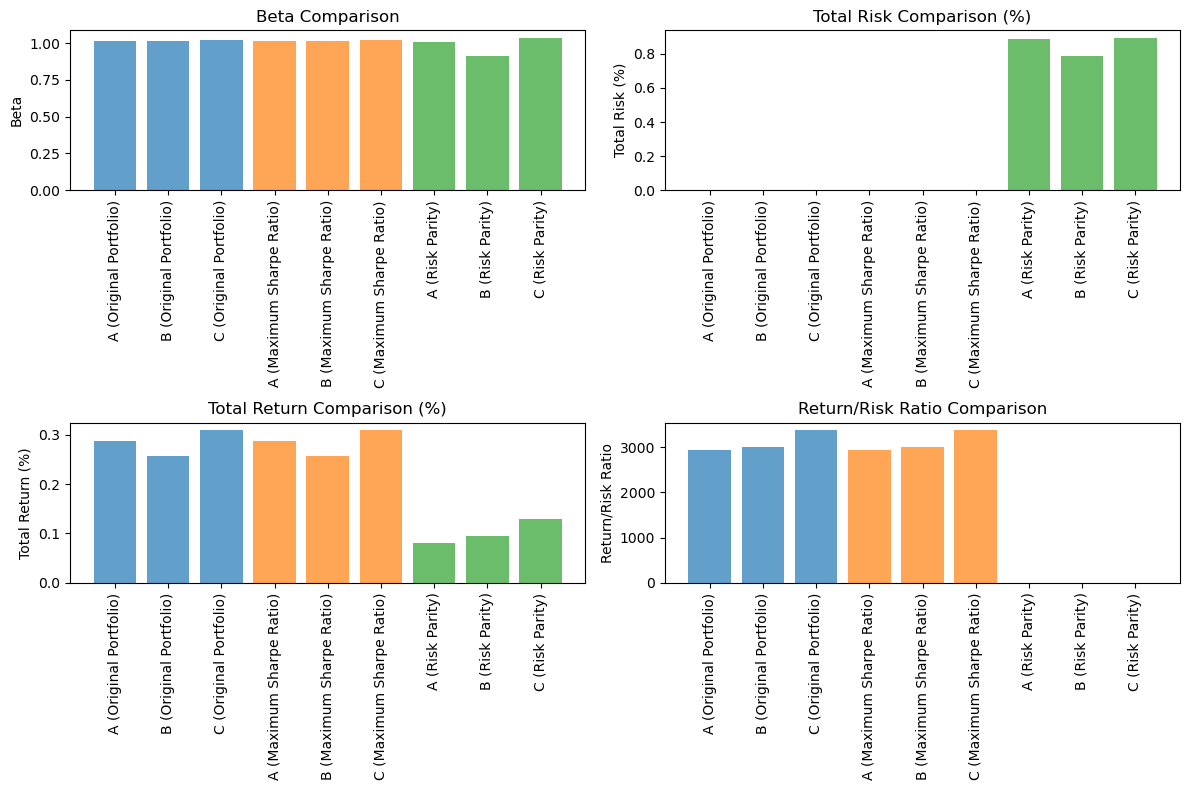

In [3]:
# Load data
def load_data():
    initial_portfolio = pd.read_csv('initial_portfolio.csv')
    capm_results = pd.read_csv('capm_regression_results.csv')
    daily_prices = pd.read_csv('DailyPrices.csv')
    rf_rates = pd.read_csv('rf.csv')
    
    # Also load results from Part 1 and Part 2 for comparison
    try:
        part1_risk = pd.read_csv('optimal_portfolio_risk_attribution.csv')
        part1_return = pd.read_csv('optimal_portfolio_return_attribution.csv')
        part2_risk = pd.read_csv('PART_2_optimal_portfolio_risk.csv')
        part2_return = pd.read_csv('PART_2_optimal_portfolio_attribution.csv')
        return initial_portfolio, capm_results, daily_prices, rf_rates, part1_risk, part1_return, part2_risk, part2_return
    except:
        print("Some comparison files not found, will only perform risk parity portfolio analysis")
        return initial_portfolio, capm_results, daily_prices, rf_rates, None, None, None, None

# Normalize portfolio weights
def normalize_portfolio_weights(initial_portfolio):
    # Create a dictionary of normalized weights, grouped by portfolio
    normalized_weights = {}
    
    # Get unique portfolios
    portfolios = initial_portfolio['Portfolio'].unique()
    
    for portfolio in portfolios:
        # Get all stocks in this portfolio
        portfolio_data = initial_portfolio[initial_portfolio['Portfolio'] == portfolio]
        
        # Calculate total holdings weight
        total_holding = portfolio_data['Holding'].sum()
        
        # Create normalized weights dictionary
        weights = {}
        for _, row in portfolio_data.iterrows():
            symbol = row['Symbol']
            normalized_weight = row['Holding'] / total_holding
            weights[symbol] = normalized_weight
        
        normalized_weights[portfolio] = weights
    
    return normalized_weights

# Calculate returns from prices
def calculate_returns(prices):
    # Ensure it's a DataFrame
    if not isinstance(prices, pd.DataFrame):
        prices = pd.DataFrame(prices)
    
    # Save date column
    date_col = None
    if 'Date' in prices.columns:
        date_col = prices['Date'].copy()
        prices = prices.drop(columns=['Date'])
    
    # Ensure all columns are numeric
    for col in prices.columns:
        if prices[col].dtype == object:  # If column is object type
            try:
                prices[col] = pd.to_numeric(prices[col])
            except:
                print(f"Warning: Column '{col}' contains non-numeric data, will skip")
                prices[col] = np.nan
    
    # Calculate returns
    returns = prices.pct_change().dropna()
    
    # Add date column back if it existed
    if date_col is not None:
        # Since pct_change removes the first row, we need to adjust the date column
        if len(date_col) > len(returns):
            date_col = date_col.iloc[1:].reset_index(drop=True)
        
        # Ensure date column length matches returns
        if len(date_col) == len(returns):
            returns['Date'] = date_col.values
    
    return returns

# Split data into pre-holding and holding periods
def split_data(prices, returns, rf_rates):
    # Find the last trading day of 2023
    last_2023_date = None
    for date in prices['Date']:
        if '2023' in str(date):
            last_2023_date = date
    
    if last_2023_date is None:
        print("Error: No data found for 2023")
        return None, None, None, None, None, None
    
    # Split the data
    pre_holding_prices = prices[prices['Date'] <= last_2023_date].copy()
    pre_holding_returns = returns[returns['Date'] <= last_2023_date].copy()
    holding_prices = prices[prices['Date'] > last_2023_date].copy()
    holding_returns = returns[returns['Date'] > last_2023_date].copy()
    
    # Split risk-free rates
    pre_holding_rf = rf_rates[rf_rates['Date'] <= last_2023_date].copy()
    holding_rf = rf_rates[rf_rates['Date'] > last_2023_date].copy()
    
    return pre_holding_prices, pre_holding_returns, holding_prices, holding_returns, pre_holding_rf, holding_rf

# Calculate portfolio expected shortfall
def portfolio_expected_shortfall(returns, weights, alpha=0.05):
    # If weights is a dictionary, convert to array corresponding to returns columns
    if isinstance(weights, dict):
        weight_array = np.zeros(len(returns.columns))
        for i, col in enumerate(returns.columns):
            if col in weights:
                weight_array[i] = weights[col]
        weights = weight_array
    
    # Remove Date column if it exists
    returns_data = returns.copy()
    if 'Date' in returns_data.columns:
        returns_data = returns_data.drop(columns=['Date'])
    
    # Calculate portfolio returns
    portfolio_returns = np.dot(returns_data.values, weights)
    
    # Sort returns
    sorted_returns = np.sort(portfolio_returns)
    
    # Calculate cutoff point for expected shortfall
    cutoff_index = int(np.ceil(alpha * len(sorted_returns)))
    
    # Calculate expected shortfall (ES)
    if cutoff_index > 0:
        es = -np.mean(sorted_returns[:cutoff_index])
    else:
        es = -sorted_returns[0]
    
    return es

# Calculate marginal risk contribution
def marginal_risk_contribution(returns, weights, es_function, eps=1e-6):
    n = len(weights)
    portfolio_es = es_function(returns, weights)
    marginal_contributions = []
    
    for i in range(n):
        # For each asset, slightly increase its weight and calculate ES change
        w_plus = weights.copy()
        w_plus[i] += eps
        w_plus = w_plus / np.sum(w_plus)  # Renormalize
        
        es_plus = es_function(returns, w_plus)
        marginal_contribution = (es_plus - portfolio_es) / eps
        marginal_contributions.append(marginal_contribution)
    
    return np.array(marginal_contributions)

# Calculate risk contributions
def risk_contributions(returns, weights, es_function):
    # If weights is a dictionary, convert to numpy array
    if isinstance(weights, dict):
        symbol_list = list(weights.keys())
        weight_array = np.array([weights[s] for s in symbol_list])
        marginal_contribs = marginal_risk_contribution(returns[symbol_list], weight_array, es_function)
        return weight_array * marginal_contribs
    else:
        marginal_contribs = marginal_risk_contribution(returns, weights, es_function)
        return weights * marginal_contribs

# Create risk parity portfolio
def create_risk_parity_portfolio(returns, symbols, es_function):
    n = len(symbols)
    initial_weights = np.ones(n) / n
    
    def risk_parity_objective(weights):
        weights = np.array(weights)
        # Normalize weights
        weights = weights / np.sum(weights)
        
        # Calculate risk contributions
        risk_contribs = risk_contributions(returns[symbols], weights, es_function)
        
        # Target risk contribution (average)
        target_risk_contrib = np.mean(risk_contribs)
        
        # Calculate sum of squared deviations of risk contributions
        return np.sum((risk_contribs - target_risk_contrib) ** 2)
    
    # Constraints: sum of weights equals 1 and non-negative
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0.001, 1) for _ in range(n)]  # Set minimum weight to avoid numerical issues
    
    # Perform optimization
    result = minimize(risk_parity_objective, initial_weights, bounds=bounds, constraints=constraints, method='SLSQP')
    
    # Get optimal weights
    optimal_weights = result['x']
    # Normalize again to ensure sum equals 1
    optimal_weights = optimal_weights / np.sum(optimal_weights)
    
    # Create weights dictionary
    weight_dict = {symbol: weight for symbol, weight in zip(symbols, optimal_weights)}
    
    return weight_dict

# Calculate portfolio metrics (risk and return attribution) - converted to percentage form and multiplied by 100
def calculate_portfolio_metrics(portfolio_weights, beta_values, pre_returns, holding_returns, rf_rates, market_col='SPY'):
    # Convert weights and betas to numpy arrays for calculation
    symbols = list(portfolio_weights.keys())
    weights = np.array([portfolio_weights[symbol] for symbol in symbols])
    
    # Get beta value for each stock
    betas = []
    for symbol in symbols:
        beta_row = beta_values[beta_values['Stock'] == symbol]
        if len(beta_row) > 0:
            betas.append(beta_row['Beta'].values[0])
        else:
            # If beta not found, use 1.0 as default
            print(f"Warning: Beta not found for {symbol}, using 1.0 as default")
            betas.append(1.0)
    
    betas = np.array(betas)
    
    # Calculate portfolio beta
    portfolio_beta = np.sum(weights * betas)
    
    # Remove Date column if it exists
    pre_returns_data = pre_returns.copy()
    holding_returns_data = holding_returns.copy()
    
    if 'Date' in pre_returns_data.columns:
        pre_returns_data = pre_returns_data.drop(columns=['Date'])
    if 'Date' in holding_returns_data.columns:
        holding_returns_data = holding_returns_data.drop(columns=['Date'])
    
    # Calculate market variance using pre-holding period data
    market_variance = pre_returns_data[market_col].var()
    
    # Filter to include only stocks in the portfolio
    returns_symbols = [s for s in symbols if s in pre_returns_data.columns]
    
    # Check if returned data is sufficient
    if len(returns_symbols) < len(symbols):
        missing_symbols = set(symbols) - set(returns_symbols)
        print(f"Warning: The following stocks were not found in returns data: {missing_symbols}")
    
    # Calculate portfolio variance
    filtered_returns = pre_returns_data[returns_symbols]
    filtered_weights = np.array([portfolio_weights[s] for s in returns_symbols])
    filtered_weights = filtered_weights / np.sum(filtered_weights)  # Normalize filtered weights
    
    cov_matrix = filtered_returns.cov()
    portfolio_variance = filtered_weights @ cov_matrix @ filtered_weights
    
    # Calculate systematic risk
    systematic_risk = (portfolio_beta ** 2) * market_variance
    
    # Calculate idiosyncratic risk
    idiosyncratic_risk = portfolio_variance - systematic_risk
    
    # Calculate risk proportions
    systematic_risk_proportion = systematic_risk / portfolio_variance if portfolio_variance > 0 else 0
    idiosyncratic_risk_proportion = idiosyncratic_risk / portfolio_variance if portfolio_variance > 0 else 0
    
    # Return attribution calculation
    avg_rf = rf_rates['rf'].mean()
    
    # Convert market return to percentage form multiplied by 100
    market_excess_return = holding_returns_data[market_col].mean() * 100  - avg_rf * 100 
    
    # Calculate portfolio return
    holding_symbols = [s for s in symbols if s in holding_returns_data.columns]
    holding_weights = np.array([portfolio_weights[s] for s in holding_symbols])
    holding_weights = holding_weights / np.sum(holding_weights)  # Normalize
    
    # Convert to percentage form and multiply by 100
    portfolio_return = np.sum(holding_weights * holding_returns_data[holding_symbols].mean()) * 100 
    
    # Calculate systematic and idiosyncratic returns (percentage form multiplied by 100)
    systematic_return = portfolio_beta * market_excess_return
    idiosyncratic_return = portfolio_return - avg_rf * 100 - systematic_return
    
    # Calculate return proportions
    total_excess_return = portfolio_return - avg_rf * 100 
    systematic_proportion = systematic_return / total_excess_return if total_excess_return != 0 else np.nan
    idiosyncratic_proportion = idiosyncratic_return / total_excess_return if total_excess_return != 0 else np.nan
    
    # Return all metrics, including returns and risk metrics converted to percentage form multiplied by 100
    return {
        'Beta': portfolio_beta,
        'Total_Risk': np.sqrt(portfolio_variance) * 100 ,  # Convert to percentage and multiply by 100
        'Systematic_Risk': np.sqrt(systematic_risk) * 100 if systematic_risk > 0 else 0,  # Convert to percentage and multiply by 100
        'Idiosyncratic_Risk': np.sqrt(idiosyncratic_risk) * 100  if idiosyncratic_risk > 0 else 0,  # Convert to percentage and multiply by 100
        'Systematic_Risk_Proportion': systematic_risk_proportion,
        'Idiosyncratic_Risk_Proportion': idiosyncratic_risk_proportion,
        'Total_Return': portfolio_return,  # Already in percentage form and multiplied by 100
        'Systematic_Return': systematic_return,  # Already in percentage form and multiplied by 100
        'Idiosyncratic_Return': idiosyncratic_return,  # Already in percentage form and multiplied by 100
        'Systematic_Proportion': systematic_proportion,
        'Idiosyncratic_Proportion': idiosyncratic_proportion,
        'Covered_Weight': 1.0
    }

# Main function to run the analysis
def main():
    # Load all data
    initial_portfolio, capm_results, daily_prices, rf_rates, part1_risk, part1_return, part2_risk, part2_return = load_data()
    
    # First normalize initial portfolio weights
    normalized_weights = normalize_portfolio_weights(initial_portfolio)
    
    # Print data information for debugging
    print("Data loading complete")
    print(f"Initial portfolio shape: {initial_portfolio.shape}")
    print(f"CAPM results shape: {capm_results.shape}")
    print(f"Daily prices shape: {daily_prices.shape}")
    print(f"Risk-free rates shape: {rf_rates.shape}")
    
    # Calculate returns
    returns = calculate_returns(daily_prices)
    print(f"\nReturns data shape: {returns.shape}")
    
    # Print returns sample to check data
    if 'SPY' in returns.columns:
        print("\nSPY returns sample (original decimal form):")
        print(returns['SPY'].head())
        print(f"SPY average return: {returns['SPY'].mean():.6f}")
        print(f"SPY average return (percentage form x 100): {returns['SPY'].mean() * 100 :.4f}")
    
    # Split data into pre-holding and holding periods
    split_result = split_data(daily_prices, returns, rf_rates)
    
    if split_result is None:
        print("Failed to split data, cannot continue analysis")
        return None
    
    pre_holding_prices, pre_holding_returns, holding_prices, holding_returns, pre_holding_rf, holding_rf = split_result
    
    # Print split data information
    print(f"\nPre-holding prices shape: {pre_holding_prices.shape}")
    print(f"Pre-holding returns shape: {pre_holding_returns.shape}")
    print(f"Holding period prices shape: {holding_prices.shape}")
    print(f"Holding period returns shape: {holding_returns.shape}")
    
    # Print risk-free rate information
    print(f"\nRisk-free rate sample:")
    print(rf_rates.head())
    print(f"Average risk-free rate: {rf_rates['rf'].mean():.6f}")
    print(f"Average risk-free rate (percentage form x 100): {rf_rates['rf'].mean()  * 100:.4f}")
    
    # Get unique portfolios
    portfolios = initial_portfolio['Portfolio'].unique()
    print(f"\nNumber of portfolios: {len(portfolios)}")
    print(f"Portfolios: {portfolios}")
    
    # Create dictionary to store risk parity weights
    risk_parity_weights = {}
    
    # For each portfolio, calculate risk parity weights
    for portfolio in portfolios:
        # Get stocks in this portfolio
        portfolio_data = initial_portfolio[initial_portfolio['Portfolio'] == portfolio]
        symbols = portfolio_data['Symbol'].tolist()
        
        print(f"\nProcessing portfolio {portfolio}, containing {len(symbols)} stocks")
        
        # Create column subset for ES function
        valid_symbols = [s for s in symbols if s in pre_holding_returns.columns]
        
        if len(valid_symbols) < len(symbols):
            missing_symbols = set(symbols) - set(valid_symbols)
            print(f"The following stocks in portfolio {portfolio} are missing from returns data: {missing_symbols}")
        
        print(f"Number of valid stocks: {len(valid_symbols)}")
        
        if len(valid_symbols) == 0:
            print(f"Error: Portfolio {portfolio} has no valid stocks, skipping")
            continue
        
        # Create risk parity portfolio
        try:
            weights = create_risk_parity_portfolio(
                pre_holding_returns, 
                valid_symbols, 
                lambda ret, w: portfolio_expected_shortfall(ret[valid_symbols], w)
            )
            print(f"Risk parity weights calculated successfully")
            risk_parity_weights[portfolio] = weights
        except Exception as e:
            print(f"Error calculating risk parity weights: {str(e)}")
            # If optimization fails, use equal weights
            weights = {symbol: 1.0/len(valid_symbols) for symbol in valid_symbols}
            risk_parity_weights[portfolio] = weights
            print(f"Using equal weights as fallback")
    
    # Calculate metrics for risk parity portfolios
    risk_parity_metrics = {}
    
    for portfolio, weights in risk_parity_weights.items():
        print(f"\nCalculating metrics for portfolio {portfolio}")
        try:
            metrics = calculate_portfolio_metrics(
                weights,
                capm_results,
                pre_holding_returns,
                holding_returns,
                holding_rf
            )
            print(f"Metrics calculated successfully")
            print(f"Portfolio {portfolio} total return (percentage x 100): {metrics['Total_Return']:.4f}")
            print(f"Portfolio {portfolio} systematic return (percentage x 100): {metrics['Systematic_Return']:.4f}")
            print(f"Portfolio {portfolio} idiosyncratic return (percentage x 100): {metrics['Idiosyncratic_Return']:.4f}")
            risk_parity_metrics[portfolio] = metrics
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
    
    # Create dataframes for risk parity results
    risk_parity_risk_df = pd.DataFrame({
        'Portfolio': [],
        'Beta': [],
        'Total_Risk': [],
        'Systematic_Risk': [],
        'Idiosyncratic_Risk': [],
        'Systematic_Risk_Proportion': [],
        'Idiosyncratic_Risk_Proportion': []
    })
    
    risk_parity_return_df = pd.DataFrame({
        'Portfolio': [],
        'Beta': [],
        'Total_Return': [],
        'Systematic_Return': [],
        'Idiosyncratic_Return': [],
        'Systematic_Proportion': [],
        'Idiosyncratic_Proportion': [],
        'Covered_Weight': []
    })
    
    # Fill risk parity results dataframes
    for portfolio, metrics in risk_parity_metrics.items():
        # Add to risk dataframe
        risk_row = {
            'Portfolio': portfolio,
            'Beta': metrics['Beta'],
            'Total_Risk': metrics['Total_Risk'],
            'Systematic_Risk': metrics['Systematic_Risk'],
            'Idiosyncratic_Risk': metrics['Idiosyncratic_Risk'],
            'Systematic_Risk_Proportion': metrics['Systematic_Risk_Proportion'],
            'Idiosyncratic_Risk_Proportion': metrics['Idiosyncratic_Risk_Proportion']
        }
        risk_parity_risk_df = pd.concat([risk_parity_risk_df, pd.DataFrame([risk_row])], ignore_index=True)
        
        # Add to return dataframe
        return_row = {
            'Portfolio': portfolio,
            'Beta': metrics['Beta'],
            'Total_Return': metrics['Total_Return'],
            'Systematic_Return': metrics['Systematic_Return'],
            'Idiosyncratic_Return': metrics['Idiosyncratic_Return'],
            'Systematic_Proportion': metrics['Systematic_Proportion'],
            'Idiosyncratic_Proportion': metrics['Idiosyncratic_Proportion'],
            'Covered_Weight': metrics['Covered_Weight']
        }
        risk_parity_return_df = pd.concat([risk_parity_return_df, pd.DataFrame([return_row])], ignore_index=True)
    
    # Output results
    print("\nRisk parity portfolio risk metrics:")
    print(risk_parity_risk_df)
    print("\nRisk parity portfolio return attribution:")
    print(risk_parity_return_df)
    
    # Save results to CSV
    risk_parity_risk_df.to_csv('PART_5_risk_parity_risk.csv', index=False)
    risk_parity_return_df.to_csv('PART_5_risk_parity_return.csv', index=False)
    
    # If comparison data exists, generate comparison results
    if part1_risk is not None and part2_risk is not None:
        # Merge risk results
        part1_risk_df = part1_risk.copy()
        part1_risk_df['Method'] = 'Original Portfolio'
        
        part2_risk_df = part2_risk.copy()
        part2_risk_df['Method'] = 'Maximum Sharpe Ratio'
        
        risk_parity_risk_df['Method'] = 'Risk Parity'
        
        combined_risk = pd.concat([part1_risk_df, part2_risk_df, risk_parity_risk_df], ignore_index=True)
        
        # Merge return results
        part1_return_df = part1_return.copy()
        part1_return_df['Method'] = 'Original Portfolio'
        
        part2_return_df = part2_return.copy()
        part2_return_df['Method'] = 'Maximum Sharpe Ratio'
        
        risk_parity_return_df['Method'] = 'Risk Parity'
        
        combined_return = pd.concat([part1_return_df, part2_return_df, risk_parity_return_df], ignore_index=True)
        
        # Create comparison tables
        print("\nRisk metrics comparison between different methods:")
        print(combined_risk)
        
        print("\nReturn attribution comparison between different methods:")
        print(combined_return)
        
        # Save merged results to CSV
        combined_risk.to_csv('portfolio_methods_risk_comparison.csv', index=False)
        combined_return.to_csv('portfolio_methods_return_comparison.csv', index=False)
        
        # Create visualization charts
        plt.figure(figsize=(12, 8))
        
        # Plot Beta comparison
        plt.subplot(2, 2, 1)
        for method in ['Original Portfolio', 'Maximum Sharpe Ratio', 'Risk Parity']:
            method_data = combined_risk[combined_risk['Method'] == method]
            plt.bar(method_data['Portfolio'] + ' (' + method + ')', method_data['Beta'], alpha=0.7)
        
        plt.title('Beta Comparison')
        plt.ylabel('Beta')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        # Plot Total Risk comparison
        plt.subplot(2, 2, 2)
        for method in ['Original Portfolio', 'Maximum Sharpe Ratio', 'Risk Parity']:
            method_data = combined_risk[combined_risk['Method'] == method]
            plt.bar(method_data['Portfolio'] + ' (' + method + ')', method_data['Total_Risk'], alpha=0.7)
        
        plt.title('Total Risk Comparison (%)')
        plt.ylabel('Total Risk (%)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        # Plot Total Return comparison
        plt.subplot(2, 2, 3)
        for method in ['Original Portfolio', 'Maximum Sharpe Ratio', 'Risk Parity']:
            method_data = combined_return[combined_return['Method'] == method]
            plt.bar(method_data['Portfolio'] + ' (' + method + ')', method_data['Total_Return'], alpha=0.7)
        
        plt.title('Total Return Comparison (%)')
        plt.ylabel('Total Return (%)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        # Plot Return/Risk ratio comparison
        plt.subplot(2, 2, 4)
        
        # Calculate return/risk ratios
        risk_return_ratio = []
        for method in ['Original Portfolio', 'Maximum Sharpe Ratio', 'Risk Parity']:
            method_risk = combined_risk[combined_risk['Method'] == method]
            method_return = combined_return[combined_return['Method'] == method]
            
            for portfolio in portfolios:
                port_risk_rows = method_risk[method_risk['Portfolio'] == portfolio]
                port_return_rows = method_return[method_return['Portfolio'] == portfolio]
                
                if len(port_risk_rows) > 0 and len(port_return_rows) > 0:
                    port_risk = port_risk_rows['Total_Risk'].values[0]
                    port_return = port_return_rows['Total_Return'].values[0]
                    
                    if port_risk > 0:
                        risk_return_ratio.append({
                            'Portfolio': portfolio,
                            'Method': method,
                            'Ratio': port_return / port_risk
                        })
        
        risk_return_df = pd.DataFrame(risk_return_ratio)
        
        for method in ['Original Portfolio', 'Maximum Sharpe Ratio', 'Risk Parity']:
            method_data = risk_return_df[risk_return_df['Method'] == method]
            plt.bar(method_data['Portfolio'] + ' (' + method + ')', method_data['Ratio'], alpha=0.7)
        
        plt.title('Return/Risk Ratio Comparison')
        plt.ylabel('Return/Risk Ratio')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        plt.savefig('portfolio_comparison.png', dpi=300, bbox_inches='tight')
        
        return combined_risk, combined_return, risk_parity_weights, risk_return_df
    
    return risk_parity_risk_df, risk_parity_return_df, risk_parity_weights

if __name__ == "__main__":
    results = main()